In [1]:
# install necessary libraries

!pip install datasets
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.4 MB/s eta 0:00:00


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import nltk
import numpy as np
import pandas as pd
import torchtext
import itertools
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.modules.loss import _WeightedLoss

from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset


from nltk.corpus import stopwords
from contractions import contractions_dict
from nltk.stem import WordNetLemmatizer
from collections import Counter


In [3]:
# connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load the LIAR dataset from huggingface and printing sizes of train, val and test dataframes

dataset = load_dataset("liar")

train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

print(f"Length of training data: {len(train_df)}")
print(f"Length of validation data: {len(val_df)}")
print(f"Length of testing data: {len(test_df) }")

Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

Length of training data: 10269
Length of validation data: 1284
Length of testing data: 1283


In [5]:
train_df.head(10)

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
5,12465.json,3,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
6,2342.json,4,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
7,153.json,1,"""I'm the only person on this stage who has wor...",ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
8,5602.json,1,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,,,organization,0.0,0.0,1.0,0.0,1.0,a website
9,9741.json,2,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video


In [6]:
# filling missing values with 'None', creating a new 'total_news' column by conacating all the relevant column, and dropping irrelevant columns

def preprocessing(data):
    data['subject'] = data['subject'].fillna('None')
    data['speaker'] = data['speaker'].fillna('None')
    data['job_title'] = data['job_title'].fillna('None')
    data['state_info'] = data['state_info'].fillna('None')
    data['party_affiliation'] = data['party_affiliation'].fillna('None')
    data['context'] = data['context'].fillna('None')

    data['meta'] = data[['subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'context']].astype(str).agg(' '.join, axis=1)
    data['total_news'] = data['meta'] + ' ' + data['statement'].astype(str)

    data = data.drop(['id', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'meta'], axis=1)  # dropping metadata columns, as we have merged them into a single column
    data = data.dropna()

    return data

In [7]:
# apply preprocessing to train, val, test dataframes

train_df = preprocessing(train_df)
val_df = preprocessing(val_df)
test_df = preprocessing(test_df)

In [8]:
train_df.head(10)

,label,total_news
0,0,abortion dwayne-bohac State representative Tex...
1,1,"energy,history,job-accomplishments scott-surov..."
2,2,foreign-policy barack-obama President Illinois...
3,0,health-care blog-posting none a news release...
4,1,"economy,jobs charlie-crist Florida democrat a..."
5,3,education robin-vos Wisconsin Assembly speaker...
6,4,candidates-biography republican-party-texas T...
7,1,ethics barack-obama President Illinois democra...
8,1,jobs oregon-lottery organization a website ...
9,2,"energy,message-machine-2014,voting-record duey..."


In [9]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
stop_words = set(stopwords.words("english"))
print(stop_words)

{'while', "hasn't", 'our', 'we', 's', "it's", 'these', 'were', "aren't", 'same', 'up', 'so', 'as', 'or', 'yourselves', 'own', 'herself', 'was', "haven't", 'their', "won't", 'her', 'at', 'll', 'do', 'hadn', 'does', "couldn't", 'than', "didn't", 'out', 'into', 'myself', "doesn't", 'she', 'which', 'further', 'until', 'below', 'other', "you're", 't', 'wasn', 'down', 'doing', "you'll", 'such', 'they', 'before', 'shouldn', 'its', 'wouldn', "that'll", 'ourselves', "don't", 'that', 'this', 'nor', 'been', 'did', 'his', 'through', 'haven', 'themselves', 'yourself', 'ain', 'hasn', 'most', 'itself', 'about', "you've", 'again', 'for', "hadn't", "you'd", 'yours', 'when', 'don', 'how', 'me', 'any', 'you', 'no', 'very', 'once', 'won', 'where', "wouldn't", 'there', 'between', 'both', 'with', 'an', 'him', 'needn', "weren't", 'mightn', 'o', 'a', 'i', 've', 'under', 'mustn', 'be', "shan't", 'those', 'after', "should've", 'are', 'against', 'whom', 'then', 'more', 'only', "isn't", 'your', 'and', 'd', "she's

In [11]:
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.sentence as nas


# aug_synonym = naw.SynonymAug()
# aug_antonym = naw.AntonymAug()
# aug_random = naw.RandomWordAug()

# aug_insert = nac.InsertAug()
# aug_substitute = nac.SubstituteAug()

# aug_context = nas.ContextualWordEmbsForSentenceAug(model_path='bert-base-uncased', action='insert')


# def augment(text):
#     augmented_text = aug_synonym.augment(text)
#     augmented_text = aug_antonym.augment(augmented_text)
#     augmented_text = aug_random.augment(augmented_text)
#     augmented_text = aug_insert.augment(augmented_text)
#     augmented_text = aug_substitute.augment(augmented_text)
#     augmented_text = aug_context.augment(augmented_text)

#     return augmented_text


In [12]:
# expands contractions, converts text to lowercase, removes URLs and parentheses, eliminates double quotes, lemmatizes words, and removes stopwords on a dataframe

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# expanding contractions
def expand(text):
    for c, e in contractions_dict.items():
        text = text.replace(c, e)
    return text

def clean_text(text):
    text = expand(text)
    # print(text)
    text = text.lower()
    # print(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # print(text)
    text = re.sub(r'\([^)]*\)', '', text)
    # print(text)
    text = re.sub('"', '', text)
    # print(text)
    words = [lemmatizer.lemmatize(w) for w in re.findall(r'\b\w+\b', text) if w not in stop_words]

    return " ".join(words).strip()


In [13]:
df = [train_df, test_df, val_df]

for data in df:
    data['total_news'] = data['total_news'].apply(clean_text)

In [14]:
# def augment_and_clean(text, label):
#     augmented_text = augment(text)
#     cleaned_text = clean_text(augmented_text)
#     return cleaned_text, label

In [15]:
# train_df['total_news'] = train_df['total_news'].apply(clean_text)
# val_df['total_news'] = val_df['total_news'].apply(clean_text)
# test_df['total_news'] = test_df['total_news'].apply(clean_text)


# train_df['augmented_total_news'], train_df['augmented_label'] = zip(*train_df.apply(lambda row: augment_and_clean(row['total_news'], row['label']), axis=1))
# combined_train_df = pd.concat([train_df, train_df[['augmented_total_news', 'augmented_label']]], ignore_index=True)



*   true(0) : The statement is accurate and there’s nothing significant missing.
*   mostly-true(1) : The statement is accurate but needs clarification or additional information.
*   half-true(2) : The statement is partially accurate but leaves out important details or takes things out of context.
*   barely-true(3) : The statement contains an element of truth but ignores critical facts that would give a different impression.
*   false(4) : The statement is not accurate.
*   pants-fire(5) : The statement is not accurate and makes a ridiculous claim. a.k.a. "Liar, Liar, Pants on Fire!"

In [16]:
# Adjusts labels for binary classification if num_labels is 2; otherwise, labels will be unchanged for 6-class classification.

num_labels = 6

if num_labels == 2:
    train_df['label'] = train_df['label'].apply(lambda x: 0 if x in [0, 1] else 1)
    val_df['label'] = val_df['label'].apply(lambda x: 0 if x in [0, 1] else 1)
    test_df['label'] = test_df['label'].apply(lambda x: 0 if x in [0, 1] else 1)
elif num_labels == 6:
    pass

In [17]:
tokenizer = get_tokenizer("basic_english")

# Tokenize the 'total_news' in each dataframe
train_tokens = [tokenizer(text) for text in train_df['total_news']]
val_tokens = [tokenizer(text) for text in val_df['total_news']]
test_tokens = [tokenizer(text) for text in test_df['total_news']]

# combine all the tokens in the dataset
total_tokens = train_tokens + val_tokens + test_tokens

# counts the occurrences of each token in the entire dataset
word_counter = Counter([token for tokens in total_tokens for token in tokens])

# Create vocabulary from word_counter where the occurence of token is atleast '1' and adding a special token '<unk>' for unknown words.
Vocab = vocab(word_counter, min_freq=1, specials=['<unk>'])


In [18]:
# map the tokenized representations of text data to numerical indices using predifined vocabulary

def number_tokens(tokens):
    return [Vocab[token] if token in Vocab else Vocab['<unk>'] for token in tokens]


train_numbers = [number_tokens(tokens) for tokens in train_tokens]
val_numbers = [number_tokens(tokens) for tokens in val_tokens]
test_numbers = [number_tokens(tokens) for tokens in test_tokens]


In [19]:
print('\nOriginal News: ',train_df['total_news'][110])

print('\n After Tokenization: ',train_tokens[110])

print('\n After Numericalization: ',train_numbers[110])


Original News:  government regulation job poverty welfare scott walker milwaukee county executive wisconsin republican speech two third wisconsinite receiving unemployment check required search work due current work search exemption

 After Tokenization:  ['government', 'regulation', 'job', 'poverty', 'welfare', 'scott', 'walker', 'milwaukee', 'county', 'executive', 'wisconsin', 'republican', 'speech', 'two', 'third', 'wisconsinite', 'receiving', 'unemployment', 'check', 'required', 'search', 'work', 'due', 'current', 'work', 'search', 'exemption']

 After Numericalization:  [209, 270, 20, 186, 1111, 22, 337, 1112, 895, 1113, 85, 7, 28, 103, 15, 1114, 1115, 408, 1116, 1117, 1118, 427, 220, 1119, 427, 1118, 1120]


In [20]:
# calculates maximum length of a sequence in the entire dat, which will be used further in models
max_padding = max(len(sequence) for sequence in total_tokens)

# Padding sequences to a fixed length so that model performs well
train_padded = pad_sequence([torch.tensor(nums) for nums in train_numbers], batch_first=True)
val_padded = pad_sequence([torch.tensor(nums) for nums in val_numbers], batch_first=True)
test_padded = pad_sequence([torch.tensor(nums) for nums in test_numbers], batch_first=True)


In [21]:
train_dataset = TensorDataset(train_padded, torch.tensor(train_df["label"]))
val_dataset = TensorDataset(val_padded, torch.tensor(val_df["label"]))
test_dataset = TensorDataset(test_padded, torch.tensor(test_df["label"]))


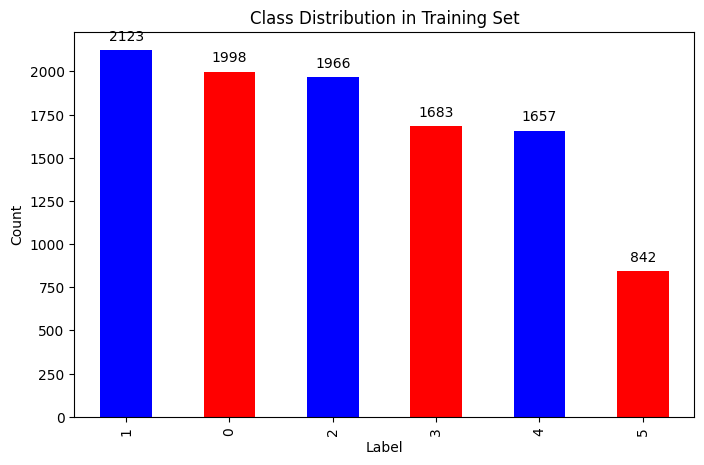

In [24]:
# Class distribution analysis
plt.figure(figsize=(8, 5))
ax = train_df['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10, color='black')
plt.title('Class Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [25]:
# We used focal loss as there is imbalanced data in training
class FocalLoss(_WeightedLoss):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__(weight, reduction=reduction)
        self.gamma = gamma

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss

In [26]:
# returns an optimizer based on the specified optimizer name(Adam/SGD/RMSProp) with the given learning rate.
def get_optimizer(optimizer_name, parameters, learning_rate):
    if optimizer_name == 'Adam':
        return optim.Adam(parameters, lr=learning_rate)
    elif optimizer_name == 'SGD':
        return optim.SGD(parameters, lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(parameters, lr=learning_rate)

# BiLSTM Model

In [63]:
class BilstmModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout, bidirectional, output_dim):
        super(BilstmModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, unknown = self.bilstm(x)
        x = torch.cat((x[:, -1, :hidden_size], x[:, 0, hidden_size:]), dim=-1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Define hyperparameters for the model where some of them can be changed later
vocab_size = len(Vocab)
embedding_dim = 128
hidden_size = 64
output_dim = 6
num_layers = 1
bidirectional = True
dropout = 0.5

# Define Model and print the architecture of the model
model = BilstmModel(vocab_size, embedding_dim, hidden_size, num_layers, dropout, bidirectional, output_dim)
print(model)


BilstmModel(
  (embedding): Embedding(14286, 128)
  (bilstm): LSTM(128, 64, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training each model on these cobination of hyperparameters
learning_rates = [0.001, 0.01]
optimizers = ['Adam', 'SGD', 'RMSprop']
loss_functions = [nn.CrossEntropyLoss(), FocalLoss(gamma=2)]
batch_sizes = [32, 64, 128]
embedding_dims = [100, 200, 300]

combinations = list(itertools.product(learning_rates, optimizers, loss_functions, batch_sizes, embedding_dims))

results = []
best_accuracy = 0.0
best_hyperparameters = None
best_model = None

for combination in tqdm(combinations):
    learning_rate, optimizer_name, loss_fn, batch_size, embedding_dim = combination

    # create a model for each of the hyperparameter combination, train and evaluate on test data
    model = BilstmModel(vocab_size, embedding_dim, hidden_size, num_layers, dropout, bidirectional, output_dim)
    model.to(device)

    # set the optimizer and loss function
    optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate)
    criterion = loss_fn

    # Loaders are used to efficiently iterate over the datasets in batches during the training and evaluation processes
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0.0
        training_corrects = 0
        training_count = 0

        # Model Training
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # print(inputs)
            # print(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs)

            loss = criterion(outputs, labels)
            loss.backward()
            training_loss += loss.item()

            optimizer.step()

            x, preds = torch.max(outputs.data, 1)
            # print(preds)

            training_count += labels.size(0)
            training_corrects += torch.sum(preds == labels).item()

        # calculate the average loss and accuracy for the each training epoch
        train_epoch_loss = training_loss / len(train_loader)
        train_epoch_accuracy = training_corrects / training_count



        # Model Validation on data that it hasn't seen during training and adjust hyperparameters
        model.eval()
        validation_loss = 0.0
        validation_corrects = 0
        validation_count = 0

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                # print(inputs)
                # print(labels)
                # print(outputs)

                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                x, preds = torch.max(outputs.data, 1)
                # print(preds)

                validation_count += labels.size(0)
                validation_corrects += torch.sum(preds == labels).item()

        # calculate the average loss and accuracy for the each validation epoch
        val_epoch_loss = validation_loss / len(val_loader)
        val_epoch_accuracy = validation_corrects / validation_count

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy * 100:.2f}%, "
              f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy * 100:.2f}")



    # Testing the accuracy of the model on test data
    test_loss = 0.0
    test_corrects = 0
    test_count = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # print(inputs)
            # print(labels)
            # print(outputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            x, preds = torch.max(outputs.data, 1)
            # print(preds)

            test_count += labels.size(0)
            test_corrects += torch.sum(preds == labels).item()

    # calculate the average test_loss and test_accuracy on the training data
    average_test_loss = test_loss / len(test_loader)
    average_test_accuracy = test_corrects / test_count

    result = {
        'Learning Rate': learning_rate,
        'Optimizer': optimizer_name,
        'Loss Function': loss_fn.__class__.__name__,
        'Batch Size': batch_size,
        'Embedding Dim': embedding_dim,
        'Test Accuracy': average_test_accuracy
    }
    results.append(result)
    # Add each hyperparameter combination with the test accuracy tp results list for later analysis

    print(f"Hyperparameters: LR={learning_rate}, Optimizer={optimizer_name}, Loss={loss_fn.__class__.__name__}, "
          f"Batch Size={batch_size}, Embedding Dim={embedding_dim}, "
          f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {average_test_accuracy * 100:.2f}")

    # The best-performing model and its associated hyperparameters are stored for later analysis
    if average_test_accuracy > best_accuracy:
        best_accuracy = average_test_accuracy
        best_hyperparameters = combination
        best_model = model.state_dict()



  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 1.7592, Train Accuracy: 20.88%, Validation Loss: 1.7301, Validation Accuracy: 21.57
Epoch 2/5, Train Loss: 1.7084, Train Accuracy: 24.26%, Validation Loss: 1.6853, Validation Accuracy: 25.16
Epoch 3/5, Train Loss: 1.6631, Train Accuracy: 27.67%, Validation Loss: 1.6758, Validation Accuracy: 25.55
Epoch 4/5, Train Loss: 1.5993, Train Accuracy: 31.91%, Validation Loss: 1.6902, Validation Accuracy: 26.95


  1%|          | 1/108 [00:10<19:17, 10.82s/it]

Epoch 5/5, Train Loss: 1.5179, Train Accuracy: 36.06%, Validation Loss: 1.7275, Validation Accuracy: 25.08
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7176, Test Accuracy: 25.64
Epoch 1/5, Train Loss: 1.7603, Train Accuracy: 20.02%, Validation Loss: 1.7378, Validation Accuracy: 20.72
Epoch 2/5, Train Loss: 1.7042, Train Accuracy: 24.90%, Validation Loss: 1.6880, Validation Accuracy: 25.08
Epoch 3/5, Train Loss: 1.6425, Train Accuracy: 29.47%, Validation Loss: 1.6865, Validation Accuracy: 25.78
Epoch 4/5, Train Loss: 1.5590, Train Accuracy: 33.29%, Validation Loss: 1.7191, Validation Accuracy: 24.38


  2%|▏         | 2/108 [00:16<14:13,  8.05s/it]

Epoch 5/5, Train Loss: 1.4604, Train Accuracy: 38.96%, Validation Loss: 1.8087, Validation Accuracy: 23.52
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7770, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.7603, Train Accuracy: 20.56%, Validation Loss: 1.7488, Validation Accuracy: 20.56
Epoch 2/5, Train Loss: 1.7110, Train Accuracy: 24.83%, Validation Loss: 1.7070, Validation Accuracy: 23.91
Epoch 3/5, Train Loss: 1.6552, Train Accuracy: 28.56%, Validation Loss: 1.7039, Validation Accuracy: 25.47
Epoch 4/5, Train Loss: 1.5619, Train Accuracy: 33.65%, Validation Loss: 1.7382, Validation Accuracy: 24.53


  3%|▎         | 3/108 [00:24<14:05,  8.05s/it]

Epoch 5/5, Train Loss: 1.4471, Train Accuracy: 39.20%, Validation Loss: 1.7832, Validation Accuracy: 25.31
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7437, Test Accuracy: 27.59
Epoch 1/5, Train Loss: 1.7627, Train Accuracy: 19.96%, Validation Loss: 1.7488, Validation Accuracy: 20.79
Epoch 2/5, Train Loss: 1.7250, Train Accuracy: 23.77%, Validation Loss: 1.7086, Validation Accuracy: 23.68
Epoch 3/5, Train Loss: 1.6819, Train Accuracy: 27.20%, Validation Loss: 1.6848, Validation Accuracy: 24.22
Epoch 4/5, Train Loss: 1.6317, Train Accuracy: 30.34%, Validation Loss: 1.6845, Validation Accuracy: 26.25


  4%|▎         | 4/108 [00:28<10:34,  6.10s/it]

Epoch 5/5, Train Loss: 1.5698, Train Accuracy: 33.53%, Validation Loss: 1.7183, Validation Accuracy: 25.93
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7146, Test Accuracy: 27.67
Epoch 1/5, Train Loss: 1.7634, Train Accuracy: 20.00%, Validation Loss: 1.7511, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7249, Train Accuracy: 23.98%, Validation Loss: 1.7156, Validation Accuracy: 22.90
Epoch 3/5, Train Loss: 1.6744, Train Accuracy: 28.01%, Validation Loss: 1.7002, Validation Accuracy: 24.07
Epoch 4/5, Train Loss: 1.6103, Train Accuracy: 31.28%, Validation Loss: 1.7017, Validation Accuracy: 25.16


  5%|▍         | 5/108 [00:31<08:57,  5.22s/it]

Epoch 5/5, Train Loss: 1.5248, Train Accuracy: 35.59%, Validation Loss: 1.7261, Validation Accuracy: 25.70
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7211, Test Accuracy: 25.80
Epoch 1/5, Train Loss: 1.7619, Train Accuracy: 20.18%, Validation Loss: 1.7534, Validation Accuracy: 19.70
Epoch 2/5, Train Loss: 1.7208, Train Accuracy: 23.77%, Validation Loss: 1.7099, Validation Accuracy: 23.60
Epoch 3/5, Train Loss: 1.6748, Train Accuracy: 27.24%, Validation Loss: 1.7058, Validation Accuracy: 25.62
Epoch 4/5, Train Loss: 1.6123, Train Accuracy: 31.59%, Validation Loss: 1.7087, Validation Accuracy: 25.78


  6%|▌         | 6/108 [00:36<08:35,  5.05s/it]

Epoch 5/5, Train Loss: 1.5298, Train Accuracy: 36.16%, Validation Loss: 1.7670, Validation Accuracy: 25.16
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7260, Test Accuracy: 26.34
Epoch 1/5, Train Loss: 1.7669, Train Accuracy: 20.01%, Validation Loss: 1.7544, Validation Accuracy: 20.64
Epoch 2/5, Train Loss: 1.7455, Train Accuracy: 21.94%, Validation Loss: 1.7458, Validation Accuracy: 20.95
Epoch 3/5, Train Loss: 1.7170, Train Accuracy: 24.32%, Validation Loss: 1.7066, Validation Accuracy: 25.78
Epoch 4/5, Train Loss: 1.6732, Train Accuracy: 27.24%, Validation Loss: 1.6919, Validation Accuracy: 24.77


  6%|▋         | 7/108 [00:38<07:04,  4.21s/it]

Epoch 5/5, Train Loss: 1.6330, Train Accuracy: 29.26%, Validation Loss: 1.7006, Validation Accuracy: 25.62
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7059, Test Accuracy: 25.72
Epoch 1/5, Train Loss: 1.7656, Train Accuracy: 20.39%, Validation Loss: 1.7430, Validation Accuracy: 20.33
Epoch 2/5, Train Loss: 1.7365, Train Accuracy: 23.54%, Validation Loss: 1.7353, Validation Accuracy: 20.87
Epoch 3/5, Train Loss: 1.7019, Train Accuracy: 26.04%, Validation Loss: 1.7056, Validation Accuracy: 23.75
Epoch 4/5, Train Loss: 1.6624, Train Accuracy: 28.80%, Validation Loss: 1.6955, Validation Accuracy: 25.23


  7%|▋         | 8/108 [00:41<06:07,  3.68s/it]

Epoch 5/5, Train Loss: 1.6054, Train Accuracy: 32.11%, Validation Loss: 1.6990, Validation Accuracy: 25.93
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.6821, Test Accuracy: 27.20
Epoch 1/5, Train Loss: 1.7658, Train Accuracy: 20.24%, Validation Loss: 1.7468, Validation Accuracy: 23.21
Epoch 2/5, Train Loss: 1.7344, Train Accuracy: 23.42%, Validation Loss: 1.7332, Validation Accuracy: 21.65
Epoch 3/5, Train Loss: 1.7025, Train Accuracy: 26.02%, Validation Loss: 1.7045, Validation Accuracy: 23.36
Epoch 4/5, Train Loss: 1.6568, Train Accuracy: 29.18%, Validation Loss: 1.7073, Validation Accuracy: 24.38


  8%|▊         | 9/108 [00:44<05:43,  3.47s/it]

Epoch 5/5, Train Loss: 1.5920, Train Accuracy: 32.53%, Validation Loss: 1.7199, Validation Accuracy: 26.17
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7423, Test Accuracy: 24.63
Epoch 1/5, Train Loss: 1.2060, Train Accuracy: 20.63%, Validation Loss: 1.1825, Validation Accuracy: 21.26
Epoch 2/5, Train Loss: 1.1472, Train Accuracy: 24.63%, Validation Loss: 1.1242, Validation Accuracy: 25.00
Epoch 3/5, Train Loss: 1.0831, Train Accuracy: 27.95%, Validation Loss: 1.1230, Validation Accuracy: 25.16
Epoch 4/5, Train Loss: 1.0098, Train Accuracy: 31.53%, Validation Loss: 1.1356, Validation Accuracy: 25.23


  9%|▉         | 10/108 [00:50<06:53,  4.22s/it]

Epoch 5/5, Train Loss: 0.9203, Train Accuracy: 35.64%, Validation Loss: 1.1624, Validation Accuracy: 24.92
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1789, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.2062, Train Accuracy: 20.15%, Validation Loss: 1.1750, Validation Accuracy: 20.79
Epoch 2/5, Train Loss: 1.1426, Train Accuracy: 25.20%, Validation Loss: 1.1346, Validation Accuracy: 25.62
Epoch 3/5, Train Loss: 1.0785, Train Accuracy: 29.05%, Validation Loss: 1.1365, Validation Accuracy: 24.38
Epoch 4/5, Train Loss: 0.9917, Train Accuracy: 33.27%, Validation Loss: 1.1628, Validation Accuracy: 25.16


 10%|█         | 11/108 [00:57<08:20,  5.16s/it]

Epoch 5/5, Train Loss: 0.8707, Train Accuracy: 38.04%, Validation Loss: 1.2577, Validation Accuracy: 27.02
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2046, Test Accuracy: 27.51
Epoch 1/5, Train Loss: 1.2053, Train Accuracy: 21.76%, Validation Loss: 1.1896, Validation Accuracy: 19.70
Epoch 2/5, Train Loss: 1.1422, Train Accuracy: 25.45%, Validation Loss: 1.1335, Validation Accuracy: 27.02
Epoch 3/5, Train Loss: 1.0712, Train Accuracy: 29.20%, Validation Loss: 1.1283, Validation Accuracy: 26.87
Epoch 4/5, Train Loss: 0.9652, Train Accuracy: 34.61%, Validation Loss: 1.1583, Validation Accuracy: 26.40


 11%|█         | 12/108 [01:05<09:28,  5.92s/it]

Epoch 5/5, Train Loss: 0.8355, Train Accuracy: 40.46%, Validation Loss: 1.2506, Validation Accuracy: 24.69
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2520, Test Accuracy: 24.40
Epoch 1/5, Train Loss: 1.2094, Train Accuracy: 20.01%, Validation Loss: 1.1853, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.1553, Train Accuracy: 24.32%, Validation Loss: 1.1420, Validation Accuracy: 22.74
Epoch 3/5, Train Loss: 1.0982, Train Accuracy: 27.69%, Validation Loss: 1.1226, Validation Accuracy: 25.62
Epoch 4/5, Train Loss: 1.0401, Train Accuracy: 30.47%, Validation Loss: 1.1310, Validation Accuracy: 26.01


 12%|█▏        | 13/108 [01:09<08:32,  5.39s/it]

Epoch 5/5, Train Loss: 0.9789, Train Accuracy: 33.34%, Validation Loss: 1.1666, Validation Accuracy: 26.25
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1495, Test Accuracy: 24.47
Epoch 1/5, Train Loss: 1.2132, Train Accuracy: 19.30%, Validation Loss: 1.1908, Validation Accuracy: 20.87
Epoch 2/5, Train Loss: 1.1686, Train Accuracy: 23.96%, Validation Loss: 1.1541, Validation Accuracy: 23.75
Epoch 3/5, Train Loss: 1.1124, Train Accuracy: 26.65%, Validation Loss: 1.1245, Validation Accuracy: 25.78
Epoch 4/5, Train Loss: 1.0364, Train Accuracy: 31.53%, Validation Loss: 1.1187, Validation Accuracy: 25.23


 13%|█▎        | 14/108 [01:13<07:45,  4.95s/it]

Epoch 5/5, Train Loss: 0.9517, Train Accuracy: 35.73%, Validation Loss: 1.1453, Validation Accuracy: 26.95
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1477, Test Accuracy: 26.81
Epoch 1/5, Train Loss: 1.2102, Train Accuracy: 21.18%, Validation Loss: 1.1927, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.1683, Train Accuracy: 24.04%, Validation Loss: 1.1564, Validation Accuracy: 20.95
Epoch 3/5, Train Loss: 1.1096, Train Accuracy: 27.76%, Validation Loss: 1.1294, Validation Accuracy: 25.08
Epoch 4/5, Train Loss: 1.0417, Train Accuracy: 31.49%, Validation Loss: 1.1177, Validation Accuracy: 26.01


 14%|█▍        | 15/108 [01:17<07:24,  4.78s/it]

Epoch 5/5, Train Loss: 0.9264, Train Accuracy: 36.63%, Validation Loss: 1.1742, Validation Accuracy: 25.93
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1565, Test Accuracy: 25.41
Epoch 1/5, Train Loss: 1.2109, Train Accuracy: 20.39%, Validation Loss: 1.1944, Validation Accuracy: 20.87
Epoch 2/5, Train Loss: 1.1841, Train Accuracy: 22.26%, Validation Loss: 1.1718, Validation Accuracy: 22.90
Epoch 3/5, Train Loss: 1.1376, Train Accuracy: 25.30%, Validation Loss: 1.1509, Validation Accuracy: 24.61
Epoch 4/5, Train Loss: 1.0910, Train Accuracy: 27.91%, Validation Loss: 1.1478, Validation Accuracy: 25.78


 15%|█▍        | 16/108 [01:19<06:05,  3.97s/it]

Epoch 5/5, Train Loss: 1.0506, Train Accuracy: 30.24%, Validation Loss: 1.1647, Validation Accuracy: 26.71
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1279, Test Accuracy: 25.25
Epoch 1/5, Train Loss: 1.2132, Train Accuracy: 19.82%, Validation Loss: 1.2009, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.1815, Train Accuracy: 22.12%, Validation Loss: 1.1853, Validation Accuracy: 21.26
Epoch 3/5, Train Loss: 1.1359, Train Accuracy: 26.11%, Validation Loss: 1.1520, Validation Accuracy: 23.68
Epoch 4/5, Train Loss: 1.0875, Train Accuracy: 28.79%, Validation Loss: 1.1440, Validation Accuracy: 24.69


 16%|█▌        | 17/108 [01:22<05:34,  3.68s/it]

Epoch 5/5, Train Loss: 1.0204, Train Accuracy: 31.83%, Validation Loss: 1.1529, Validation Accuracy: 24.45
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.1288, Test Accuracy: 27.28
Epoch 1/5, Train Loss: 1.2140, Train Accuracy: 19.56%, Validation Loss: 1.1944, Validation Accuracy: 18.30
Epoch 2/5, Train Loss: 1.1763, Train Accuracy: 23.55%, Validation Loss: 1.1827, Validation Accuracy: 20.17
Epoch 3/5, Train Loss: 1.1386, Train Accuracy: 26.16%, Validation Loss: 1.1435, Validation Accuracy: 23.52
Epoch 4/5, Train Loss: 1.0897, Train Accuracy: 29.26%, Validation Loss: 1.1293, Validation Accuracy: 25.70


 17%|█▋        | 18/108 [01:26<05:21,  3.57s/it]

Epoch 5/5, Train Loss: 1.0199, Train Accuracy: 31.98%, Validation Loss: 1.1319, Validation Accuracy: 26.64
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1551, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.7835, Train Accuracy: 18.08%, Validation Loss: 1.7740, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7753, Train Accuracy: 18.34%, Validation Loss: 1.7696, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7692, Train Accuracy: 18.94%, Validation Loss: 1.7673, Validation Accuracy: 20.02
Epoch 4/5, Train Loss: 1.7657, Train Accuracy: 19.31%, Validation Loss: 1.7662, Validation Accuracy: 20.56


 18%|█▊        | 19/108 [01:30<05:43,  3.86s/it]

Epoch 5/5, Train Loss: 1.7659, Train Accuracy: 19.31%, Validation Loss: 1.7655, Validation Accuracy: 20.72
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7546, Test Accuracy: 20.65
Epoch 1/5, Train Loss: 1.8055, Train Accuracy: 17.29%, Validation Loss: 1.7743, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.7819, Train Accuracy: 19.29%, Validation Loss: 1.7668, Validation Accuracy: 19.63
Epoch 3/5, Train Loss: 1.7713, Train Accuracy: 20.13%, Validation Loss: 1.7650, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7713, Train Accuracy: 19.58%, Validation Loss: 1.7644, Validation Accuracy: 20.17


 19%|█▊        | 20/108 [01:35<06:02,  4.11s/it]

Epoch 5/5, Train Loss: 1.7702, Train Accuracy: 19.31%, Validation Loss: 1.7635, Validation Accuracy: 20.02
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7530, Test Accuracy: 20.34
Epoch 1/5, Train Loss: 1.8026, Train Accuracy: 17.13%, Validation Loss: 1.7739, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7813, Train Accuracy: 19.53%, Validation Loss: 1.7672, Validation Accuracy: 19.08
Epoch 3/5, Train Loss: 1.7739, Train Accuracy: 19.07%, Validation Loss: 1.7652, Validation Accuracy: 19.08
Epoch 4/5, Train Loss: 1.7688, Train Accuracy: 19.67%, Validation Loss: 1.7640, Validation Accuracy: 19.00


 19%|█▉        | 21/108 [01:42<07:05,  4.89s/it]

Epoch 5/5, Train Loss: 1.7708, Train Accuracy: 19.50%, Validation Loss: 1.7635, Validation Accuracy: 19.55
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7556, Test Accuracy: 19.56
Epoch 1/5, Train Loss: 1.7861, Train Accuracy: 18.48%, Validation Loss: 1.7778, Validation Accuracy: 19.39
Epoch 2/5, Train Loss: 1.7763, Train Accuracy: 19.05%, Validation Loss: 1.7723, Validation Accuracy: 17.83
Epoch 3/5, Train Loss: 1.7724, Train Accuracy: 19.12%, Validation Loss: 1.7690, Validation Accuracy: 17.83
Epoch 4/5, Train Loss: 1.7705, Train Accuracy: 18.79%, Validation Loss: 1.7669, Validation Accuracy: 17.76


 20%|██        | 22/108 [01:44<06:04,  4.23s/it]

Epoch 5/5, Train Loss: 1.7674, Train Accuracy: 19.40%, Validation Loss: 1.7655, Validation Accuracy: 17.91
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7571, Test Accuracy: 20.42
Epoch 1/5, Train Loss: 1.7873, Train Accuracy: 17.93%, Validation Loss: 1.7757, Validation Accuracy: 17.21
Epoch 2/5, Train Loss: 1.7776, Train Accuracy: 18.95%, Validation Loss: 1.7716, Validation Accuracy: 17.76
Epoch 3/5, Train Loss: 1.7749, Train Accuracy: 19.64%, Validation Loss: 1.7695, Validation Accuracy: 17.83
Epoch 4/5, Train Loss: 1.7722, Train Accuracy: 19.38%, Validation Loss: 1.7682, Validation Accuracy: 17.83


 21%|██▏       | 23/108 [01:47<05:26,  3.84s/it]

Epoch 5/5, Train Loss: 1.7706, Train Accuracy: 19.10%, Validation Loss: 1.7674, Validation Accuracy: 18.38
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7580, Test Accuracy: 21.75
Epoch 1/5, Train Loss: 1.7983, Train Accuracy: 18.43%, Validation Loss: 1.7825, Validation Accuracy: 20.02
Epoch 2/5, Train Loss: 1.7874, Train Accuracy: 19.08%, Validation Loss: 1.7743, Validation Accuracy: 20.17
Epoch 3/5, Train Loss: 1.7814, Train Accuracy: 19.43%, Validation Loss: 1.7689, Validation Accuracy: 18.93
Epoch 4/5, Train Loss: 1.7784, Train Accuracy: 20.33%, Validation Loss: 1.7667, Validation Accuracy: 20.56


 22%|██▏       | 24/108 [01:51<05:07,  3.66s/it]

Epoch 5/5, Train Loss: 1.7722, Train Accuracy: 20.19%, Validation Loss: 1.7648, Validation Accuracy: 20.79
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7591, Test Accuracy: 19.10
Epoch 1/5, Train Loss: 1.7939, Train Accuracy: 17.90%, Validation Loss: 1.7771, Validation Accuracy: 18.15
Epoch 2/5, Train Loss: 1.7873, Train Accuracy: 18.07%, Validation Loss: 1.7718, Validation Accuracy: 19.24
Epoch 3/5, Train Loss: 1.7835, Train Accuracy: 18.40%, Validation Loss: 1.7681, Validation Accuracy: 19.78
Epoch 4/5, Train Loss: 1.7800, Train Accuracy: 18.69%, Validation Loss: 1.7654, Validation Accuracy: 19.63


 23%|██▎       | 25/108 [01:53<04:27,  3.23s/it]

Epoch 5/5, Train Loss: 1.7751, Train Accuracy: 19.09%, Validation Loss: 1.7635, Validation Accuracy: 20.72
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7651, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.7985, Train Accuracy: 17.13%, Validation Loss: 1.7898, Validation Accuracy: 17.21
Epoch 2/5, Train Loss: 1.7913, Train Accuracy: 17.66%, Validation Loss: 1.7855, Validation Accuracy: 17.99
Epoch 3/5, Train Loss: 1.7895, Train Accuracy: 17.35%, Validation Loss: 1.7818, Validation Accuracy: 17.37
Epoch 4/5, Train Loss: 1.7836, Train Accuracy: 19.26%, Validation Loss: 1.7786, Validation Accuracy: 18.30


 24%|██▍       | 26/108 [01:55<04:07,  3.02s/it]

Epoch 5/5, Train Loss: 1.7822, Train Accuracy: 18.65%, Validation Loss: 1.7758, Validation Accuracy: 18.46
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7637, Test Accuracy: 19.72
Epoch 1/5, Train Loss: 1.8163, Train Accuracy: 17.20%, Validation Loss: 1.8043, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.8054, Train Accuracy: 18.10%, Validation Loss: 1.7939, Validation Accuracy: 20.25
Epoch 3/5, Train Loss: 1.7979, Train Accuracy: 18.92%, Validation Loss: 1.7861, Validation Accuracy: 19.78
Epoch 4/5, Train Loss: 1.7893, Train Accuracy: 19.55%, Validation Loss: 1.7802, Validation Accuracy: 19.70


 25%|██▌       | 27/108 [01:58<03:55,  2.91s/it]

Epoch 5/5, Train Loss: 1.7857, Train Accuracy: 19.96%, Validation Loss: 1.7760, Validation Accuracy: 19.55
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7808, Test Accuracy: 20.27
Epoch 1/5, Train Loss: 1.2326, Train Accuracy: 19.69%, Validation Loss: 1.2154, Validation Accuracy: 20.09
Epoch 2/5, Train Loss: 1.2159, Train Accuracy: 20.43%, Validation Loss: 1.2099, Validation Accuracy: 19.63
Epoch 3/5, Train Loss: 1.2162, Train Accuracy: 19.93%, Validation Loss: 1.2082, Validation Accuracy: 20.40
Epoch 4/5, Train Loss: 1.2151, Train Accuracy: 19.21%, Validation Loss: 1.2076, Validation Accuracy: 20.40


 26%|██▌       | 28/108 [02:03<04:41,  3.52s/it]

Epoch 5/5, Train Loss: 1.2114, Train Accuracy: 20.17%, Validation Loss: 1.2071, Validation Accuracy: 20.40
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1947, Test Accuracy: 21.82
Epoch 1/5, Train Loss: 1.2573, Train Accuracy: 17.22%, Validation Loss: 1.2281, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.2314, Train Accuracy: 18.93%, Validation Loss: 1.2171, Validation Accuracy: 19.39
Epoch 3/5, Train Loss: 1.2209, Train Accuracy: 20.38%, Validation Loss: 1.2131, Validation Accuracy: 19.00
Epoch 4/5, Train Loss: 1.2207, Train Accuracy: 19.45%, Validation Loss: 1.2116, Validation Accuracy: 19.16


 27%|██▋       | 29/108 [02:08<05:25,  4.12s/it]

Epoch 5/5, Train Loss: 1.2197, Train Accuracy: 19.69%, Validation Loss: 1.2130, Validation Accuracy: 19.47
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1991, Test Accuracy: 20.50
Epoch 1/5, Train Loss: 1.2609, Train Accuracy: 16.90%, Validation Loss: 1.2224, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2318, Train Accuracy: 19.14%, Validation Loss: 1.2144, Validation Accuracy: 19.78
Epoch 3/5, Train Loss: 1.2263, Train Accuracy: 19.03%, Validation Loss: 1.2111, Validation Accuracy: 19.94
Epoch 4/5, Train Loss: 1.2231, Train Accuracy: 18.99%, Validation Loss: 1.2101, Validation Accuracy: 20.02


 28%|██▊       | 30/108 [02:15<06:08,  4.73s/it]

Epoch 5/5, Train Loss: 1.2195, Train Accuracy: 19.10%, Validation Loss: 1.2089, Validation Accuracy: 20.17
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2006, Test Accuracy: 19.64
Epoch 1/5, Train Loss: 1.2443, Train Accuracy: 18.56%, Validation Loss: 1.2179, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2288, Train Accuracy: 19.07%, Validation Loss: 1.2112, Validation Accuracy: 18.69
Epoch 3/5, Train Loss: 1.2197, Train Accuracy: 19.91%, Validation Loss: 1.2093, Validation Accuracy: 17.83
Epoch 4/5, Train Loss: 1.2175, Train Accuracy: 19.03%, Validation Loss: 1.2082, Validation Accuracy: 18.15


 29%|██▊       | 31/108 [02:17<05:21,  4.17s/it]

Epoch 5/5, Train Loss: 1.2179, Train Accuracy: 19.12%, Validation Loss: 1.2081, Validation Accuracy: 18.46
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.2026, Test Accuracy: 20.42
Epoch 1/5, Train Loss: 1.2320, Train Accuracy: 18.87%, Validation Loss: 1.2187, Validation Accuracy: 17.13
Epoch 2/5, Train Loss: 1.2262, Train Accuracy: 18.74%, Validation Loss: 1.2136, Validation Accuracy: 17.60
Epoch 3/5, Train Loss: 1.2211, Train Accuracy: 19.43%, Validation Loss: 1.2115, Validation Accuracy: 18.22
Epoch 4/5, Train Loss: 1.2220, Train Accuracy: 19.05%, Validation Loss: 1.2106, Validation Accuracy: 17.60


 30%|██▉       | 32/108 [02:21<04:52,  3.84s/it]

Epoch 5/5, Train Loss: 1.2181, Train Accuracy: 20.07%, Validation Loss: 1.2099, Validation Accuracy: 17.91
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1967, Test Accuracy: 21.20
Epoch 1/5, Train Loss: 1.2349, Train Accuracy: 19.05%, Validation Loss: 1.2212, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.2283, Train Accuracy: 19.00%, Validation Loss: 1.2166, Validation Accuracy: 18.61
Epoch 3/5, Train Loss: 1.2212, Train Accuracy: 19.73%, Validation Loss: 1.2147, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.2206, Train Accuracy: 19.76%, Validation Loss: 1.2136, Validation Accuracy: 18.77


 31%|███       | 33/108 [02:24<04:46,  3.83s/it]

Epoch 5/5, Train Loss: 1.2194, Train Accuracy: 19.50%, Validation Loss: 1.2131, Validation Accuracy: 18.38
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2136, Test Accuracy: 18.78
Epoch 1/5, Train Loss: 1.2648, Train Accuracy: 16.37%, Validation Loss: 1.2525, Validation Accuracy: 17.37
Epoch 2/5, Train Loss: 1.2575, Train Accuracy: 17.50%, Validation Loss: 1.2426, Validation Accuracy: 19.70
Epoch 3/5, Train Loss: 1.2472, Train Accuracy: 18.31%, Validation Loss: 1.2352, Validation Accuracy: 20.79
Epoch 4/5, Train Loss: 1.2410, Train Accuracy: 18.59%, Validation Loss: 1.2297, Validation Accuracy: 20.09


 31%|███▏      | 34/108 [02:27<04:11,  3.39s/it]

Epoch 5/5, Train Loss: 1.2355, Train Accuracy: 19.30%, Validation Loss: 1.2256, Validation Accuracy: 19.47
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2115, Test Accuracy: 20.58
Epoch 1/5, Train Loss: 1.2482, Train Accuracy: 17.72%, Validation Loss: 1.2310, Validation Accuracy: 19.39
Epoch 2/5, Train Loss: 1.2410, Train Accuracy: 17.97%, Validation Loss: 1.2250, Validation Accuracy: 19.39
Epoch 3/5, Train Loss: 1.2336, Train Accuracy: 18.76%, Validation Loss: 1.2207, Validation Accuracy: 19.47
Epoch 4/5, Train Loss: 1.2258, Train Accuracy: 19.81%, Validation Loss: 1.2178, Validation Accuracy: 19.31


 32%|███▏      | 35/108 [02:29<03:43,  3.06s/it]

Epoch 5/5, Train Loss: 1.2222, Train Accuracy: 18.87%, Validation Loss: 1.2157, Validation Accuracy: 19.39
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2113, Test Accuracy: 21.20
Epoch 1/5, Train Loss: 1.2615, Train Accuracy: 16.60%, Validation Loss: 1.2292, Validation Accuracy: 18.15
Epoch 2/5, Train Loss: 1.2422, Train Accuracy: 18.40%, Validation Loss: 1.2205, Validation Accuracy: 18.22
Epoch 3/5, Train Loss: 1.2357, Train Accuracy: 18.49%, Validation Loss: 1.2164, Validation Accuracy: 19.47
Epoch 4/5, Train Loss: 1.2290, Train Accuracy: 19.21%, Validation Loss: 1.2123, Validation Accuracy: 19.31


 33%|███▎      | 36/108 [02:32<03:28,  2.90s/it]

Epoch 5/5, Train Loss: 1.2286, Train Accuracy: 18.96%, Validation Loss: 1.2112, Validation Accuracy: 19.63
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2084, Test Accuracy: 20.97
Epoch 1/5, Train Loss: 1.7546, Train Accuracy: 20.37%, Validation Loss: 1.7238, Validation Accuracy: 23.29
Epoch 2/5, Train Loss: 1.6961, Train Accuracy: 25.27%, Validation Loss: 1.7050, Validation Accuracy: 23.75
Epoch 3/5, Train Loss: 1.6549, Train Accuracy: 28.15%, Validation Loss: 1.7027, Validation Accuracy: 24.69
Epoch 4/5, Train Loss: 1.6082, Train Accuracy: 31.39%, Validation Loss: 1.7133, Validation Accuracy: 25.08


 34%|███▍      | 37/108 [02:37<04:23,  3.71s/it]

Epoch 5/5, Train Loss: 1.5566, Train Accuracy: 33.80%, Validation Loss: 1.7332, Validation Accuracy: 23.36
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7023, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.7537, Train Accuracy: 21.12%, Validation Loss: 1.7105, Validation Accuracy: 23.52
Epoch 2/5, Train Loss: 1.6871, Train Accuracy: 26.51%, Validation Loss: 1.6871, Validation Accuracy: 25.62
Epoch 3/5, Train Loss: 1.6293, Train Accuracy: 29.87%, Validation Loss: 1.6957, Validation Accuracy: 25.86
Epoch 4/5, Train Loss: 1.5615, Train Accuracy: 33.40%, Validation Loss: 1.7207, Validation Accuracy: 26.56


 35%|███▌      | 38/108 [02:44<05:22,  4.61s/it]

Epoch 5/5, Train Loss: 1.4813, Train Accuracy: 37.49%, Validation Loss: 1.7731, Validation Accuracy: 24.84
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7520, Test Accuracy: 25.64
Epoch 1/5, Train Loss: 1.7626, Train Accuracy: 20.13%, Validation Loss: 1.7329, Validation Accuracy: 21.26
Epoch 2/5, Train Loss: 1.7006, Train Accuracy: 25.53%, Validation Loss: 1.7058, Validation Accuracy: 23.68
Epoch 3/5, Train Loss: 1.6432, Train Accuracy: 29.24%, Validation Loss: 1.6899, Validation Accuracy: 26.01
Epoch 4/5, Train Loss: 1.5702, Train Accuracy: 34.17%, Validation Loss: 1.7047, Validation Accuracy: 24.69


 36%|███▌      | 39/108 [02:50<05:52,  5.11s/it]

Epoch 5/5, Train Loss: 1.4771, Train Accuracy: 38.45%, Validation Loss: 1.7525, Validation Accuracy: 26.64
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7155, Test Accuracy: 26.66
Epoch 1/5, Train Loss: 1.7542, Train Accuracy: 20.25%, Validation Loss: 1.7242, Validation Accuracy: 22.04
Epoch 2/5, Train Loss: 1.6983, Train Accuracy: 25.65%, Validation Loss: 1.6945, Validation Accuracy: 25.08
Epoch 3/5, Train Loss: 1.6561, Train Accuracy: 28.34%, Validation Loss: 1.6869, Validation Accuracy: 24.92
Epoch 4/5, Train Loss: 1.6180, Train Accuracy: 30.77%, Validation Loss: 1.7113, Validation Accuracy: 26.87


 37%|███▋      | 40/108 [02:53<05:02,  4.45s/it]

Epoch 5/5, Train Loss: 1.5758, Train Accuracy: 32.62%, Validation Loss: 1.7257, Validation Accuracy: 26.25
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7055, Test Accuracy: 25.88
Epoch 1/5, Train Loss: 1.7605, Train Accuracy: 20.91%, Validation Loss: 1.7391, Validation Accuracy: 20.09
Epoch 2/5, Train Loss: 1.7023, Train Accuracy: 26.29%, Validation Loss: 1.7075, Validation Accuracy: 22.59
Epoch 3/5, Train Loss: 1.6560, Train Accuracy: 29.08%, Validation Loss: 1.6934, Validation Accuracy: 23.68
Epoch 4/5, Train Loss: 1.5977, Train Accuracy: 32.38%, Validation Loss: 1.7027, Validation Accuracy: 25.55


 38%|███▊      | 41/108 [02:57<04:50,  4.34s/it]

Epoch 5/5, Train Loss: 1.5319, Train Accuracy: 35.98%, Validation Loss: 1.7431, Validation Accuracy: 25.16
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7137, Test Accuracy: 24.63
Epoch 1/5, Train Loss: 1.7672, Train Accuracy: 20.10%, Validation Loss: 1.7355, Validation Accuracy: 20.79
Epoch 2/5, Train Loss: 1.7047, Train Accuracy: 25.46%, Validation Loss: 1.7037, Validation Accuracy: 24.07
Epoch 3/5, Train Loss: 1.6542, Train Accuracy: 29.66%, Validation Loss: 1.6884, Validation Accuracy: 25.47
Epoch 4/5, Train Loss: 1.5895, Train Accuracy: 32.22%, Validation Loss: 1.7067, Validation Accuracy: 25.23


 39%|███▉      | 42/108 [03:01<04:42,  4.27s/it]

Epoch 5/5, Train Loss: 1.5103, Train Accuracy: 36.67%, Validation Loss: 1.7466, Validation Accuracy: 23.75
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7179, Test Accuracy: 26.66
Epoch 1/5, Train Loss: 1.7564, Train Accuracy: 21.01%, Validation Loss: 1.7390, Validation Accuracy: 21.57
Epoch 2/5, Train Loss: 1.7007, Train Accuracy: 25.36%, Validation Loss: 1.7122, Validation Accuracy: 22.27
Epoch 3/5, Train Loss: 1.6644, Train Accuracy: 28.15%, Validation Loss: 1.7012, Validation Accuracy: 23.83
Epoch 4/5, Train Loss: 1.6276, Train Accuracy: 30.47%, Validation Loss: 1.7088, Validation Accuracy: 24.14


 40%|███▉      | 43/108 [03:03<03:52,  3.58s/it]

Epoch 5/5, Train Loss: 1.5855, Train Accuracy: 32.90%, Validation Loss: 1.7321, Validation Accuracy: 24.69
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7153, Test Accuracy: 25.41
Epoch 1/5, Train Loss: 1.7616, Train Accuracy: 21.04%, Validation Loss: 1.7406, Validation Accuracy: 19.78
Epoch 2/5, Train Loss: 1.7087, Train Accuracy: 25.23%, Validation Loss: 1.7065, Validation Accuracy: 22.74
Epoch 3/5, Train Loss: 1.6653, Train Accuracy: 27.91%, Validation Loss: 1.6880, Validation Accuracy: 24.69
Epoch 4/5, Train Loss: 1.6173, Train Accuracy: 31.07%, Validation Loss: 1.6935, Validation Accuracy: 23.91


 41%|████      | 44/108 [03:05<03:25,  3.21s/it]

Epoch 5/5, Train Loss: 1.5621, Train Accuracy: 32.96%, Validation Loss: 1.7172, Validation Accuracy: 23.60
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7180, Test Accuracy: 26.19
Epoch 1/5, Train Loss: 1.7660, Train Accuracy: 20.39%, Validation Loss: 1.7421, Validation Accuracy: 20.87
Epoch 2/5, Train Loss: 1.7147, Train Accuracy: 24.98%, Validation Loss: 1.7147, Validation Accuracy: 22.74
Epoch 3/5, Train Loss: 1.6710, Train Accuracy: 27.47%, Validation Loss: 1.7062, Validation Accuracy: 24.45
Epoch 4/5, Train Loss: 1.6163, Train Accuracy: 31.02%, Validation Loss: 1.7263, Validation Accuracy: 26.01


 42%|████▏     | 45/108 [03:08<03:14,  3.08s/it]

Epoch 5/5, Train Loss: 1.5529, Train Accuracy: 34.60%, Validation Loss: 1.7329, Validation Accuracy: 27.41
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7311, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.1983, Train Accuracy: 20.91%, Validation Loss: 1.1564, Validation Accuracy: 21.81
Epoch 2/5, Train Loss: 1.1278, Train Accuracy: 25.62%, Validation Loss: 1.1270, Validation Accuracy: 24.30
Epoch 3/5, Train Loss: 1.0789, Train Accuracy: 28.51%, Validation Loss: 1.1313, Validation Accuracy: 27.49
Epoch 4/5, Train Loss: 1.0233, Train Accuracy: 31.63%, Validation Loss: 1.1350, Validation Accuracy: 27.65


 43%|████▎     | 46/108 [03:15<04:15,  4.12s/it]

Epoch 5/5, Train Loss: 0.9572, Train Accuracy: 34.14%, Validation Loss: 1.2090, Validation Accuracy: 26.25
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1584, Test Accuracy: 26.50
Epoch 1/5, Train Loss: 1.2081, Train Accuracy: 20.03%, Validation Loss: 1.1845, Validation Accuracy: 20.25
Epoch 2/5, Train Loss: 1.1374, Train Accuracy: 25.11%, Validation Loss: 1.1283, Validation Accuracy: 23.52
Epoch 3/5, Train Loss: 1.0741, Train Accuracy: 28.46%, Validation Loss: 1.1293, Validation Accuracy: 24.77
Epoch 4/5, Train Loss: 1.0051, Train Accuracy: 32.37%, Validation Loss: 1.1361, Validation Accuracy: 25.78


 44%|████▎     | 47/108 [03:21<04:44,  4.66s/it]

Epoch 5/5, Train Loss: 0.9197, Train Accuracy: 36.06%, Validation Loss: 1.1873, Validation Accuracy: 26.17
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1976, Test Accuracy: 26.27
Epoch 1/5, Train Loss: 1.2128, Train Accuracy: 20.85%, Validation Loss: 1.1789, Validation Accuracy: 21.03
Epoch 2/5, Train Loss: 1.1378, Train Accuracy: 25.58%, Validation Loss: 1.1313, Validation Accuracy: 23.60
Epoch 3/5, Train Loss: 1.0663, Train Accuracy: 29.49%, Validation Loss: 1.1167, Validation Accuracy: 25.55
Epoch 4/5, Train Loss: 0.9681, Train Accuracy: 34.28%, Validation Loss: 1.1483, Validation Accuracy: 25.16


 44%|████▍     | 48/108 [03:28<05:28,  5.48s/it]

Epoch 5/5, Train Loss: 0.8647, Train Accuracy: 39.67%, Validation Loss: 1.1784, Validation Accuracy: 24.77
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1906, Test Accuracy: 26.19
Epoch 1/5, Train Loss: 1.1970, Train Accuracy: 20.95%, Validation Loss: 1.1574, Validation Accuracy: 22.51
Epoch 2/5, Train Loss: 1.1314, Train Accuracy: 25.37%, Validation Loss: 1.1519, Validation Accuracy: 22.90
Epoch 3/5, Train Loss: 1.0851, Train Accuracy: 27.96%, Validation Loss: 1.1289, Validation Accuracy: 25.39
Epoch 4/5, Train Loss: 1.0356, Train Accuracy: 30.46%, Validation Loss: 1.1313, Validation Accuracy: 25.93


 45%|████▌     | 49/108 [03:31<04:45,  4.84s/it]

Epoch 5/5, Train Loss: 0.9867, Train Accuracy: 32.86%, Validation Loss: 1.1990, Validation Accuracy: 25.08
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1844, Test Accuracy: 25.88
Epoch 1/5, Train Loss: 1.2077, Train Accuracy: 20.60%, Validation Loss: 1.1800, Validation Accuracy: 21.34
Epoch 2/5, Train Loss: 1.1409, Train Accuracy: 25.82%, Validation Loss: 1.1193, Validation Accuracy: 25.62
Epoch 3/5, Train Loss: 1.0754, Train Accuracy: 29.17%, Validation Loss: 1.1116, Validation Accuracy: 26.09
Epoch 4/5, Train Loss: 1.0050, Train Accuracy: 32.74%, Validation Loss: 1.1360, Validation Accuracy: 26.79


 46%|████▋     | 50/108 [03:35<04:18,  4.46s/it]

Epoch 5/5, Train Loss: 0.9212, Train Accuracy: 36.07%, Validation Loss: 1.1415, Validation Accuracy: 26.17
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1463, Test Accuracy: 28.37
Epoch 1/5, Train Loss: 1.2109, Train Accuracy: 20.50%, Validation Loss: 1.1805, Validation Accuracy: 20.87
Epoch 2/5, Train Loss: 1.1382, Train Accuracy: 26.08%, Validation Loss: 1.1440, Validation Accuracy: 23.91
Epoch 3/5, Train Loss: 1.0802, Train Accuracy: 29.06%, Validation Loss: 1.1356, Validation Accuracy: 26.32
Epoch 4/5, Train Loss: 1.0168, Train Accuracy: 32.16%, Validation Loss: 1.1563, Validation Accuracy: 26.09


 47%|████▋     | 51/108 [03:39<04:06,  4.32s/it]

Epoch 5/5, Train Loss: 0.9259, Train Accuracy: 36.34%, Validation Loss: 1.2092, Validation Accuracy: 27.18
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2118, Test Accuracy: 24.86
Epoch 1/5, Train Loss: 1.1952, Train Accuracy: 21.14%, Validation Loss: 1.1699, Validation Accuracy: 22.27
Epoch 2/5, Train Loss: 1.1358, Train Accuracy: 25.05%, Validation Loss: 1.1326, Validation Accuracy: 25.86
Epoch 3/5, Train Loss: 1.0957, Train Accuracy: 27.52%, Validation Loss: 1.1234, Validation Accuracy: 25.47
Epoch 4/5, Train Loss: 1.0563, Train Accuracy: 29.19%, Validation Loss: 1.1339, Validation Accuracy: 24.92


 48%|████▊     | 52/108 [03:41<03:30,  3.75s/it]

Epoch 5/5, Train Loss: 1.0132, Train Accuracy: 31.59%, Validation Loss: 1.1380, Validation Accuracy: 23.21
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1353, Test Accuracy: 26.34
Epoch 1/5, Train Loss: 1.2023, Train Accuracy: 20.76%, Validation Loss: 1.1735, Validation Accuracy: 21.50
Epoch 2/5, Train Loss: 1.1418, Train Accuracy: 25.68%, Validation Loss: 1.1276, Validation Accuracy: 24.53
Epoch 3/5, Train Loss: 1.0865, Train Accuracy: 28.10%, Validation Loss: 1.1141, Validation Accuracy: 25.78
Epoch 4/5, Train Loss: 1.0266, Train Accuracy: 30.67%, Validation Loss: 1.1154, Validation Accuracy: 26.40


 49%|████▉     | 53/108 [03:44<03:11,  3.49s/it]

Epoch 5/5, Train Loss: 0.9642, Train Accuracy: 34.51%, Validation Loss: 1.1550, Validation Accuracy: 27.49
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2184, Test Accuracy: 26.34
Epoch 1/5, Train Loss: 1.2111, Train Accuracy: 20.35%, Validation Loss: 1.1812, Validation Accuracy: 21.57
Epoch 2/5, Train Loss: 1.1475, Train Accuracy: 24.35%, Validation Loss: 1.1461, Validation Accuracy: 22.90
Epoch 3/5, Train Loss: 1.0952, Train Accuracy: 28.14%, Validation Loss: 1.1380, Validation Accuracy: 23.91
Epoch 4/5, Train Loss: 1.0396, Train Accuracy: 31.06%, Validation Loss: 1.1364, Validation Accuracy: 26.64


 50%|█████     | 54/108 [03:47<02:58,  3.31s/it]

Epoch 5/5, Train Loss: 0.9665, Train Accuracy: 34.05%, Validation Loss: 1.1536, Validation Accuracy: 26.25
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1730, Test Accuracy: 26.66
Epoch 1/5, Train Loss: 1.7705, Train Accuracy: 21.47%, Validation Loss: 1.7249, Validation Accuracy: 23.29
Epoch 2/5, Train Loss: 1.7254, Train Accuracy: 23.65%, Validation Loss: 1.7072, Validation Accuracy: 23.36
Epoch 3/5, Train Loss: 1.6924, Train Accuracy: 25.82%, Validation Loss: 1.6992, Validation Accuracy: 25.39
Epoch 4/5, Train Loss: 1.6487, Train Accuracy: 28.50%, Validation Loss: 1.7219, Validation Accuracy: 24.30


 51%|█████     | 55/108 [03:52<03:26,  3.89s/it]

Epoch 5/5, Train Loss: 1.6349, Train Accuracy: 28.91%, Validation Loss: 1.7338, Validation Accuracy: 24.77
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7353, Test Accuracy: 25.25
Epoch 1/5, Train Loss: 1.7861, Train Accuracy: 20.18%, Validation Loss: 1.7479, Validation Accuracy: 20.64
Epoch 2/5, Train Loss: 1.7522, Train Accuracy: 22.38%, Validation Loss: 1.7224, Validation Accuracy: 22.20
Epoch 3/5, Train Loss: 1.7302, Train Accuracy: 23.70%, Validation Loss: 1.7410, Validation Accuracy: 21.96
Epoch 4/5, Train Loss: 1.7094, Train Accuracy: 24.99%, Validation Loss: 1.7328, Validation Accuracy: 23.60


 52%|█████▏    | 56/108 [04:00<04:11,  4.84s/it]

Epoch 5/5, Train Loss: 1.7002, Train Accuracy: 25.98%, Validation Loss: 1.7217, Validation Accuracy: 23.36
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7120, Test Accuracy: 25.25
Epoch 1/5, Train Loss: 1.8032, Train Accuracy: 20.20%, Validation Loss: 1.7609, Validation Accuracy: 21.18
Epoch 2/5, Train Loss: 1.7812, Train Accuracy: 20.81%, Validation Loss: 1.7512, Validation Accuracy: 20.64
Epoch 3/5, Train Loss: 1.7537, Train Accuracy: 23.40%, Validation Loss: 1.7429, Validation Accuracy: 20.79
Epoch 4/5, Train Loss: 1.7485, Train Accuracy: 23.53%, Validation Loss: 1.7617, Validation Accuracy: 21.88


 53%|█████▎    | 57/108 [04:07<04:44,  5.58s/it]

Epoch 5/5, Train Loss: 1.7335, Train Accuracy: 24.79%, Validation Loss: 1.7517, Validation Accuracy: 23.75
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7310, Test Accuracy: 22.99
Epoch 1/5, Train Loss: 1.7551, Train Accuracy: 21.65%, Validation Loss: 1.7072, Validation Accuracy: 23.60
Epoch 2/5, Train Loss: 1.6984, Train Accuracy: 25.88%, Validation Loss: 1.6989, Validation Accuracy: 25.62
Epoch 3/5, Train Loss: 1.6462, Train Accuracy: 28.78%, Validation Loss: 1.7091, Validation Accuracy: 24.69
Epoch 4/5, Train Loss: 1.5650, Train Accuracy: 33.09%, Validation Loss: 1.7433, Validation Accuracy: 24.53


 54%|█████▎    | 58/108 [04:10<04:01,  4.83s/it]

Epoch 5/5, Train Loss: 1.4985, Train Accuracy: 35.61%, Validation Loss: 1.7811, Validation Accuracy: 25.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7774, Test Accuracy: 24.55
Epoch 1/5, Train Loss: 1.7775, Train Accuracy: 21.15%, Validation Loss: 1.7180, Validation Accuracy: 22.98
Epoch 2/5, Train Loss: 1.7306, Train Accuracy: 24.00%, Validation Loss: 1.7275, Validation Accuracy: 21.73
Epoch 3/5, Train Loss: 1.6984, Train Accuracy: 25.98%, Validation Loss: 1.7208, Validation Accuracy: 22.74
Epoch 4/5, Train Loss: 1.6621, Train Accuracy: 27.54%, Validation Loss: 1.7177, Validation Accuracy: 25.86


 55%|█████▍    | 59/108 [04:14<03:48,  4.67s/it]

Epoch 5/5, Train Loss: 1.6051, Train Accuracy: 30.44%, Validation Loss: 1.7554, Validation Accuracy: 23.60
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7637, Test Accuracy: 23.62
Epoch 1/5, Train Loss: 1.7855, Train Accuracy: 20.02%, Validation Loss: 1.7441, Validation Accuracy: 22.12
Epoch 2/5, Train Loss: 1.7506, Train Accuracy: 22.52%, Validation Loss: 1.7324, Validation Accuracy: 21.81
Epoch 3/5, Train Loss: 1.7191, Train Accuracy: 24.87%, Validation Loss: 1.7428, Validation Accuracy: 20.79
Epoch 4/5, Train Loss: 1.6976, Train Accuracy: 25.95%, Validation Loss: 1.7291, Validation Accuracy: 23.29


 56%|█████▌    | 60/108 [04:19<03:42,  4.63s/it]

Epoch 5/5, Train Loss: 1.6805, Train Accuracy: 27.52%, Validation Loss: 1.7387, Validation Accuracy: 22.12
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7276, Test Accuracy: 25.80
Epoch 1/5, Train Loss: 1.7504, Train Accuracy: 21.18%, Validation Loss: 1.7237, Validation Accuracy: 21.57
Epoch 2/5, Train Loss: 1.6846, Train Accuracy: 25.99%, Validation Loss: 1.7176, Validation Accuracy: 25.39
Epoch 3/5, Train Loss: 1.6126, Train Accuracy: 29.80%, Validation Loss: 1.7240, Validation Accuracy: 25.47
Epoch 4/5, Train Loss: 1.5218, Train Accuracy: 35.13%, Validation Loss: 1.7788, Validation Accuracy: 23.44


 56%|█████▋    | 61/108 [04:21<03:00,  3.84s/it]

Epoch 5/5, Train Loss: 1.4234, Train Accuracy: 38.78%, Validation Loss: 1.8707, Validation Accuracy: 23.68
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.9065, Test Accuracy: 25.72
Epoch 1/5, Train Loss: 1.7741, Train Accuracy: 20.45%, Validation Loss: 1.7236, Validation Accuracy: 22.51
Epoch 2/5, Train Loss: 1.7165, Train Accuracy: 24.35%, Validation Loss: 1.7231, Validation Accuracy: 23.60
Epoch 3/5, Train Loss: 1.6692, Train Accuracy: 27.58%, Validation Loss: 1.7109, Validation Accuracy: 25.70
Epoch 4/5, Train Loss: 1.6073, Train Accuracy: 30.73%, Validation Loss: 1.7356, Validation Accuracy: 25.31


 57%|█████▋    | 62/108 [04:23<02:37,  3.42s/it]

Epoch 5/5, Train Loss: 1.5398, Train Accuracy: 34.45%, Validation Loss: 1.7653, Validation Accuracy: 23.99
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7380, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.7806, Train Accuracy: 19.72%, Validation Loss: 1.7379, Validation Accuracy: 22.90
Epoch 2/5, Train Loss: 1.7281, Train Accuracy: 23.63%, Validation Loss: 1.7134, Validation Accuracy: 23.05
Epoch 3/5, Train Loss: 1.6801, Train Accuracy: 27.21%, Validation Loss: 1.7583, Validation Accuracy: 21.26
Epoch 4/5, Train Loss: 1.6351, Train Accuracy: 30.83%, Validation Loss: 1.7122, Validation Accuracy: 24.92


 58%|█████▊    | 63/108 [04:26<02:28,  3.29s/it]

Epoch 5/5, Train Loss: 1.5961, Train Accuracy: 31.74%, Validation Loss: 1.7267, Validation Accuracy: 24.38
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7262, Test Accuracy: 24.40
Epoch 1/5, Train Loss: 1.2120, Train Accuracy: 21.39%, Validation Loss: 1.1527, Validation Accuracy: 24.14
Epoch 2/5, Train Loss: 1.1561, Train Accuracy: 23.90%, Validation Loss: 1.1505, Validation Accuracy: 24.61
Epoch 3/5, Train Loss: 1.1042, Train Accuracy: 26.72%, Validation Loss: 1.1612, Validation Accuracy: 24.30
Epoch 4/5, Train Loss: 1.0464, Train Accuracy: 28.96%, Validation Loss: 1.1544, Validation Accuracy: 25.47


 59%|█████▉    | 64/108 [04:33<03:11,  4.35s/it]

Epoch 5/5, Train Loss: 1.0082, Train Accuracy: 30.78%, Validation Loss: 1.2056, Validation Accuracy: 23.83
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.2042, Test Accuracy: 23.30
Epoch 1/5, Train Loss: 1.2319, Train Accuracy: 20.30%, Validation Loss: 1.1796, Validation Accuracy: 21.65
Epoch 2/5, Train Loss: 1.1912, Train Accuracy: 22.64%, Validation Loss: 1.1631, Validation Accuracy: 22.20
Epoch 3/5, Train Loss: 1.1667, Train Accuracy: 23.71%, Validation Loss: 1.1508, Validation Accuracy: 24.84
Epoch 4/5, Train Loss: 1.1588, Train Accuracy: 23.91%, Validation Loss: 1.1512, Validation Accuracy: 24.30


 60%|██████    | 65/108 [04:40<03:35,  5.01s/it]

Epoch 5/5, Train Loss: 1.1331, Train Accuracy: 24.92%, Validation Loss: 1.1553, Validation Accuracy: 22.82
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1555, Test Accuracy: 22.92
Epoch 1/5, Train Loss: 1.2496, Train Accuracy: 19.60%, Validation Loss: 1.2112, Validation Accuracy: 21.03
Epoch 2/5, Train Loss: 1.2184, Train Accuracy: 22.10%, Validation Loss: 1.2072, Validation Accuracy: 22.43
Epoch 3/5, Train Loss: 1.2074, Train Accuracy: 22.26%, Validation Loss: 1.1869, Validation Accuracy: 21.81
Epoch 4/5, Train Loss: 1.1910, Train Accuracy: 23.43%, Validation Loss: 1.1846, Validation Accuracy: 21.03


 61%|██████    | 66/108 [04:48<04:12,  6.01s/it]

Epoch 5/5, Train Loss: 1.1801, Train Accuracy: 24.88%, Validation Loss: 1.2001, Validation Accuracy: 20.17
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1761, Test Accuracy: 23.07
Epoch 1/5, Train Loss: 1.2001, Train Accuracy: 21.40%, Validation Loss: 1.1377, Validation Accuracy: 24.38
Epoch 2/5, Train Loss: 1.1348, Train Accuracy: 25.58%, Validation Loss: 1.1433, Validation Accuracy: 24.45
Epoch 3/5, Train Loss: 1.0698, Train Accuracy: 28.64%, Validation Loss: 1.1580, Validation Accuracy: 23.68
Epoch 4/5, Train Loss: 0.9813, Train Accuracy: 32.10%, Validation Loss: 1.2276, Validation Accuracy: 24.69


 62%|██████▏   | 67/108 [04:51<03:33,  5.20s/it]

Epoch 5/5, Train Loss: 0.8971, Train Accuracy: 35.69%, Validation Loss: 1.2945, Validation Accuracy: 25.16
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.3241, Test Accuracy: 25.33
Epoch 1/5, Train Loss: 1.2141, Train Accuracy: 20.78%, Validation Loss: 1.1485, Validation Accuracy: 21.88
Epoch 2/5, Train Loss: 1.1587, Train Accuracy: 24.08%, Validation Loss: 1.1656, Validation Accuracy: 22.82
Epoch 3/5, Train Loss: 1.0984, Train Accuracy: 27.28%, Validation Loss: 1.1733, Validation Accuracy: 24.38
Epoch 4/5, Train Loss: 1.0356, Train Accuracy: 30.34%, Validation Loss: 1.2040, Validation Accuracy: 23.29


 63%|██████▎   | 68/108 [04:55<03:11,  4.79s/it]

Epoch 5/5, Train Loss: 0.9881, Train Accuracy: 31.18%, Validation Loss: 1.2138, Validation Accuracy: 22.82
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2028, Test Accuracy: 23.93
Epoch 1/5, Train Loss: 1.2399, Train Accuracy: 20.79%, Validation Loss: 1.1944, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.1963, Train Accuracy: 22.69%, Validation Loss: 1.1601, Validation Accuracy: 23.60
Epoch 3/5, Train Loss: 1.1557, Train Accuracy: 24.59%, Validation Loss: 1.1645, Validation Accuracy: 24.45
Epoch 4/5, Train Loss: 1.1328, Train Accuracy: 26.36%, Validation Loss: 1.1780, Validation Accuracy: 23.44


 64%|██████▍   | 69/108 [05:00<03:07,  4.81s/it]

Epoch 5/5, Train Loss: 1.1068, Train Accuracy: 27.65%, Validation Loss: 1.1636, Validation Accuracy: 23.29
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1973, Test Accuracy: 23.38
Epoch 1/5, Train Loss: 1.2060, Train Accuracy: 21.26%, Validation Loss: 1.1696, Validation Accuracy: 23.60
Epoch 2/5, Train Loss: 1.1263, Train Accuracy: 25.23%, Validation Loss: 1.1281, Validation Accuracy: 25.31
Epoch 3/5, Train Loss: 1.0526, Train Accuracy: 29.47%, Validation Loss: 1.1633, Validation Accuracy: 23.91
Epoch 4/5, Train Loss: 0.9323, Train Accuracy: 34.71%, Validation Loss: 1.2760, Validation Accuracy: 26.71


 65%|██████▍   | 70/108 [05:03<02:37,  4.15s/it]

Epoch 5/5, Train Loss: 0.8326, Train Accuracy: 38.36%, Validation Loss: 1.3140, Validation Accuracy: 25.39
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.3115, Test Accuracy: 24.94
Epoch 1/5, Train Loss: 1.2144, Train Accuracy: 20.75%, Validation Loss: 1.1549, Validation Accuracy: 23.36
Epoch 2/5, Train Loss: 1.1459, Train Accuracy: 24.64%, Validation Loss: 1.1417, Validation Accuracy: 24.45
Epoch 3/5, Train Loss: 1.0894, Train Accuracy: 28.37%, Validation Loss: 1.1448, Validation Accuracy: 25.62
Epoch 4/5, Train Loss: 1.0079, Train Accuracy: 31.51%, Validation Loss: 1.1746, Validation Accuracy: 26.95


 66%|██████▌   | 71/108 [05:05<02:15,  3.66s/it]

Epoch 5/5, Train Loss: 0.9322, Train Accuracy: 35.63%, Validation Loss: 1.2144, Validation Accuracy: 26.64
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2299, Test Accuracy: 23.23
Epoch 1/5, Train Loss: 1.2250, Train Accuracy: 20.95%, Validation Loss: 1.1866, Validation Accuracy: 21.11
Epoch 2/5, Train Loss: 1.1597, Train Accuracy: 24.71%, Validation Loss: 1.1352, Validation Accuracy: 23.99
Epoch 3/5, Train Loss: 1.1095, Train Accuracy: 27.27%, Validation Loss: 1.1603, Validation Accuracy: 22.51
Epoch 4/5, Train Loss: 1.0405, Train Accuracy: 30.47%, Validation Loss: 1.1291, Validation Accuracy: 24.30


 67%|██████▋   | 72/108 [05:08<02:04,  3.46s/it]

Epoch 5/5, Train Loss: 0.9922, Train Accuracy: 32.85%, Validation Loss: 1.1554, Validation Accuracy: 25.47
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2374, Test Accuracy: 23.38
Epoch 1/5, Train Loss: 1.7681, Train Accuracy: 19.43%, Validation Loss: 1.7570, Validation Accuracy: 22.20
Epoch 2/5, Train Loss: 1.7633, Train Accuracy: 19.05%, Validation Loss: 1.7591, Validation Accuracy: 20.17
Epoch 3/5, Train Loss: 1.7579, Train Accuracy: 20.07%, Validation Loss: 1.7570, Validation Accuracy: 21.34
Epoch 4/5, Train Loss: 1.7566, Train Accuracy: 20.76%, Validation Loss: 1.7568, Validation Accuracy: 22.82


 68%|██████▊   | 73/108 [05:12<02:11,  3.76s/it]

Epoch 5/5, Train Loss: 1.7560, Train Accuracy: 20.98%, Validation Loss: 1.7546, Validation Accuracy: 21.96
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7463, Test Accuracy: 20.97
Epoch 1/5, Train Loss: 1.7749, Train Accuracy: 19.20%, Validation Loss: 1.7685, Validation Accuracy: 18.93
Epoch 2/5, Train Loss: 1.7632, Train Accuracy: 20.52%, Validation Loss: 1.7680, Validation Accuracy: 19.00
Epoch 3/5, Train Loss: 1.7603, Train Accuracy: 20.28%, Validation Loss: 1.7633, Validation Accuracy: 19.78
Epoch 4/5, Train Loss: 1.7569, Train Accuracy: 20.90%, Validation Loss: 1.7666, Validation Accuracy: 18.54


 69%|██████▊   | 74/108 [05:18<02:30,  4.44s/it]

Epoch 5/5, Train Loss: 1.7562, Train Accuracy: 20.46%, Validation Loss: 1.7607, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7439, Test Accuracy: 22.14
Epoch 1/5, Train Loss: 1.7689, Train Accuracy: 20.05%, Validation Loss: 1.7584, Validation Accuracy: 19.63
Epoch 2/5, Train Loss: 1.7638, Train Accuracy: 19.62%, Validation Loss: 1.7560, Validation Accuracy: 20.40
Epoch 3/5, Train Loss: 1.7578, Train Accuracy: 20.50%, Validation Loss: 1.7547, Validation Accuracy: 20.87
Epoch 4/5, Train Loss: 1.7555, Train Accuracy: 20.62%, Validation Loss: 1.7534, Validation Accuracy: 20.64


 69%|██████▉   | 75/108 [05:23<02:31,  4.60s/it]

Epoch 5/5, Train Loss: 1.7542, Train Accuracy: 21.44%, Validation Loss: 1.7542, Validation Accuracy: 21.34
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7433, Test Accuracy: 21.67
Epoch 1/5, Train Loss: 1.7756, Train Accuracy: 19.00%, Validation Loss: 1.7615, Validation Accuracy: 19.78
Epoch 2/5, Train Loss: 1.7657, Train Accuracy: 20.09%, Validation Loss: 1.7584, Validation Accuracy: 20.09
Epoch 3/5, Train Loss: 1.7643, Train Accuracy: 19.89%, Validation Loss: 1.7585, Validation Accuracy: 20.95
Epoch 4/5, Train Loss: 1.7619, Train Accuracy: 20.03%, Validation Loss: 1.7593, Validation Accuracy: 20.33


 70%|███████   | 76/108 [05:26<02:09,  4.04s/it]

Epoch 5/5, Train Loss: 1.7616, Train Accuracy: 19.86%, Validation Loss: 1.7579, Validation Accuracy: 21.18
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7485, Test Accuracy: 21.75
Epoch 1/5, Train Loss: 1.7851, Train Accuracy: 18.31%, Validation Loss: 1.7687, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.7667, Train Accuracy: 19.62%, Validation Loss: 1.7679, Validation Accuracy: 17.68
Epoch 3/5, Train Loss: 1.7633, Train Accuracy: 20.11%, Validation Loss: 1.7654, Validation Accuracy: 18.38
Epoch 4/5, Train Loss: 1.7647, Train Accuracy: 20.35%, Validation Loss: 1.7654, Validation Accuracy: 18.15


 71%|███████▏  | 77/108 [05:29<01:57,  3.80s/it]

Epoch 5/5, Train Loss: 1.7584, Train Accuracy: 21.52%, Validation Loss: 1.7642, Validation Accuracy: 18.07
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7490, Test Accuracy: 20.73
Epoch 1/5, Train Loss: 1.7731, Train Accuracy: 18.85%, Validation Loss: 1.7589, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7660, Train Accuracy: 20.16%, Validation Loss: 1.7609, Validation Accuracy: 20.56
Epoch 3/5, Train Loss: 1.7616, Train Accuracy: 20.06%, Validation Loss: 1.7568, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.7599, Train Accuracy: 20.05%, Validation Loss: 1.7585, Validation Accuracy: 20.09


 72%|███████▏  | 78/108 [05:33<01:54,  3.83s/it]

Epoch 5/5, Train Loss: 1.7587, Train Accuracy: 20.83%, Validation Loss: 1.7563, Validation Accuracy: 20.40
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7486, Test Accuracy: 20.97
Epoch 1/5, Train Loss: 1.7799, Train Accuracy: 18.72%, Validation Loss: 1.7629, Validation Accuracy: 17.83
Epoch 2/5, Train Loss: 1.7681, Train Accuracy: 19.89%, Validation Loss: 1.7570, Validation Accuracy: 20.02
Epoch 3/5, Train Loss: 1.7639, Train Accuracy: 20.26%, Validation Loss: 1.7570, Validation Accuracy: 19.63
Epoch 4/5, Train Loss: 1.7640, Train Accuracy: 20.14%, Validation Loss: 1.7558, Validation Accuracy: 20.56


 73%|███████▎  | 79/108 [05:35<01:33,  3.24s/it]

Epoch 5/5, Train Loss: 1.7633, Train Accuracy: 20.00%, Validation Loss: 1.7558, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7502, Test Accuracy: 21.36
Epoch 1/5, Train Loss: 1.7871, Train Accuracy: 19.20%, Validation Loss: 1.7665, Validation Accuracy: 20.87
Epoch 2/5, Train Loss: 1.7756, Train Accuracy: 19.03%, Validation Loss: 1.7635, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7672, Train Accuracy: 20.06%, Validation Loss: 1.7628, Validation Accuracy: 19.86
Epoch 4/5, Train Loss: 1.7691, Train Accuracy: 19.62%, Validation Loss: 1.7618, Validation Accuracy: 20.02


 74%|███████▍  | 80/108 [05:37<01:21,  2.90s/it]

Epoch 5/5, Train Loss: 1.7663, Train Accuracy: 19.79%, Validation Loss: 1.7600, Validation Accuracy: 20.56
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7486, Test Accuracy: 20.65
Epoch 1/5, Train Loss: 1.7831, Train Accuracy: 19.28%, Validation Loss: 1.7628, Validation Accuracy: 19.39
Epoch 2/5, Train Loss: 1.7725, Train Accuracy: 19.76%, Validation Loss: 1.7605, Validation Accuracy: 20.56
Epoch 3/5, Train Loss: 1.7691, Train Accuracy: 19.78%, Validation Loss: 1.7687, Validation Accuracy: 19.39
Epoch 4/5, Train Loss: 1.7681, Train Accuracy: 19.55%, Validation Loss: 1.7677, Validation Accuracy: 19.94


 75%|███████▌  | 81/108 [05:40<01:15,  2.78s/it]

Epoch 5/5, Train Loss: 1.7628, Train Accuracy: 20.90%, Validation Loss: 1.7621, Validation Accuracy: 20.17
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7431, Test Accuracy: 23.38
Epoch 1/5, Train Loss: 1.2134, Train Accuracy: 19.71%, Validation Loss: 1.2153, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2096, Train Accuracy: 20.47%, Validation Loss: 1.2077, Validation Accuracy: 19.47
Epoch 3/5, Train Loss: 1.2080, Train Accuracy: 20.07%, Validation Loss: 1.2087, Validation Accuracy: 19.39
Epoch 4/5, Train Loss: 1.2024, Train Accuracy: 21.14%, Validation Loss: 1.2060, Validation Accuracy: 19.78


 76%|███████▌  | 82/108 [05:45<01:32,  3.57s/it]

Epoch 5/5, Train Loss: 1.2003, Train Accuracy: 21.47%, Validation Loss: 1.2065, Validation Accuracy: 20.25
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1894, Test Accuracy: 22.06
Epoch 1/5, Train Loss: 1.2164, Train Accuracy: 19.73%, Validation Loss: 1.2053, Validation Accuracy: 19.78
Epoch 2/5, Train Loss: 1.2065, Train Accuracy: 20.52%, Validation Loss: 1.2089, Validation Accuracy: 19.86
Epoch 3/5, Train Loss: 1.2033, Train Accuracy: 20.37%, Validation Loss: 1.2020, Validation Accuracy: 20.72
Epoch 4/5, Train Loss: 1.2018, Train Accuracy: 20.87%, Validation Loss: 1.2010, Validation Accuracy: 20.33


 77%|███████▋  | 83/108 [05:51<01:47,  4.30s/it]

Epoch 5/5, Train Loss: 1.1974, Train Accuracy: 21.57%, Validation Loss: 1.2031, Validation Accuracy: 20.09
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1837, Test Accuracy: 21.98
Epoch 1/5, Train Loss: 1.2206, Train Accuracy: 19.95%, Validation Loss: 1.2052, Validation Accuracy: 21.11
Epoch 2/5, Train Loss: 1.2080, Train Accuracy: 20.59%, Validation Loss: 1.2092, Validation Accuracy: 19.86
Epoch 3/5, Train Loss: 1.2045, Train Accuracy: 20.76%, Validation Loss: 1.2021, Validation Accuracy: 21.57
Epoch 4/5, Train Loss: 1.2012, Train Accuracy: 21.40%, Validation Loss: 1.2002, Validation Accuracy: 21.65


 78%|███████▊  | 84/108 [05:57<01:51,  4.63s/it]

Epoch 5/5, Train Loss: 1.1975, Train Accuracy: 21.32%, Validation Loss: 1.2000, Validation Accuracy: 21.42
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1846, Test Accuracy: 22.06
Epoch 1/5, Train Loss: 1.2250, Train Accuracy: 18.92%, Validation Loss: 1.2114, Validation Accuracy: 18.93
Epoch 2/5, Train Loss: 1.2143, Train Accuracy: 19.38%, Validation Loss: 1.2119, Validation Accuracy: 18.93
Epoch 3/5, Train Loss: 1.2096, Train Accuracy: 19.65%, Validation Loss: 1.2107, Validation Accuracy: 18.93
Epoch 4/5, Train Loss: 1.2099, Train Accuracy: 19.98%, Validation Loss: 1.2090, Validation Accuracy: 19.24


 79%|███████▊  | 85/108 [06:00<01:35,  4.17s/it]

Epoch 5/5, Train Loss: 1.2075, Train Accuracy: 20.10%, Validation Loss: 1.2069, Validation Accuracy: 21.11
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1921, Test Accuracy: 21.98
Epoch 1/5, Train Loss: 1.2276, Train Accuracy: 18.41%, Validation Loss: 1.2089, Validation Accuracy: 21.34
Epoch 2/5, Train Loss: 1.2113, Train Accuracy: 20.49%, Validation Loss: 1.2118, Validation Accuracy: 19.00
Epoch 3/5, Train Loss: 1.2114, Train Accuracy: 20.28%, Validation Loss: 1.2092, Validation Accuracy: 20.64
Epoch 4/5, Train Loss: 1.2086, Train Accuracy: 20.17%, Validation Loss: 1.2100, Validation Accuracy: 19.00


 80%|███████▉  | 86/108 [06:04<01:30,  4.09s/it]

Epoch 5/5, Train Loss: 1.2048, Train Accuracy: 20.62%, Validation Loss: 1.2056, Validation Accuracy: 20.95
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1909, Test Accuracy: 21.28
Epoch 1/5, Train Loss: 1.2281, Train Accuracy: 19.40%, Validation Loss: 1.2020, Validation Accuracy: 21.96
Epoch 2/5, Train Loss: 1.2149, Train Accuracy: 19.61%, Validation Loss: 1.2016, Validation Accuracy: 21.03
Epoch 3/5, Train Loss: 1.2101, Train Accuracy: 20.26%, Validation Loss: 1.2033, Validation Accuracy: 19.94
Epoch 4/5, Train Loss: 1.2074, Train Accuracy: 20.47%, Validation Loss: 1.1985, Validation Accuracy: 21.57


 81%|████████  | 87/108 [06:07<01:22,  3.92s/it]

Epoch 5/5, Train Loss: 1.2052, Train Accuracy: 20.32%, Validation Loss: 1.1971, Validation Accuracy: 20.87
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1914, Test Accuracy: 22.60
Epoch 1/5, Train Loss: 1.2235, Train Accuracy: 19.66%, Validation Loss: 1.2163, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2136, Train Accuracy: 19.68%, Validation Loss: 1.2117, Validation Accuracy: 19.86
Epoch 3/5, Train Loss: 1.2106, Train Accuracy: 19.82%, Validation Loss: 1.2117, Validation Accuracy: 19.24
Epoch 4/5, Train Loss: 1.2083, Train Accuracy: 20.15%, Validation Loss: 1.2102, Validation Accuracy: 19.08


 81%|████████▏ | 88/108 [06:09<01:06,  3.31s/it]

Epoch 5/5, Train Loss: 1.2089, Train Accuracy: 20.46%, Validation Loss: 1.2101, Validation Accuracy: 19.00
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1899, Test Accuracy: 20.89
Epoch 1/5, Train Loss: 1.2376, Train Accuracy: 18.89%, Validation Loss: 1.2131, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2168, Train Accuracy: 19.89%, Validation Loss: 1.2091, Validation Accuracy: 19.63
Epoch 3/5, Train Loss: 1.2171, Train Accuracy: 19.51%, Validation Loss: 1.2099, Validation Accuracy: 19.94
Epoch 4/5, Train Loss: 1.2121, Train Accuracy: 20.15%, Validation Loss: 1.2079, Validation Accuracy: 19.63


 82%|████████▏ | 89/108 [06:11<00:56,  2.96s/it]

Epoch 5/5, Train Loss: 1.2092, Train Accuracy: 20.40%, Validation Loss: 1.2076, Validation Accuracy: 20.09
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.1864, Test Accuracy: 21.04
Epoch 1/5, Train Loss: 1.2334, Train Accuracy: 18.89%, Validation Loss: 1.2113, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.2195, Train Accuracy: 19.13%, Validation Loss: 1.2115, Validation Accuracy: 18.22
Epoch 3/5, Train Loss: 1.2141, Train Accuracy: 20.16%, Validation Loss: 1.2100, Validation Accuracy: 18.69
Epoch 4/5, Train Loss: 1.2121, Train Accuracy: 20.32%, Validation Loss: 1.2106, Validation Accuracy: 17.83


 83%|████████▎ | 90/108 [06:14<00:50,  2.82s/it]

Epoch 5/5, Train Loss: 1.2132, Train Accuracy: 19.89%, Validation Loss: 1.2082, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1924, Test Accuracy: 19.72
Epoch 1/5, Train Loss: 1.8544, Train Accuracy: 19.81%, Validation Loss: 1.7486, Validation Accuracy: 21.81
Epoch 2/5, Train Loss: 1.7636, Train Accuracy: 21.42%, Validation Loss: 1.7273, Validation Accuracy: 22.98
Epoch 3/5, Train Loss: 1.7273, Train Accuracy: 23.62%, Validation Loss: 1.7343, Validation Accuracy: 24.14
Epoch 4/5, Train Loss: 1.7023, Train Accuracy: 25.73%, Validation Loss: 1.7228, Validation Accuracy: 23.52


 84%|████████▍ | 91/108 [06:20<01:04,  3.81s/it]

Epoch 5/5, Train Loss: 1.6690, Train Accuracy: 26.53%, Validation Loss: 1.7194, Validation Accuracy: 24.92
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7414, Test Accuracy: 23.69
Epoch 1/5, Train Loss: 1.8862, Train Accuracy: 19.35%, Validation Loss: 1.7967, Validation Accuracy: 19.47
Epoch 2/5, Train Loss: 1.8105, Train Accuracy: 20.91%, Validation Loss: 1.7893, Validation Accuracy: 20.17
Epoch 3/5, Train Loss: 1.7977, Train Accuracy: 21.37%, Validation Loss: 1.7358, Validation Accuracy: 21.81
Epoch 4/5, Train Loss: 1.7826, Train Accuracy: 22.87%, Validation Loss: 1.7562, Validation Accuracy: 21.57


 85%|████████▌ | 92/108 [06:25<01:09,  4.34s/it]

Epoch 5/5, Train Loss: 1.7688, Train Accuracy: 23.58%, Validation Loss: 1.7808, Validation Accuracy: 21.11
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7620, Test Accuracy: 22.14
Epoch 1/5, Train Loss: 1.8971, Train Accuracy: 18.85%, Validation Loss: 1.7964, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.8188, Train Accuracy: 20.48%, Validation Loss: 1.7787, Validation Accuracy: 21.81
Epoch 3/5, Train Loss: 1.8017, Train Accuracy: 21.60%, Validation Loss: 1.7594, Validation Accuracy: 20.33
Epoch 4/5, Train Loss: 1.8006, Train Accuracy: 21.90%, Validation Loss: 1.8025, Validation Accuracy: 19.55


 86%|████████▌ | 93/108 [06:32<01:15,  5.04s/it]

Epoch 5/5, Train Loss: 1.7948, Train Accuracy: 21.92%, Validation Loss: 1.8023, Validation Accuracy: 19.86
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7670, Test Accuracy: 22.76
Epoch 1/5, Train Loss: 1.8832, Train Accuracy: 19.89%, Validation Loss: 1.8212, Validation Accuracy: 20.40
Epoch 2/5, Train Loss: 1.7631, Train Accuracy: 22.28%, Validation Loss: 1.7435, Validation Accuracy: 22.82
Epoch 3/5, Train Loss: 1.7195, Train Accuracy: 25.05%, Validation Loss: 1.7250, Validation Accuracy: 25.00
Epoch 4/5, Train Loss: 1.6778, Train Accuracy: 26.98%, Validation Loss: 1.7526, Validation Accuracy: 23.13


 87%|████████▋ | 94/108 [06:36<01:04,  4.60s/it]

Epoch 5/5, Train Loss: 1.6200, Train Accuracy: 30.97%, Validation Loss: 1.7547, Validation Accuracy: 23.75
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7634, Test Accuracy: 24.08
Epoch 1/5, Train Loss: 1.8674, Train Accuracy: 19.04%, Validation Loss: 1.8107, Validation Accuracy: 20.64
Epoch 2/5, Train Loss: 1.7814, Train Accuracy: 21.25%, Validation Loss: 1.7879, Validation Accuracy: 21.88
Epoch 3/5, Train Loss: 1.7532, Train Accuracy: 23.23%, Validation Loss: 1.7631, Validation Accuracy: 20.95
Epoch 4/5, Train Loss: 1.7284, Train Accuracy: 24.91%, Validation Loss: 1.7745, Validation Accuracy: 22.59


 88%|████████▊ | 95/108 [06:39<00:54,  4.23s/it]

Epoch 5/5, Train Loss: 1.7073, Train Accuracy: 26.32%, Validation Loss: 1.7331, Validation Accuracy: 23.44
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7312, Test Accuracy: 24.63
Epoch 1/5, Train Loss: 1.8718, Train Accuracy: 19.17%, Validation Loss: 1.7675, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7854, Train Accuracy: 21.47%, Validation Loss: 1.7877, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7640, Train Accuracy: 22.23%, Validation Loss: 1.7777, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.7554, Train Accuracy: 23.64%, Validation Loss: 1.7581, Validation Accuracy: 22.27


 89%|████████▉ | 96/108 [06:43<00:49,  4.11s/it]

Epoch 5/5, Train Loss: 1.7424, Train Accuracy: 23.71%, Validation Loss: 1.7531, Validation Accuracy: 21.88
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7711, Test Accuracy: 22.60
Epoch 1/5, Train Loss: 1.9040, Train Accuracy: 19.57%, Validation Loss: 1.7427, Validation Accuracy: 21.34
Epoch 2/5, Train Loss: 1.7350, Train Accuracy: 23.03%, Validation Loss: 1.7186, Validation Accuracy: 23.99
Epoch 3/5, Train Loss: 1.6928, Train Accuracy: 26.21%, Validation Loss: 1.7083, Validation Accuracy: 23.29
Epoch 4/5, Train Loss: 1.6428, Train Accuracy: 28.82%, Validation Loss: 1.7329, Validation Accuracy: 23.29


 90%|████████▉ | 97/108 [06:45<00:38,  3.46s/it]

Epoch 5/5, Train Loss: 1.5824, Train Accuracy: 32.34%, Validation Loss: 1.7438, Validation Accuracy: 22.98
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.8266, Test Accuracy: 22.99
Epoch 1/5, Train Loss: 1.8899, Train Accuracy: 19.27%, Validation Loss: 1.8219, Validation Accuracy: 17.13
Epoch 2/5, Train Loss: 1.7683, Train Accuracy: 21.45%, Validation Loss: 1.8146, Validation Accuracy: 21.34
Epoch 3/5, Train Loss: 1.7376, Train Accuracy: 23.93%, Validation Loss: 1.7714, Validation Accuracy: 21.42
Epoch 4/5, Train Loss: 1.7051, Train Accuracy: 26.33%, Validation Loss: 1.7420, Validation Accuracy: 22.82


 91%|█████████ | 98/108 [06:47<00:32,  3.22s/it]

Epoch 5/5, Train Loss: 1.6730, Train Accuracy: 28.21%, Validation Loss: 1.8496, Validation Accuracy: 21.11
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7943, Test Accuracy: 21.75
Epoch 1/5, Train Loss: 1.8759, Train Accuracy: 19.07%, Validation Loss: 1.8421, Validation Accuracy: 19.78
Epoch 2/5, Train Loss: 1.7701, Train Accuracy: 21.42%, Validation Loss: 1.7995, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7456, Train Accuracy: 23.24%, Validation Loss: 1.8793, Validation Accuracy: 18.77
Epoch 4/5, Train Loss: 1.7235, Train Accuracy: 25.02%, Validation Loss: 1.8432, Validation Accuracy: 21.03


 92%|█████████▏| 99/108 [06:51<00:28,  3.21s/it]

Epoch 5/5, Train Loss: 1.7068, Train Accuracy: 26.46%, Validation Loss: 1.8899, Validation Accuracy: 22.04
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.9121, Test Accuracy: 22.45
Epoch 1/5, Train Loss: 1.3222, Train Accuracy: 19.66%, Validation Loss: 1.1900, Validation Accuracy: 22.59
Epoch 2/5, Train Loss: 1.2083, Train Accuracy: 22.05%, Validation Loss: 1.1782, Validation Accuracy: 21.42
Epoch 3/5, Train Loss: 1.1729, Train Accuracy: 24.34%, Validation Loss: 1.1593, Validation Accuracy: 22.66
Epoch 4/5, Train Loss: 1.1472, Train Accuracy: 25.63%, Validation Loss: 1.1771, Validation Accuracy: 21.88


 93%|█████████▎| 100/108 [06:56<00:30,  3.83s/it]

Epoch 5/5, Train Loss: 1.1141, Train Accuracy: 27.13%, Validation Loss: 1.1599, Validation Accuracy: 23.52
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1613, Test Accuracy: 22.68
Epoch 1/5, Train Loss: 1.3749, Train Accuracy: 19.07%, Validation Loss: 1.2817, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.2790, Train Accuracy: 20.40%, Validation Loss: 1.2316, Validation Accuracy: 19.94
Epoch 3/5, Train Loss: 1.2612, Train Accuracy: 21.37%, Validation Loss: 1.2140, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.2434, Train Accuracy: 22.03%, Validation Loss: 1.2167, Validation Accuracy: 19.94


 94%|█████████▎| 101/108 [07:02<00:31,  4.54s/it]

Epoch 5/5, Train Loss: 1.2404, Train Accuracy: 21.87%, Validation Loss: 1.2688, Validation Accuracy: 19.24
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2441, Test Accuracy: 20.34
Epoch 1/5, Train Loss: 1.3558, Train Accuracy: 19.17%, Validation Loss: 1.2465, Validation Accuracy: 17.52
Epoch 2/5, Train Loss: 1.2700, Train Accuracy: 20.02%, Validation Loss: 1.2492, Validation Accuracy: 19.63
Epoch 3/5, Train Loss: 1.2542, Train Accuracy: 21.55%, Validation Loss: 1.2138, Validation Accuracy: 20.40
Epoch 4/5, Train Loss: 1.2484, Train Accuracy: 22.03%, Validation Loss: 1.2475, Validation Accuracy: 20.64


 94%|█████████▍| 102/108 [07:09<00:32,  5.40s/it]

Epoch 5/5, Train Loss: 1.2418, Train Accuracy: 21.85%, Validation Loss: 1.2289, Validation Accuracy: 20.02
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2295, Test Accuracy: 20.65
Epoch 1/5, Train Loss: 1.3231, Train Accuracy: 20.01%, Validation Loss: 1.2106, Validation Accuracy: 21.34
Epoch 2/5, Train Loss: 1.1826, Train Accuracy: 22.98%, Validation Loss: 1.1754, Validation Accuracy: 22.35
Epoch 3/5, Train Loss: 1.1326, Train Accuracy: 25.29%, Validation Loss: 1.1869, Validation Accuracy: 22.27
Epoch 4/5, Train Loss: 1.0769, Train Accuracy: 28.70%, Validation Loss: 1.1525, Validation Accuracy: 23.21


 95%|█████████▌| 103/108 [07:13<00:23,  4.69s/it]

Epoch 5/5, Train Loss: 1.0102, Train Accuracy: 31.80%, Validation Loss: 1.1936, Validation Accuracy: 23.52
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1788, Test Accuracy: 25.02
Epoch 1/5, Train Loss: 1.3415, Train Accuracy: 19.92%, Validation Loss: 1.2378, Validation Accuracy: 20.56
Epoch 2/5, Train Loss: 1.2342, Train Accuracy: 21.00%, Validation Loss: 1.2316, Validation Accuracy: 19.86
Epoch 3/5, Train Loss: 1.2049, Train Accuracy: 23.27%, Validation Loss: 1.2221, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.1862, Train Accuracy: 23.57%, Validation Loss: 1.2154, Validation Accuracy: 23.21


 96%|█████████▋| 104/108 [07:16<00:17,  4.33s/it]

Epoch 5/5, Train Loss: 1.1579, Train Accuracy: 25.94%, Validation Loss: 1.2527, Validation Accuracy: 19.63
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2546, Test Accuracy: 18.86
Epoch 1/5, Train Loss: 1.3786, Train Accuracy: 19.10%, Validation Loss: 1.2615, Validation Accuracy: 20.33
Epoch 2/5, Train Loss: 1.2476, Train Accuracy: 21.24%, Validation Loss: 1.3620, Validation Accuracy: 18.38
Epoch 3/5, Train Loss: 1.2287, Train Accuracy: 21.92%, Validation Loss: 1.4675, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2091, Train Accuracy: 23.81%, Validation Loss: 1.2502, Validation Accuracy: 20.79


 97%|█████████▋| 105/108 [07:21<00:13,  4.45s/it]

Epoch 5/5, Train Loss: 1.1962, Train Accuracy: 25.07%, Validation Loss: 1.2095, Validation Accuracy: 20.09
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2071, Test Accuracy: 20.03
Epoch 1/5, Train Loss: 1.3289, Train Accuracy: 20.01%, Validation Loss: 1.2219, Validation Accuracy: 19.86
Epoch 2/5, Train Loss: 1.1824, Train Accuracy: 23.35%, Validation Loss: 1.1527, Validation Accuracy: 21.81
Epoch 3/5, Train Loss: 1.1206, Train Accuracy: 26.68%, Validation Loss: 1.1675, Validation Accuracy: 21.88
Epoch 4/5, Train Loss: 1.0440, Train Accuracy: 30.56%, Validation Loss: 1.2407, Validation Accuracy: 21.57


 98%|█████████▊| 106/108 [07:23<00:07,  3.78s/it]

Epoch 5/5, Train Loss: 0.9735, Train Accuracy: 33.76%, Validation Loss: 1.2381, Validation Accuracy: 23.05
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2174, Test Accuracy: 23.38
Epoch 1/5, Train Loss: 1.4743, Train Accuracy: 18.76%, Validation Loss: 1.2849, Validation Accuracy: 20.17
Epoch 2/5, Train Loss: 1.2447, Train Accuracy: 20.93%, Validation Loss: 1.2996, Validation Accuracy: 22.27
Epoch 3/5, Train Loss: 1.2089, Train Accuracy: 22.68%, Validation Loss: 1.2896, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.1641, Train Accuracy: 24.87%, Validation Loss: 1.2364, Validation Accuracy: 20.56


 99%|█████████▉| 107/108 [07:25<00:03,  3.34s/it]

Epoch 5/5, Train Loss: 1.1361, Train Accuracy: 26.95%, Validation Loss: 1.2457, Validation Accuracy: 22.20
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2475, Test Accuracy: 21.28
Epoch 1/5, Train Loss: 1.3474, Train Accuracy: 20.27%, Validation Loss: 1.2623, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2171, Train Accuracy: 21.75%, Validation Loss: 1.2269, Validation Accuracy: 20.72
Epoch 3/5, Train Loss: 1.1818, Train Accuracy: 24.11%, Validation Loss: 1.2865, Validation Accuracy: 20.64
Epoch 4/5, Train Loss: 1.1580, Train Accuracy: 25.55%, Validation Loss: 1.2465, Validation Accuracy: 21.73


100%|██████████| 108/108 [07:28<00:00,  4.15s/it]

Epoch 5/5, Train Loss: 1.1416, Train Accuracy: 26.95%, Validation Loss: 1.2425, Validation Accuracy: 19.86
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2098, Test Accuracy: 23.15


In [61]:
# saving the best BiLSTM model of all the hyperparameter combinations on Google Drive

drive_file_path = '/content/drive/MyDrive/Models/best_bilstm_model6.pth'

torch.save(best_model, drive_file_path)
print("Best BiLSTM model saved")

Best BiLSTM model saved


In [62]:
# sorting all the hyperparameter combinations on BiLSTM Model based on 'Test Accuracy', and displaying the top 10 rows

bilstm_df = pd.DataFrame(results)
bilstm_df = bilstm_df.sort_values(by='Test Accuracy', ascending=False)

bilstm_df.head(10)

,Learning Rate,Optimizer,Loss Function,Batch Size,Embedding Dim,Test Accuracy
49,0.001,RMSprop,FocalLoss,64,200,0.283710
3,0.001,Adam,CrossEntropyLoss,64,100,0.276695
2,0.001,Adam,CrossEntropyLoss,32,300,0.275916
10,0.001,Adam,FocalLoss,32,200,0.275136
16,0.001,Adam,FocalLoss,128,200,0.272798
7,0.001,Adam,CrossEntropyLoss,128,200,0.272019
13,0.001,Adam,FocalLoss,64,200,0.268122
41,0.001,RMSprop,CrossEntropyLoss,64,300,0.266563
38,0.001,RMSprop,CrossEntropyLoss,32,300,0.266563
53,0.001,RMSprop,FocalLoss,128,300,0.266563


# HybridCNN Model

In [71]:
class HybridCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, hidden_size, dropout, output_dim):
        super(HybridCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_layers = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=size) for size in filter_sizes])
        self.lstm = nn.LSTM(input_size=num_filters * len(filter_sizes), hidden_size=hidden_size, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv_layers]
        x = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in x]
        x = torch.cat(x, dim=1)
        x, unkonown = self.lstm(x.unsqueeze(1))
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)

        return x

# Define hyperparameters for the model where some of them can be changed later
vocab_size = len(Vocab)
embedding_dim = 200
output_dim = 6
num_filters = 100
filter_sizes = [2, 3, 4]
hidden_size = 128
dropout = 0.5

# Define Model and print the architecture of the model
model = HybridCNN(vocab_size, embedding_dim, num_filters, filter_sizes, hidden_size, dropout, output_dim)
print(model)

HybridCNN(
  (embedding): Embedding(14286, 200)
  (conv_layers): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
  )
  (lstm): LSTM(300, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training each model on these cobination of hyperparameters
learning_rates = [0.001, 0.01]
optimizers = ['Adam', 'SGD', 'RMSprop']
loss_functions = [nn.CrossEntropyLoss(), FocalLoss(gamma=2)]
batch_sizes = [32, 64, 128]
embedding_dims = [100, 200, 300]

combinations = list(itertools.product(learning_rates, optimizers, loss_functions, batch_sizes, embedding_dims))

results = []
best_accuracy = 0.0
best_hyperparameters = None
best_model = None

for combination in tqdm(combinations):
    learning_rate, optimizer_name, loss_fn, batch_size, embedding_dim = combination

    # create a model for each of the hyperparameter combination, train and evaluate on test data
    model = HybridCNN(vocab_size, embedding_dim, num_filters, filter_sizes, hidden_size, dropout, output_dim)
    model.to(device)

    # set the optimizer and loss function
    optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate)
    criterion = loss_fn

    # Loaders are used to efficiently iterate over the datasets in batches during the training and evaluation processes
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0.0
        training_corrects = 0
        training_count = 0

        # Model Training
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # print(inputs)
            # print(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs)

            loss = criterion(outputs, labels)
            loss.backward()
            training_loss += loss.item()

            optimizer.step()

            x, preds = torch.max(outputs.data, 1)
            # print(preds)

            training_count += labels.size(0)
            training_corrects += torch.sum(preds == labels).item()

        # calculate the average loss and accuracy for the each training epoch
        train_epoch_loss = training_loss / len(train_loader)
        train_epoch_accuracy = training_corrects / training_count



        # Model Validation on data that it hasn't seen during training and adjust hyperparameters
        model.eval()
        validation_loss = 0.0
        validation_corrects = 0
        validation_count = 0

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                # print(inputs)
                # print(labels)
                # print(outputs)

                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                x, preds = torch.max(outputs.data, 1)
                # print(preds)

                validation_count += labels.size(0)
                validation_corrects += torch.sum(preds == labels).item()

        # calculate the average loss and accuracy for the each validation epoch
        val_epoch_loss = validation_loss / len(val_loader)
        val_epoch_accuracy = validation_corrects / validation_count

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy * 100:.2f}%, "
              f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy * 100:.2f}")



    # Testing the accuracy of the model on test data
    test_loss = 0.0
    test_corrects = 0
    test_count = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # print(inputs)
            # print(labels)
            # print(outputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            x, preds = torch.max(outputs.data, 1)
            # print(preds)

            test_count += labels.size(0)
            test_corrects += torch.sum(preds == labels).item()

    # calculate the average test_loss and test_accuracy on the training data
    average_test_loss = test_loss / len(test_loader)
    average_test_accuracy = test_corrects / test_count

    result = {
        'Learning Rate': learning_rate,
        'Optimizer': optimizer_name,
        'Loss Function': loss_fn.__class__.__name__,
        'Batch Size': batch_size,
        'Embedding Dim': embedding_dim,
        'Test Accuracy': average_test_accuracy
    }
    results.append(result)
    # Add each hyperparameter combination with the test accuracy tp results list for later analysis

    print(f"Hyperparameters: LR={learning_rate}, Optimizer={optimizer_name}, Loss={loss_fn.__class__.__name__}, "
          f"Batch Size={batch_size}, Embedding Dim={embedding_dim}, "
          f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {average_test_accuracy * 100:.2f}")

    # The best-performing model and its associated hyperparameters are stored for later analysis
    if average_test_accuracy > best_accuracy:
        best_accuracy = average_test_accuracy
        best_hyperparameters = combination
        best_model = model.state_dict()



  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 1.7721, Train Accuracy: 20.51%, Validation Loss: 1.7416, Validation Accuracy: 24.30
Epoch 2/5, Train Loss: 1.7467, Train Accuracy: 23.22%, Validation Loss: 1.7445, Validation Accuracy: 21.42
Epoch 3/5, Train Loss: 1.7250, Train Accuracy: 24.29%, Validation Loss: 1.7071, Validation Accuracy: 24.14
Epoch 4/5, Train Loss: 1.6863, Train Accuracy: 26.80%, Validation Loss: 1.7030, Validation Accuracy: 23.91


  1%|          | 1/108 [00:08<14:30,  8.13s/it]

Epoch 5/5, Train Loss: 1.6272, Train Accuracy: 31.65%, Validation Loss: 1.6940, Validation Accuracy: 25.62
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.6986, Test Accuracy: 24.32
Epoch 1/5, Train Loss: 1.7666, Train Accuracy: 21.15%, Validation Loss: 1.7243, Validation Accuracy: 23.29
Epoch 2/5, Train Loss: 1.7322, Train Accuracy: 24.27%, Validation Loss: 1.7090, Validation Accuracy: 27.10
Epoch 3/5, Train Loss: 1.7097, Train Accuracy: 25.47%, Validation Loss: 1.7110, Validation Accuracy: 26.09
Epoch 4/5, Train Loss: 1.6674, Train Accuracy: 28.51%, Validation Loss: 1.7006, Validation Accuracy: 26.48


  2%|▏         | 2/108 [00:17<15:48,  8.94s/it]

Epoch 5/5, Train Loss: 1.6157, Train Accuracy: 32.23%, Validation Loss: 1.7157, Validation Accuracy: 23.91
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7069, Test Accuracy: 24.79
Epoch 1/5, Train Loss: 1.7646, Train Accuracy: 21.18%, Validation Loss: 1.7408, Validation Accuracy: 25.47
Epoch 2/5, Train Loss: 1.7321, Train Accuracy: 24.27%, Validation Loss: 1.7123, Validation Accuracy: 26.87
Epoch 3/5, Train Loss: 1.7055, Train Accuracy: 26.95%, Validation Loss: 1.7079, Validation Accuracy: 27.10
Epoch 4/5, Train Loss: 1.6648, Train Accuracy: 29.53%, Validation Loss: 1.6971, Validation Accuracy: 29.05


  3%|▎         | 3/108 [00:27<16:33,  9.46s/it]

Epoch 5/5, Train Loss: 1.6034, Train Accuracy: 34.17%, Validation Loss: 1.7040, Validation Accuracy: 25.62
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.6960, Test Accuracy: 25.80
Epoch 1/5, Train Loss: 1.7751, Train Accuracy: 19.68%, Validation Loss: 1.7608, Validation Accuracy: 22.35
Epoch 2/5, Train Loss: 1.7419, Train Accuracy: 23.48%, Validation Loss: 1.7252, Validation Accuracy: 23.05
Epoch 3/5, Train Loss: 1.7170, Train Accuracy: 25.33%, Validation Loss: 1.7090, Validation Accuracy: 26.48
Epoch 4/5, Train Loss: 1.6712, Train Accuracy: 28.68%, Validation Loss: 1.6985, Validation Accuracy: 24.84


  4%|▎         | 4/108 [00:32<13:28,  7.77s/it]

Epoch 5/5, Train Loss: 1.6185, Train Accuracy: 33.07%, Validation Loss: 1.7017, Validation Accuracy: 26.17
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.6960, Test Accuracy: 25.64
Epoch 1/5, Train Loss: 1.7661, Train Accuracy: 20.84%, Validation Loss: 1.7322, Validation Accuracy: 23.60
Epoch 2/5, Train Loss: 1.7273, Train Accuracy: 25.66%, Validation Loss: 1.6972, Validation Accuracy: 28.27
Epoch 3/5, Train Loss: 1.6850, Train Accuracy: 28.09%, Validation Loss: 1.7131, Validation Accuracy: 26.40
Epoch 4/5, Train Loss: 1.6134, Train Accuracy: 33.06%, Validation Loss: 1.7001, Validation Accuracy: 27.41


  5%|▍         | 5/108 [00:38<11:52,  6.92s/it]

Epoch 5/5, Train Loss: 1.5192, Train Accuracy: 38.98%, Validation Loss: 1.6993, Validation Accuracy: 27.18
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7127, Test Accuracy: 25.25
Epoch 1/5, Train Loss: 1.7679, Train Accuracy: 20.64%, Validation Loss: 1.7223, Validation Accuracy: 25.39
Epoch 2/5, Train Loss: 1.7364, Train Accuracy: 24.39%, Validation Loss: 1.7008, Validation Accuracy: 25.70
Epoch 3/5, Train Loss: 1.7019, Train Accuracy: 27.21%, Validation Loss: 1.7009, Validation Accuracy: 26.01
Epoch 4/5, Train Loss: 1.6496, Train Accuracy: 30.96%, Validation Loss: 1.6942, Validation Accuracy: 25.86


  6%|▌         | 6/108 [00:44<11:29,  6.76s/it]

Epoch 5/5, Train Loss: 1.5674, Train Accuracy: 35.71%, Validation Loss: 1.7026, Validation Accuracy: 26.01
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7188, Test Accuracy: 24.40
Epoch 1/5, Train Loss: 1.7761, Train Accuracy: 20.21%, Validation Loss: 1.7640, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7543, Train Accuracy: 22.25%, Validation Loss: 1.7239, Validation Accuracy: 24.22
Epoch 3/5, Train Loss: 1.7182, Train Accuracy: 25.35%, Validation Loss: 1.7043, Validation Accuracy: 25.93
Epoch 4/5, Train Loss: 1.6699, Train Accuracy: 29.74%, Validation Loss: 1.7093, Validation Accuracy: 24.53


  6%|▋         | 7/108 [00:54<12:53,  7.66s/it]

Epoch 5/5, Train Loss: 1.6033, Train Accuracy: 34.31%, Validation Loss: 1.7309, Validation Accuracy: 24.69
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7116, Test Accuracy: 25.49
Epoch 1/5, Train Loss: 1.7649, Train Accuracy: 21.26%, Validation Loss: 1.7236, Validation Accuracy: 26.48
Epoch 2/5, Train Loss: 1.7231, Train Accuracy: 25.55%, Validation Loss: 1.7040, Validation Accuracy: 26.17
Epoch 3/5, Train Loss: 1.6725, Train Accuracy: 29.35%, Validation Loss: 1.6839, Validation Accuracy: 26.09
Epoch 4/5, Train Loss: 1.5937, Train Accuracy: 34.79%, Validation Loss: 1.6843, Validation Accuracy: 25.31


  7%|▋         | 8/108 [00:58<10:42,  6.43s/it]

Epoch 5/5, Train Loss: 1.4847, Train Accuracy: 40.51%, Validation Loss: 1.7202, Validation Accuracy: 27.10
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7100, Test Accuracy: 27.51
Epoch 1/5, Train Loss: 1.7702, Train Accuracy: 20.65%, Validation Loss: 1.7316, Validation Accuracy: 24.77
Epoch 2/5, Train Loss: 1.7301, Train Accuracy: 25.08%, Validation Loss: 1.7197, Validation Accuracy: 26.79
Epoch 3/5, Train Loss: 1.6980, Train Accuracy: 28.25%, Validation Loss: 1.6881, Validation Accuracy: 25.93
Epoch 4/5, Train Loss: 1.6191, Train Accuracy: 33.03%, Validation Loss: 1.6883, Validation Accuracy: 26.32


  8%|▊         | 9/108 [01:03<09:57,  6.04s/it]

Epoch 5/5, Train Loss: 1.5257, Train Accuracy: 37.64%, Validation Loss: 1.7074, Validation Accuracy: 25.47
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7143, Test Accuracy: 26.58
Epoch 1/5, Train Loss: 1.2244, Train Accuracy: 19.59%, Validation Loss: 1.2018, Validation Accuracy: 23.21
Epoch 2/5, Train Loss: 1.1986, Train Accuracy: 22.53%, Validation Loss: 1.1530, Validation Accuracy: 24.61
Epoch 3/5, Train Loss: 1.1611, Train Accuracy: 25.11%, Validation Loss: 1.1296, Validation Accuracy: 25.86
Epoch 4/5, Train Loss: 1.1158, Train Accuracy: 28.10%, Validation Loss: 1.1357, Validation Accuracy: 25.78


  9%|▉         | 10/108 [01:11<10:53,  6.67s/it]

Epoch 5/5, Train Loss: 1.0390, Train Accuracy: 32.61%, Validation Loss: 1.1228, Validation Accuracy: 27.73
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1246, Test Accuracy: 25.18
Epoch 1/5, Train Loss: 1.2140, Train Accuracy: 20.46%, Validation Loss: 1.1669, Validation Accuracy: 25.00
Epoch 2/5, Train Loss: 1.1770, Train Accuracy: 24.46%, Validation Loss: 1.1384, Validation Accuracy: 27.26
Epoch 3/5, Train Loss: 1.1454, Train Accuracy: 26.73%, Validation Loss: 1.1396, Validation Accuracy: 27.80
Epoch 4/5, Train Loss: 1.0926, Train Accuracy: 30.35%, Validation Loss: 1.1410, Validation Accuracy: 26.09


 10%|█         | 11/108 [01:21<12:16,  7.60s/it]

Epoch 5/5, Train Loss: 1.0099, Train Accuracy: 34.28%, Validation Loss: 1.1421, Validation Accuracy: 23.29
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1466, Test Accuracy: 23.85
Epoch 1/5, Train Loss: 1.2163, Train Accuracy: 20.75%, Validation Loss: 1.1858, Validation Accuracy: 21.50
Epoch 2/5, Train Loss: 1.1869, Train Accuracy: 23.26%, Validation Loss: 1.1645, Validation Accuracy: 26.09
Epoch 3/5, Train Loss: 1.1540, Train Accuracy: 25.96%, Validation Loss: 1.1382, Validation Accuracy: 26.56
Epoch 4/5, Train Loss: 1.1012, Train Accuracy: 29.80%, Validation Loss: 1.1369, Validation Accuracy: 25.86


 11%|█         | 12/108 [01:31<13:34,  8.48s/it]

Epoch 5/5, Train Loss: 1.0371, Train Accuracy: 33.96%, Validation Loss: 1.1509, Validation Accuracy: 25.55
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1462, Test Accuracy: 24.01
Epoch 1/5, Train Loss: 1.2175, Train Accuracy: 19.94%, Validation Loss: 1.1927, Validation Accuracy: 22.43
Epoch 2/5, Train Loss: 1.1888, Train Accuracy: 23.30%, Validation Loss: 1.1535, Validation Accuracy: 26.01
Epoch 3/5, Train Loss: 1.1417, Train Accuracy: 25.89%, Validation Loss: 1.1634, Validation Accuracy: 25.16
Epoch 4/5, Train Loss: 1.0928, Train Accuracy: 29.21%, Validation Loss: 1.1324, Validation Accuracy: 26.56


 12%|█▏        | 13/108 [01:36<11:53,  7.51s/it]

Epoch 5/5, Train Loss: 1.0088, Train Accuracy: 33.57%, Validation Loss: 1.1298, Validation Accuracy: 25.47
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1515, Test Accuracy: 25.64
Epoch 1/5, Train Loss: 1.2214, Train Accuracy: 20.78%, Validation Loss: 1.1858, Validation Accuracy: 24.84
Epoch 2/5, Train Loss: 1.1835, Train Accuracy: 23.59%, Validation Loss: 1.1466, Validation Accuracy: 25.78
Epoch 3/5, Train Loss: 1.1535, Train Accuracy: 25.58%, Validation Loss: 1.1371, Validation Accuracy: 25.23
Epoch 4/5, Train Loss: 1.0918, Train Accuracy: 29.88%, Validation Loss: 1.1412, Validation Accuracy: 25.62


 13%|█▎        | 14/108 [01:42<10:48,  6.90s/it]

Epoch 5/5, Train Loss: 1.0077, Train Accuracy: 34.96%, Validation Loss: 1.1261, Validation Accuracy: 28.58
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1314, Test Accuracy: 26.11
Epoch 1/5, Train Loss: 1.2149, Train Accuracy: 21.68%, Validation Loss: 1.1893, Validation Accuracy: 22.59
Epoch 2/5, Train Loss: 1.1714, Train Accuracy: 23.33%, Validation Loss: 1.1458, Validation Accuracy: 26.25
Epoch 3/5, Train Loss: 1.1230, Train Accuracy: 28.13%, Validation Loss: 1.1429, Validation Accuracy: 26.71
Epoch 4/5, Train Loss: 1.0518, Train Accuracy: 32.34%, Validation Loss: 1.1176, Validation Accuracy: 27.02


 14%|█▍        | 15/108 [01:49<10:41,  6.90s/it]

Epoch 5/5, Train Loss: 0.9575, Train Accuracy: 36.96%, Validation Loss: 1.1241, Validation Accuracy: 25.39
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1520, Test Accuracy: 24.32
Epoch 1/5, Train Loss: 1.2205, Train Accuracy: 20.10%, Validation Loss: 1.1853, Validation Accuracy: 24.30
Epoch 2/5, Train Loss: 1.1790, Train Accuracy: 23.65%, Validation Loss: 1.1444, Validation Accuracy: 25.62
Epoch 3/5, Train Loss: 1.1322, Train Accuracy: 26.98%, Validation Loss: 1.1483, Validation Accuracy: 24.53
Epoch 4/5, Train Loss: 1.0581, Train Accuracy: 32.67%, Validation Loss: 1.1507, Validation Accuracy: 25.16


 15%|█▍        | 16/108 [01:58<11:46,  7.68s/it]

Epoch 5/5, Train Loss: 0.9565, Train Accuracy: 37.28%, Validation Loss: 1.1235, Validation Accuracy: 25.23
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1541, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.2153, Train Accuracy: 21.58%, Validation Loss: 1.1731, Validation Accuracy: 24.38
Epoch 2/5, Train Loss: 1.1625, Train Accuracy: 25.84%, Validation Loss: 1.1475, Validation Accuracy: 25.78
Epoch 3/5, Train Loss: 1.0989, Train Accuracy: 29.97%, Validation Loss: 1.1594, Validation Accuracy: 25.62
Epoch 4/5, Train Loss: 0.9995, Train Accuracy: 35.71%, Validation Loss: 1.1423, Validation Accuracy: 23.83


 16%|█▌        | 17/108 [02:02<09:56,  6.55s/it]

Epoch 5/5, Train Loss: 0.8685, Train Accuracy: 41.38%, Validation Loss: 1.1583, Validation Accuracy: 25.00
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.1765, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.2137, Train Accuracy: 21.50%, Validation Loss: 1.1683, Validation Accuracy: 25.00
Epoch 2/5, Train Loss: 1.1644, Train Accuracy: 25.28%, Validation Loss: 1.1526, Validation Accuracy: 25.39
Epoch 3/5, Train Loss: 1.1050, Train Accuracy: 29.69%, Validation Loss: 1.1299, Validation Accuracy: 26.79
Epoch 4/5, Train Loss: 1.0142, Train Accuracy: 34.95%, Validation Loss: 1.1556, Validation Accuracy: 25.08


 17%|█▋        | 18/108 [02:07<09:14,  6.16s/it]

Epoch 5/5, Train Loss: 0.8850, Train Accuracy: 41.04%, Validation Loss: 1.2029, Validation Accuracy: 24.07
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2331, Test Accuracy: 24.40
Epoch 1/5, Train Loss: 1.7953, Train Accuracy: 18.10%, Validation Loss: 1.7847, Validation Accuracy: 18.93
Epoch 2/5, Train Loss: 1.7776, Train Accuracy: 19.70%, Validation Loss: 1.7738, Validation Accuracy: 20.09
Epoch 3/5, Train Loss: 1.7739, Train Accuracy: 19.69%, Validation Loss: 1.7695, Validation Accuracy: 20.56
Epoch 4/5, Train Loss: 1.7739, Train Accuracy: 20.19%, Validation Loss: 1.7681, Validation Accuracy: 21.26


 18%|█▊        | 19/108 [02:14<09:17,  6.27s/it]

Epoch 5/5, Train Loss: 1.7727, Train Accuracy: 19.89%, Validation Loss: 1.7666, Validation Accuracy: 21.50
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7601, Test Accuracy: 20.89
Epoch 1/5, Train Loss: 1.7893, Train Accuracy: 18.10%, Validation Loss: 1.7768, Validation Accuracy: 18.30
Epoch 2/5, Train Loss: 1.7749, Train Accuracy: 19.94%, Validation Loss: 1.7712, Validation Accuracy: 19.63
Epoch 3/5, Train Loss: 1.7730, Train Accuracy: 20.31%, Validation Loss: 1.7690, Validation Accuracy: 19.78
Epoch 4/5, Train Loss: 1.7736, Train Accuracy: 19.89%, Validation Loss: 1.7681, Validation Accuracy: 19.63


 19%|█▊        | 20/108 [02:22<09:59,  6.81s/it]

Epoch 5/5, Train Loss: 1.7719, Train Accuracy: 20.20%, Validation Loss: 1.7676, Validation Accuracy: 19.63
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7607, Test Accuracy: 20.97
Epoch 1/5, Train Loss: 1.7905, Train Accuracy: 19.41%, Validation Loss: 1.7759, Validation Accuracy: 20.79
Epoch 2/5, Train Loss: 1.7759, Train Accuracy: 19.74%, Validation Loss: 1.7707, Validation Accuracy: 19.39
Epoch 3/5, Train Loss: 1.7750, Train Accuracy: 20.05%, Validation Loss: 1.7689, Validation Accuracy: 19.24
Epoch 4/5, Train Loss: 1.7702, Train Accuracy: 20.00%, Validation Loss: 1.7667, Validation Accuracy: 18.93


 19%|█▉        | 21/108 [02:30<10:15,  7.07s/it]

Epoch 5/5, Train Loss: 1.7711, Train Accuracy: 20.47%, Validation Loss: 1.7654, Validation Accuracy: 20.48
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7594, Test Accuracy: 20.42
Epoch 1/5, Train Loss: 1.7986, Train Accuracy: 17.63%, Validation Loss: 1.7876, Validation Accuracy: 17.60
Epoch 2/5, Train Loss: 1.7873, Train Accuracy: 18.01%, Validation Loss: 1.7812, Validation Accuracy: 19.08
Epoch 3/5, Train Loss: 1.7809, Train Accuracy: 18.76%, Validation Loss: 1.7773, Validation Accuracy: 19.08
Epoch 4/5, Train Loss: 1.7774, Train Accuracy: 19.28%, Validation Loss: 1.7747, Validation Accuracy: 18.54


 20%|██        | 22/108 [02:34<08:47,  6.14s/it]

Epoch 5/5, Train Loss: 1.7762, Train Accuracy: 18.69%, Validation Loss: 1.7727, Validation Accuracy: 19.47
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7667, Test Accuracy: 20.27
Epoch 1/5, Train Loss: 1.7894, Train Accuracy: 19.36%, Validation Loss: 1.7821, Validation Accuracy: 18.61
Epoch 2/5, Train Loss: 1.7821, Train Accuracy: 19.36%, Validation Loss: 1.7762, Validation Accuracy: 19.08
Epoch 3/5, Train Loss: 1.7768, Train Accuracy: 19.53%, Validation Loss: 1.7724, Validation Accuracy: 20.33
Epoch 4/5, Train Loss: 1.7746, Train Accuracy: 19.86%, Validation Loss: 1.7704, Validation Accuracy: 19.86


 21%|██▏       | 23/108 [02:39<08:18,  5.86s/it]

Epoch 5/5, Train Loss: 1.7727, Train Accuracy: 19.93%, Validation Loss: 1.7687, Validation Accuracy: 19.55
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7628, Test Accuracy: 20.58
Epoch 1/5, Train Loss: 1.8099, Train Accuracy: 14.79%, Validation Loss: 1.7949, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7866, Train Accuracy: 19.12%, Validation Loss: 1.7826, Validation Accuracy: 19.63
Epoch 3/5, Train Loss: 1.7788, Train Accuracy: 20.00%, Validation Loss: 1.7766, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7738, Train Accuracy: 20.13%, Validation Loss: 1.7725, Validation Accuracy: 19.00


 22%|██▏       | 24/108 [02:44<07:59,  5.71s/it]

Epoch 5/5, Train Loss: 1.7736, Train Accuracy: 20.14%, Validation Loss: 1.7705, Validation Accuracy: 19.24
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7650, Test Accuracy: 19.64
Epoch 1/5, Train Loss: 1.7965, Train Accuracy: 17.48%, Validation Loss: 1.7878, Validation Accuracy: 13.55
Epoch 2/5, Train Loss: 1.7886, Train Accuracy: 17.29%, Validation Loss: 1.7828, Validation Accuracy: 14.88
Epoch 3/5, Train Loss: 1.7832, Train Accuracy: 17.16%, Validation Loss: 1.7788, Validation Accuracy: 15.03
Epoch 4/5, Train Loss: 1.7804, Train Accuracy: 17.68%, Validation Loss: 1.7763, Validation Accuracy: 15.89


 23%|██▎       | 25/108 [02:54<09:24,  6.80s/it]

Epoch 5/5, Train Loss: 1.7772, Train Accuracy: 18.66%, Validation Loss: 1.7747, Validation Accuracy: 16.43
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7695, Test Accuracy: 19.17
Epoch 1/5, Train Loss: 1.8024, Train Accuracy: 15.90%, Validation Loss: 1.7891, Validation Accuracy: 18.93
Epoch 2/5, Train Loss: 1.7919, Train Accuracy: 17.83%, Validation Loss: 1.7828, Validation Accuracy: 20.25
Epoch 3/5, Train Loss: 1.7873, Train Accuracy: 18.31%, Validation Loss: 1.7790, Validation Accuracy: 21.65
Epoch 4/5, Train Loss: 1.7814, Train Accuracy: 19.32%, Validation Loss: 1.7760, Validation Accuracy: 20.02


 24%|██▍       | 26/108 [02:57<07:56,  5.81s/it]

Epoch 5/5, Train Loss: 1.7787, Train Accuracy: 19.76%, Validation Loss: 1.7736, Validation Accuracy: 20.95
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7724, Test Accuracy: 19.56
Epoch 1/5, Train Loss: 1.8007, Train Accuracy: 17.92%, Validation Loss: 1.7932, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.7882, Train Accuracy: 20.37%, Validation Loss: 1.7868, Validation Accuracy: 19.24
Epoch 3/5, Train Loss: 1.7842, Train Accuracy: 19.78%, Validation Loss: 1.7820, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.7797, Train Accuracy: 20.44%, Validation Loss: 1.7784, Validation Accuracy: 19.63


 25%|██▌       | 27/108 [03:01<07:14,  5.37s/it]

Epoch 5/5, Train Loss: 1.7778, Train Accuracy: 20.15%, Validation Loss: 1.7760, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7724, Test Accuracy: 22.21
Epoch 1/5, Train Loss: 1.2304, Train Accuracy: 19.58%, Validation Loss: 1.2229, Validation Accuracy: 19.08
Epoch 2/5, Train Loss: 1.2251, Train Accuracy: 19.56%, Validation Loss: 1.2196, Validation Accuracy: 19.86
Epoch 3/5, Train Loss: 1.2216, Train Accuracy: 19.64%, Validation Loss: 1.2170, Validation Accuracy: 20.17
Epoch 4/5, Train Loss: 1.2241, Train Accuracy: 19.53%, Validation Loss: 1.2168, Validation Accuracy: 20.02


 26%|██▌       | 28/108 [03:09<08:10,  6.13s/it]

Epoch 5/5, Train Loss: 1.2220, Train Accuracy: 20.05%, Validation Loss: 1.2152, Validation Accuracy: 19.78
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.2073, Test Accuracy: 21.67
Epoch 1/5, Train Loss: 1.2299, Train Accuracy: 19.48%, Validation Loss: 1.2207, Validation Accuracy: 19.39
Epoch 2/5, Train Loss: 1.2249, Train Accuracy: 19.66%, Validation Loss: 1.2182, Validation Accuracy: 19.08
Epoch 3/5, Train Loss: 1.2196, Train Accuracy: 20.26%, Validation Loss: 1.2151, Validation Accuracy: 19.39
Epoch 4/5, Train Loss: 1.2200, Train Accuracy: 19.97%, Validation Loss: 1.2135, Validation Accuracy: 20.79


 27%|██▋       | 29/108 [03:17<08:34,  6.51s/it]

Epoch 5/5, Train Loss: 1.2212, Train Accuracy: 19.86%, Validation Loss: 1.2136, Validation Accuracy: 19.63
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2059, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2334, Train Accuracy: 19.84%, Validation Loss: 1.2258, Validation Accuracy: 18.69
Epoch 2/5, Train Loss: 1.2252, Train Accuracy: 19.89%, Validation Loss: 1.2198, Validation Accuracy: 19.39
Epoch 3/5, Train Loss: 1.2226, Train Accuracy: 19.87%, Validation Loss: 1.2175, Validation Accuracy: 19.39
Epoch 4/5, Train Loss: 1.2217, Train Accuracy: 19.87%, Validation Loss: 1.2150, Validation Accuracy: 20.17


 28%|██▊       | 30/108 [03:26<09:30,  7.31s/it]

Epoch 5/5, Train Loss: 1.2180, Train Accuracy: 20.51%, Validation Loss: 1.2135, Validation Accuracy: 19.94
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2070, Test Accuracy: 19.88
Epoch 1/5, Train Loss: 1.2571, Train Accuracy: 17.60%, Validation Loss: 1.2352, Validation Accuracy: 20.79
Epoch 2/5, Train Loss: 1.2373, Train Accuracy: 18.48%, Validation Loss: 1.2254, Validation Accuracy: 20.87
Epoch 3/5, Train Loss: 1.2296, Train Accuracy: 19.49%, Validation Loss: 1.2211, Validation Accuracy: 21.81
Epoch 4/5, Train Loss: 1.2254, Train Accuracy: 19.40%, Validation Loss: 1.2185, Validation Accuracy: 20.79


 29%|██▊       | 31/108 [03:30<08:06,  6.31s/it]

Epoch 5/5, Train Loss: 1.2263, Train Accuracy: 19.08%, Validation Loss: 1.2166, Validation Accuracy: 20.02
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.2125, Test Accuracy: 20.03
Epoch 1/5, Train Loss: 1.2476, Train Accuracy: 17.66%, Validation Loss: 1.2350, Validation Accuracy: 15.19
Epoch 2/5, Train Loss: 1.2340, Train Accuracy: 18.08%, Validation Loss: 1.2258, Validation Accuracy: 17.76
Epoch 3/5, Train Loss: 1.2287, Train Accuracy: 19.00%, Validation Loss: 1.2208, Validation Accuracy: 20.56
Epoch 4/5, Train Loss: 1.2241, Train Accuracy: 19.89%, Validation Loss: 1.2173, Validation Accuracy: 21.03


 30%|██▉       | 32/108 [03:34<07:21,  5.81s/it]

Epoch 5/5, Train Loss: 1.2219, Train Accuracy: 20.12%, Validation Loss: 1.2157, Validation Accuracy: 21.88
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2109, Test Accuracy: 21.12
Epoch 1/5, Train Loss: 1.2388, Train Accuracy: 17.94%, Validation Loss: 1.2319, Validation Accuracy: 17.60
Epoch 2/5, Train Loss: 1.2291, Train Accuracy: 18.96%, Validation Loss: 1.2245, Validation Accuracy: 18.22
Epoch 3/5, Train Loss: 1.2251, Train Accuracy: 19.34%, Validation Loss: 1.2205, Validation Accuracy: 17.91
Epoch 4/5, Train Loss: 1.2220, Train Accuracy: 19.77%, Validation Loss: 1.2186, Validation Accuracy: 17.83


 31%|███       | 33/108 [03:41<07:22,  5.89s/it]

Epoch 5/5, Train Loss: 1.2203, Train Accuracy: 20.19%, Validation Loss: 1.2161, Validation Accuracy: 17.91
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2074, Test Accuracy: 21.51
Epoch 1/5, Train Loss: 1.2404, Train Accuracy: 19.38%, Validation Loss: 1.2357, Validation Accuracy: 21.42
Epoch 2/5, Train Loss: 1.2356, Train Accuracy: 20.05%, Validation Loss: 1.2301, Validation Accuracy: 20.95
Epoch 3/5, Train Loss: 1.2316, Train Accuracy: 20.09%, Validation Loss: 1.2261, Validation Accuracy: 20.33
Epoch 4/5, Train Loss: 1.2283, Train Accuracy: 19.89%, Validation Loss: 1.2226, Validation Accuracy: 20.40


 31%|███▏      | 34/108 [03:50<08:29,  6.88s/it]

Epoch 5/5, Train Loss: 1.2253, Train Accuracy: 19.47%, Validation Loss: 1.2199, Validation Accuracy: 20.56
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2179, Test Accuracy: 21.59
Epoch 1/5, Train Loss: 1.2476, Train Accuracy: 18.11%, Validation Loss: 1.2460, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.2379, Train Accuracy: 18.18%, Validation Loss: 1.2369, Validation Accuracy: 13.32
Epoch 3/5, Train Loss: 1.2320, Train Accuracy: 18.15%, Validation Loss: 1.2314, Validation Accuracy: 15.34
Epoch 4/5, Train Loss: 1.2290, Train Accuracy: 18.91%, Validation Loss: 1.2275, Validation Accuracy: 17.76


 32%|███▏      | 35/108 [03:54<07:16,  5.99s/it]

Epoch 5/5, Train Loss: 1.2269, Train Accuracy: 18.90%, Validation Loss: 1.2248, Validation Accuracy: 18.77
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2194, Test Accuracy: 18.63
Epoch 1/5, Train Loss: 1.2448, Train Accuracy: 17.83%, Validation Loss: 1.2393, Validation Accuracy: 19.94
Epoch 2/5, Train Loss: 1.2354, Train Accuracy: 20.52%, Validation Loss: 1.2323, Validation Accuracy: 19.00
Epoch 3/5, Train Loss: 1.2292, Train Accuracy: 20.09%, Validation Loss: 1.2279, Validation Accuracy: 19.08
Epoch 4/5, Train Loss: 1.2250, Train Accuracy: 20.46%, Validation Loss: 1.2246, Validation Accuracy: 19.63


 33%|███▎      | 36/108 [03:58<06:39,  5.55s/it]

Epoch 5/5, Train Loss: 1.2276, Train Accuracy: 19.79%, Validation Loss: 1.2228, Validation Accuracy: 19.08
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2191, Test Accuracy: 19.88
Epoch 1/5, Train Loss: 1.7728, Train Accuracy: 20.40%, Validation Loss: 1.7432, Validation Accuracy: 25.70
Epoch 2/5, Train Loss: 1.7389, Train Accuracy: 23.10%, Validation Loss: 1.7019, Validation Accuracy: 27.34
Epoch 3/5, Train Loss: 1.7013, Train Accuracy: 26.60%, Validation Loss: 1.6963, Validation Accuracy: 28.19
Epoch 4/5, Train Loss: 1.6612, Train Accuracy: 29.55%, Validation Loss: 1.6894, Validation Accuracy: 27.80


 34%|███▍      | 37/108 [04:05<07:01,  5.94s/it]

Epoch 5/5, Train Loss: 1.5983, Train Accuracy: 33.74%, Validation Loss: 1.6785, Validation Accuracy: 28.82
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.6951, Test Accuracy: 24.71
Epoch 1/5, Train Loss: 1.7782, Train Accuracy: 20.10%, Validation Loss: 1.7472, Validation Accuracy: 22.51
Epoch 2/5, Train Loss: 1.7461, Train Accuracy: 23.68%, Validation Loss: 1.7386, Validation Accuracy: 23.44
Epoch 3/5, Train Loss: 1.7158, Train Accuracy: 25.32%, Validation Loss: 1.6949, Validation Accuracy: 27.80
Epoch 4/5, Train Loss: 1.6732, Train Accuracy: 28.95%, Validation Loss: 1.6832, Validation Accuracy: 27.73


 35%|███▌      | 38/108 [04:14<07:57,  6.82s/it]

Epoch 5/5, Train Loss: 1.5982, Train Accuracy: 33.52%, Validation Loss: 1.7011, Validation Accuracy: 25.00
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7248, Test Accuracy: 25.49
Epoch 1/5, Train Loss: 1.7776, Train Accuracy: 19.52%, Validation Loss: 1.7539, Validation Accuracy: 19.78
Epoch 2/5, Train Loss: 1.7546, Train Accuracy: 22.08%, Validation Loss: 1.7299, Validation Accuracy: 22.27
Epoch 3/5, Train Loss: 1.7294, Train Accuracy: 24.85%, Validation Loss: 1.7171, Validation Accuracy: 22.04
Epoch 4/5, Train Loss: 1.6937, Train Accuracy: 26.88%, Validation Loss: 1.7043, Validation Accuracy: 25.86


 36%|███▌      | 39/108 [04:23<08:42,  7.57s/it]

Epoch 5/5, Train Loss: 1.6358, Train Accuracy: 31.22%, Validation Loss: 1.7293, Validation Accuracy: 23.91
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7147, Test Accuracy: 23.62
Epoch 1/5, Train Loss: 1.7800, Train Accuracy: 19.92%, Validation Loss: 1.7508, Validation Accuracy: 24.14
Epoch 2/5, Train Loss: 1.7502, Train Accuracy: 23.04%, Validation Loss: 1.7343, Validation Accuracy: 23.29
Epoch 3/5, Train Loss: 1.7164, Train Accuracy: 26.20%, Validation Loss: 1.7070, Validation Accuracy: 24.69
Epoch 4/5, Train Loss: 1.6662, Train Accuracy: 29.88%, Validation Loss: 1.6985, Validation Accuracy: 25.23


 37%|███▋      | 40/108 [04:28<07:40,  6.77s/it]

Epoch 5/5, Train Loss: 1.6138, Train Accuracy: 33.80%, Validation Loss: 1.7073, Validation Accuracy: 25.16
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7125, Test Accuracy: 23.93
Epoch 1/5, Train Loss: 1.7749, Train Accuracy: 20.44%, Validation Loss: 1.7401, Validation Accuracy: 22.51
Epoch 2/5, Train Loss: 1.7410, Train Accuracy: 23.70%, Validation Loss: 1.7166, Validation Accuracy: 25.78
Epoch 3/5, Train Loss: 1.7109, Train Accuracy: 26.53%, Validation Loss: 1.6984, Validation Accuracy: 25.86
Epoch 4/5, Train Loss: 1.6522, Train Accuracy: 30.94%, Validation Loss: 1.6864, Validation Accuracy: 27.02


 38%|███▊      | 41/108 [04:33<06:59,  6.27s/it]

Epoch 5/5, Train Loss: 1.5717, Train Accuracy: 36.11%, Validation Loss: 1.7986, Validation Accuracy: 20.09
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.8213, Test Accuracy: 18.39
Epoch 1/5, Train Loss: 1.7806, Train Accuracy: 19.44%, Validation Loss: 1.7637, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7645, Train Accuracy: 20.46%, Validation Loss: 1.7266, Validation Accuracy: 24.69
Epoch 3/5, Train Loss: 1.7345, Train Accuracy: 23.70%, Validation Loss: 1.7105, Validation Accuracy: 27.26
Epoch 4/5, Train Loss: 1.7052, Train Accuracy: 27.14%, Validation Loss: 1.6926, Validation Accuracy: 26.48


 39%|███▉      | 42/108 [04:39<06:52,  6.25s/it]

Epoch 5/5, Train Loss: 1.6512, Train Accuracy: 31.23%, Validation Loss: 1.6961, Validation Accuracy: 27.02
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.6997, Test Accuracy: 25.57
Epoch 1/5, Train Loss: 1.7804, Train Accuracy: 19.21%, Validation Loss: 1.7504, Validation Accuracy: 21.26
Epoch 2/5, Train Loss: 1.7511, Train Accuracy: 22.41%, Validation Loss: 1.7231, Validation Accuracy: 23.99
Epoch 3/5, Train Loss: 1.7261, Train Accuracy: 24.72%, Validation Loss: 1.7086, Validation Accuracy: 26.17
Epoch 4/5, Train Loss: 1.6948, Train Accuracy: 27.34%, Validation Loss: 1.7025, Validation Accuracy: 24.77


 40%|███▉      | 43/108 [04:49<07:46,  7.17s/it]

Epoch 5/5, Train Loss: 1.6557, Train Accuracy: 30.86%, Validation Loss: 1.7019, Validation Accuracy: 25.55
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7272, Test Accuracy: 25.95
Epoch 1/5, Train Loss: 1.7787, Train Accuracy: 20.46%, Validation Loss: 1.7520, Validation Accuracy: 22.43
Epoch 2/5, Train Loss: 1.7371, Train Accuracy: 24.38%, Validation Loss: 1.7137, Validation Accuracy: 26.40
Epoch 3/5, Train Loss: 1.7016, Train Accuracy: 27.09%, Validation Loss: 1.7151, Validation Accuracy: 25.55
Epoch 4/5, Train Loss: 1.6578, Train Accuracy: 30.75%, Validation Loss: 1.7115, Validation Accuracy: 25.16


 41%|████      | 44/108 [04:52<06:32,  6.13s/it]

Epoch 5/5, Train Loss: 1.5849, Train Accuracy: 35.64%, Validation Loss: 1.7068, Validation Accuracy: 25.86
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7263, Test Accuracy: 25.41
Epoch 1/5, Train Loss: 1.7816, Train Accuracy: 19.94%, Validation Loss: 1.7567, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7527, Train Accuracy: 22.59%, Validation Loss: 1.7314, Validation Accuracy: 23.44
Epoch 3/5, Train Loss: 1.7321, Train Accuracy: 24.07%, Validation Loss: 1.7232, Validation Accuracy: 22.82
Epoch 4/5, Train Loss: 1.6855, Train Accuracy: 28.75%, Validation Loss: 1.7169, Validation Accuracy: 24.61


 42%|████▏     | 45/108 [04:57<06:04,  5.79s/it]

Epoch 5/5, Train Loss: 1.6344, Train Accuracy: 32.18%, Validation Loss: 1.7316, Validation Accuracy: 25.08
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7340, Test Accuracy: 24.40
Epoch 1/5, Train Loss: 1.2250, Train Accuracy: 20.33%, Validation Loss: 1.1848, Validation Accuracy: 23.36
Epoch 2/5, Train Loss: 1.1916, Train Accuracy: 23.05%, Validation Loss: 1.1654, Validation Accuracy: 22.59
Epoch 3/5, Train Loss: 1.1519, Train Accuracy: 25.79%, Validation Loss: 1.1415, Validation Accuracy: 26.48
Epoch 4/5, Train Loss: 1.0932, Train Accuracy: 29.41%, Validation Loss: 1.1292, Validation Accuracy: 24.69


 43%|████▎     | 46/108 [05:05<06:34,  6.37s/it]

Epoch 5/5, Train Loss: 1.0353, Train Accuracy: 33.01%, Validation Loss: 1.1351, Validation Accuracy: 24.07
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1354, Test Accuracy: 25.49
Epoch 1/5, Train Loss: 1.2222, Train Accuracy: 20.82%, Validation Loss: 1.1908, Validation Accuracy: 22.66
Epoch 2/5, Train Loss: 1.1917, Train Accuracy: 22.83%, Validation Loss: 1.1553, Validation Accuracy: 24.69
Epoch 3/5, Train Loss: 1.1570, Train Accuracy: 25.74%, Validation Loss: 1.1328, Validation Accuracy: 27.80
Epoch 4/5, Train Loss: 1.1089, Train Accuracy: 29.22%, Validation Loss: 1.1145, Validation Accuracy: 26.32


 44%|████▎     | 47/108 [05:14<07:22,  7.25s/it]

Epoch 5/5, Train Loss: 1.0354, Train Accuracy: 32.76%, Validation Loss: 1.1319, Validation Accuracy: 26.17
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1427, Test Accuracy: 26.27
Epoch 1/5, Train Loss: 1.2264, Train Accuracy: 20.36%, Validation Loss: 1.1841, Validation Accuracy: 23.99
Epoch 2/5, Train Loss: 1.2016, Train Accuracy: 21.40%, Validation Loss: 1.1710, Validation Accuracy: 27.18
Epoch 3/5, Train Loss: 1.1769, Train Accuracy: 23.64%, Validation Loss: 1.1624, Validation Accuracy: 25.23
Epoch 4/5, Train Loss: 1.1334, Train Accuracy: 27.22%, Validation Loss: 1.1236, Validation Accuracy: 28.82


 44%|████▍     | 48/108 [05:24<07:52,  7.87s/it]

Epoch 5/5, Train Loss: 1.0810, Train Accuracy: 30.04%, Validation Loss: 1.1152, Validation Accuracy: 26.56
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1250, Test Accuracy: 24.47
Epoch 1/5, Train Loss: 1.2252, Train Accuracy: 20.50%, Validation Loss: 1.1881, Validation Accuracy: 23.83
Epoch 2/5, Train Loss: 1.1872, Train Accuracy: 22.56%, Validation Loss: 1.1497, Validation Accuracy: 24.84
Epoch 3/5, Train Loss: 1.1481, Train Accuracy: 26.43%, Validation Loss: 1.1761, Validation Accuracy: 23.99
Epoch 4/5, Train Loss: 1.1070, Train Accuracy: 28.81%, Validation Loss: 1.1769, Validation Accuracy: 22.82


 45%|████▌     | 49/108 [05:29<06:55,  7.03s/it]

Epoch 5/5, Train Loss: 1.0422, Train Accuracy: 33.17%, Validation Loss: 1.1336, Validation Accuracy: 24.92
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1447, Test Accuracy: 26.66
Epoch 1/5, Train Loss: 1.2299, Train Accuracy: 20.26%, Validation Loss: 1.1938, Validation Accuracy: 19.47
Epoch 2/5, Train Loss: 1.1954, Train Accuracy: 21.91%, Validation Loss: 1.1824, Validation Accuracy: 23.44
Epoch 3/5, Train Loss: 1.1498, Train Accuracy: 25.49%, Validation Loss: 1.1353, Validation Accuracy: 25.23
Epoch 4/5, Train Loss: 1.0996, Train Accuracy: 29.18%, Validation Loss: 1.1516, Validation Accuracy: 26.09


 46%|████▋     | 50/108 [05:34<06:19,  6.54s/it]

Epoch 5/5, Train Loss: 1.0108, Train Accuracy: 34.67%, Validation Loss: 1.1710, Validation Accuracy: 25.08
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1752, Test Accuracy: 24.32
Epoch 1/5, Train Loss: 1.2275, Train Accuracy: 20.26%, Validation Loss: 1.1960, Validation Accuracy: 23.44
Epoch 2/5, Train Loss: 1.2012, Train Accuracy: 22.42%, Validation Loss: 1.1806, Validation Accuracy: 25.16
Epoch 3/5, Train Loss: 1.1808, Train Accuracy: 24.17%, Validation Loss: 1.1538, Validation Accuracy: 25.86
Epoch 4/5, Train Loss: 1.1293, Train Accuracy: 27.84%, Validation Loss: 1.1220, Validation Accuracy: 25.93


 47%|████▋     | 51/108 [05:40<06:07,  6.45s/it]

Epoch 5/5, Train Loss: 1.0498, Train Accuracy: 32.71%, Validation Loss: 1.1181, Validation Accuracy: 25.78
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1326, Test Accuracy: 26.11
Epoch 1/5, Train Loss: 1.2364, Train Accuracy: 19.55%, Validation Loss: 1.2023, Validation Accuracy: 20.95
Epoch 2/5, Train Loss: 1.2088, Train Accuracy: 21.40%, Validation Loss: 1.1867, Validation Accuracy: 23.21
Epoch 3/5, Train Loss: 1.1748, Train Accuracy: 24.64%, Validation Loss: 1.1928, Validation Accuracy: 21.42
Epoch 4/5, Train Loss: 1.1313, Train Accuracy: 27.99%, Validation Loss: 1.3801, Validation Accuracy: 22.59


 48%|████▊     | 52/108 [05:50<06:52,  7.36s/it]

Epoch 5/5, Train Loss: 1.0849, Train Accuracy: 31.48%, Validation Loss: 1.1414, Validation Accuracy: 25.62
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1332, Test Accuracy: 24.94
Epoch 1/5, Train Loss: 1.2315, Train Accuracy: 19.89%, Validation Loss: 1.2141, Validation Accuracy: 17.99
Epoch 2/5, Train Loss: 1.1901, Train Accuracy: 23.00%, Validation Loss: 1.1916, Validation Accuracy: 25.62
Epoch 3/5, Train Loss: 1.1505, Train Accuracy: 26.49%, Validation Loss: 1.1545, Validation Accuracy: 27.26
Epoch 4/5, Train Loss: 1.0909, Train Accuracy: 30.51%, Validation Loss: 1.1496, Validation Accuracy: 25.55


 49%|████▉     | 53/108 [05:54<05:44,  6.27s/it]

Epoch 5/5, Train Loss: 1.0189, Train Accuracy: 35.11%, Validation Loss: 1.1348, Validation Accuracy: 27.34
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.1471, Test Accuracy: 25.41
Epoch 1/5, Train Loss: 1.2348, Train Accuracy: 19.41%, Validation Loss: 1.2190, Validation Accuracy: 22.27
Epoch 2/5, Train Loss: 1.2101, Train Accuracy: 21.15%, Validation Loss: 1.1848, Validation Accuracy: 24.14
Epoch 3/5, Train Loss: 1.1847, Train Accuracy: 23.22%, Validation Loss: 1.1651, Validation Accuracy: 21.96
Epoch 4/5, Train Loss: 1.1474, Train Accuracy: 26.10%, Validation Loss: 1.1426, Validation Accuracy: 24.07


 50%|█████     | 54/108 [05:59<05:15,  5.85s/it]

Epoch 5/5, Train Loss: 1.0945, Train Accuracy: 30.72%, Validation Loss: 1.1306, Validation Accuracy: 26.87
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1402, Test Accuracy: 25.10
Epoch 1/5, Train Loss: 1.8094, Train Accuracy: 18.67%, Validation Loss: 1.7960, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7966, Train Accuracy: 19.10%, Validation Loss: 1.7770, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.8069, Train Accuracy: 19.12%, Validation Loss: 1.7677, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.8068, Train Accuracy: 19.17%, Validation Loss: 1.7638, Validation Accuracy: 20.48


 51%|█████     | 55/108 [06:06<05:39,  6.41s/it]

Epoch 5/5, Train Loss: 1.7994, Train Accuracy: 19.10%, Validation Loss: 1.7991, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.8016, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.8119, Train Accuracy: 18.91%, Validation Loss: 1.7997, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.8086, Train Accuracy: 19.24%, Validation Loss: 1.7680, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.8073, Train Accuracy: 18.66%, Validation Loss: 1.7876, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.8122, Train Accuracy: 19.02%, Validation Loss: 1.8229, Validation Accuracy: 19.55


 52%|█████▏    | 56/108 [06:15<06:17,  7.25s/it]

Epoch 5/5, Train Loss: 1.8002, Train Accuracy: 19.54%, Validation Loss: 1.7823, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7687, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8079, Train Accuracy: 19.21%, Validation Loss: 1.7770, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.8080, Train Accuracy: 18.81%, Validation Loss: 1.7807, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.8045, Train Accuracy: 18.84%, Validation Loss: 1.7921, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.8190, Train Accuracy: 18.73%, Validation Loss: 1.7675, Validation Accuracy: 18.46


 53%|█████▎    | 57/108 [06:25<06:50,  8.04s/it]

Epoch 5/5, Train Loss: 1.8175, Train Accuracy: 18.85%, Validation Loss: 1.7763, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7658, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7980, Train Accuracy: 18.96%, Validation Loss: 1.7828, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7834, Train Accuracy: 19.09%, Validation Loss: 1.7757, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7852, Train Accuracy: 19.34%, Validation Loss: 1.7658, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7865, Train Accuracy: 19.46%, Validation Loss: 1.7666, Validation Accuracy: 20.48


 54%|█████▎    | 58/108 [06:30<05:56,  7.13s/it]

Epoch 5/5, Train Loss: 1.7867, Train Accuracy: 19.08%, Validation Loss: 1.7630, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7564, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7960, Train Accuracy: 19.63%, Validation Loss: 1.7895, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7873, Train Accuracy: 19.01%, Validation Loss: 1.7816, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7922, Train Accuracy: 18.89%, Validation Loss: 1.7673, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7945, Train Accuracy: 18.42%, Validation Loss: 1.7834, Validation Accuracy: 19.31


 55%|█████▍    | 59/108 [06:36<05:25,  6.64s/it]

Epoch 5/5, Train Loss: 1.7919, Train Accuracy: 18.96%, Validation Loss: 1.7921, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7900, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.8019, Train Accuracy: 18.32%, Validation Loss: 1.7734, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7934, Train Accuracy: 19.48%, Validation Loss: 1.7737, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7922, Train Accuracy: 19.41%, Validation Loss: 1.7622, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7855, Train Accuracy: 19.44%, Validation Loss: 1.7652, Validation Accuracy: 18.46


 56%|█████▌    | 60/108 [06:42<05:13,  6.53s/it]

Epoch 5/5, Train Loss: 1.7945, Train Accuracy: 19.63%, Validation Loss: 1.7770, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7643, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8003, Train Accuracy: 19.17%, Validation Loss: 1.7685, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7868, Train Accuracy: 19.47%, Validation Loss: 1.7893, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7904, Train Accuracy: 18.49%, Validation Loss: 1.7880, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7866, Train Accuracy: 19.30%, Validation Loss: 1.7584, Validation Accuracy: 20.48


 56%|█████▋    | 61/108 [06:52<05:48,  7.42s/it]

Epoch 5/5, Train Loss: 1.7892, Train Accuracy: 18.74%, Validation Loss: 1.7846, Validation Accuracy: 13.16
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7819, Test Accuracy: 16.45
Epoch 1/5, Train Loss: 1.7939, Train Accuracy: 18.98%, Validation Loss: 1.7704, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7875, Train Accuracy: 19.74%, Validation Loss: 1.7687, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.7830, Train Accuracy: 19.89%, Validation Loss: 1.7770, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7874, Train Accuracy: 19.05%, Validation Loss: 1.7743, Validation Accuracy: 18.46


 57%|█████▋    | 62/108 [06:55<04:51,  6.33s/it]

Epoch 5/5, Train Loss: 1.7866, Train Accuracy: 19.90%, Validation Loss: 1.7662, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7660, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.7988, Train Accuracy: 18.55%, Validation Loss: 1.7758, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7891, Train Accuracy: 18.75%, Validation Loss: 1.7838, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7901, Train Accuracy: 19.25%, Validation Loss: 1.7725, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7950, Train Accuracy: 19.09%, Validation Loss: 1.7927, Validation Accuracy: 20.48


 58%|█████▊    | 63/108 [07:00<04:27,  5.95s/it]

Epoch 5/5, Train Loss: 1.7930, Train Accuracy: 18.95%, Validation Loss: 1.7650, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7621, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.2579, Train Accuracy: 18.23%, Validation Loss: 1.2173, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2473, Train Accuracy: 19.50%, Validation Loss: 1.2117, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2476, Train Accuracy: 18.68%, Validation Loss: 1.2214, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2547, Train Accuracy: 19.01%, Validation Loss: 1.2406, Validation Accuracy: 19.55


 59%|█████▉    | 64/108 [07:08<04:48,  6.56s/it]

Epoch 5/5, Train Loss: 1.2464, Train Accuracy: 19.08%, Validation Loss: 1.2365, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.2170, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.2542, Train Accuracy: 19.13%, Validation Loss: 1.2278, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2546, Train Accuracy: 19.11%, Validation Loss: 1.2669, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.2595, Train Accuracy: 18.73%, Validation Loss: 1.2385, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.2580, Train Accuracy: 18.77%, Validation Loss: 1.2160, Validation Accuracy: 20.48


 60%|██████    | 65/108 [07:18<05:22,  7.51s/it]

Epoch 5/5, Train Loss: 1.2510, Train Accuracy: 19.00%, Validation Loss: 1.2185, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2179, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2739, Train Accuracy: 18.46%, Validation Loss: 1.2106, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2685, Train Accuracy: 18.31%, Validation Loss: 1.2241, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.2771, Train Accuracy: 18.94%, Validation Loss: 1.2136, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2755, Train Accuracy: 18.49%, Validation Loss: 1.2204, Validation Accuracy: 20.48


 61%|██████    | 66/108 [07:28<05:49,  8.31s/it]

Epoch 5/5, Train Loss: 1.2661, Train Accuracy: 18.49%, Validation Loss: 1.2279, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2141, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2498, Train Accuracy: 18.89%, Validation Loss: 1.2105, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2489, Train Accuracy: 19.11%, Validation Loss: 1.2223, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2388, Train Accuracy: 19.46%, Validation Loss: 1.2145, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2450, Train Accuracy: 19.07%, Validation Loss: 1.2479, Validation Accuracy: 19.31


 62%|██████▏   | 67/108 [07:34<05:04,  7.43s/it]

Epoch 5/5, Train Loss: 1.2409, Train Accuracy: 19.83%, Validation Loss: 1.2241, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.2174, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2591, Train Accuracy: 19.36%, Validation Loss: 1.2193, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2525, Train Accuracy: 18.63%, Validation Loss: 1.2233, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2498, Train Accuracy: 18.75%, Validation Loss: 1.2222, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2421, Train Accuracy: 19.58%, Validation Loss: 1.2282, Validation Accuracy: 19.55


 63%|██████▎   | 68/108 [07:39<04:33,  6.83s/it]

Epoch 5/5, Train Loss: 1.2513, Train Accuracy: 18.44%, Validation Loss: 1.2287, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2188, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2467, Train Accuracy: 19.56%, Validation Loss: 1.2302, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2424, Train Accuracy: 18.76%, Validation Loss: 1.2094, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2423, Train Accuracy: 18.86%, Validation Loss: 1.2323, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2420, Train Accuracy: 19.18%, Validation Loss: 1.2261, Validation Accuracy: 19.55


 64%|██████▍   | 69/108 [07:46<04:24,  6.79s/it]

Epoch 5/5, Train Loss: 1.2451, Train Accuracy: 18.75%, Validation Loss: 1.2302, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2241, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.2554, Train Accuracy: 19.82%, Validation Loss: 1.2236, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2295, Train Accuracy: 18.78%, Validation Loss: 1.2077, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2311, Train Accuracy: 19.31%, Validation Loss: 1.2080, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2312, Train Accuracy: 19.29%, Validation Loss: 1.2265, Validation Accuracy: 13.16


 65%|██████▍   | 70/108 [07:55<04:48,  7.59s/it]

Epoch 5/5, Train Loss: 1.2320, Train Accuracy: 18.47%, Validation Loss: 1.2152, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2092, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2590, Train Accuracy: 18.64%, Validation Loss: 1.2248, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2457, Train Accuracy: 19.25%, Validation Loss: 1.2221, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2552, Train Accuracy: 18.94%, Validation Loss: 1.2079, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2423, Train Accuracy: 18.76%, Validation Loss: 1.2262, Validation Accuracy: 20.48


 66%|██████▌   | 71/108 [07:59<03:59,  6.47s/it]

Epoch 5/5, Train Loss: 1.2509, Train Accuracy: 18.78%, Validation Loss: 1.2546, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2446, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.2506, Train Accuracy: 19.34%, Validation Loss: 1.2513, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.2495, Train Accuracy: 19.34%, Validation Loss: 1.2228, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2418, Train Accuracy: 19.45%, Validation Loss: 1.2312, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.2420, Train Accuracy: 19.09%, Validation Loss: 1.2069, Validation Accuracy: 19.55


 67%|██████▋   | 72/108 [08:04<03:39,  6.09s/it]

Epoch 5/5, Train Loss: 1.2397, Train Accuracy: 19.51%, Validation Loss: 1.2156, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2048, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7763, Train Accuracy: 19.15%, Validation Loss: 1.7682, Validation Accuracy: 20.56
Epoch 2/5, Train Loss: 1.7710, Train Accuracy: 19.94%, Validation Loss: 1.7652, Validation Accuracy: 20.72
Epoch 3/5, Train Loss: 1.7711, Train Accuracy: 21.16%, Validation Loss: 1.7655, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7691, Train Accuracy: 20.55%, Validation Loss: 1.7636, Validation Accuracy: 21.81


 68%|██████▊   | 73/108 [08:11<03:35,  6.17s/it]

Epoch 5/5, Train Loss: 1.7660, Train Accuracy: 21.18%, Validation Loss: 1.7597, Validation Accuracy: 21.11
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7563, Test Accuracy: 21.51
Epoch 1/5, Train Loss: 1.7769, Train Accuracy: 19.18%, Validation Loss: 1.7677, Validation Accuracy: 18.77
Epoch 2/5, Train Loss: 1.7721, Train Accuracy: 19.96%, Validation Loss: 1.7624, Validation Accuracy: 21.57
Epoch 3/5, Train Loss: 1.7653, Train Accuracy: 21.03%, Validation Loss: 1.7612, Validation Accuracy: 21.88
Epoch 4/5, Train Loss: 1.7640, Train Accuracy: 21.20%, Validation Loss: 1.7618, Validation Accuracy: 20.09


 69%|██████▊   | 74/108 [08:18<03:44,  6.60s/it]

Epoch 5/5, Train Loss: 1.7617, Train Accuracy: 22.12%, Validation Loss: 1.7597, Validation Accuracy: 22.66
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7534, Test Accuracy: 23.46
Epoch 1/5, Train Loss: 1.7759, Train Accuracy: 19.74%, Validation Loss: 1.7709, Validation Accuracy: 19.78
Epoch 2/5, Train Loss: 1.7702, Train Accuracy: 20.88%, Validation Loss: 1.7649, Validation Accuracy: 20.56
Epoch 3/5, Train Loss: 1.7644, Train Accuracy: 21.41%, Validation Loss: 1.7620, Validation Accuracy: 22.35
Epoch 4/5, Train Loss: 1.7598, Train Accuracy: 22.14%, Validation Loss: 1.7601, Validation Accuracy: 20.02


 69%|██████▉   | 75/108 [08:26<03:49,  6.94s/it]

Epoch 5/5, Train Loss: 1.7492, Train Accuracy: 23.95%, Validation Loss: 1.7465, Validation Accuracy: 23.60
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7459, Test Accuracy: 25.10
Epoch 1/5, Train Loss: 1.7794, Train Accuracy: 19.23%, Validation Loss: 1.7659, Validation Accuracy: 19.47
Epoch 2/5, Train Loss: 1.7715, Train Accuracy: 20.73%, Validation Loss: 1.7661, Validation Accuracy: 21.81
Epoch 3/5, Train Loss: 1.7727, Train Accuracy: 20.18%, Validation Loss: 1.7659, Validation Accuracy: 21.34
Epoch 4/5, Train Loss: 1.7697, Train Accuracy: 20.42%, Validation Loss: 1.7659, Validation Accuracy: 20.25


 70%|███████   | 76/108 [08:30<03:12,  6.00s/it]

Epoch 5/5, Train Loss: 1.7690, Train Accuracy: 20.49%, Validation Loss: 1.7625, Validation Accuracy: 20.40
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7587, Test Accuracy: 19.64
Epoch 1/5, Train Loss: 1.7805, Train Accuracy: 18.82%, Validation Loss: 1.7669, Validation Accuracy: 20.33
Epoch 2/5, Train Loss: 1.7742, Train Accuracy: 19.78%, Validation Loss: 1.7651, Validation Accuracy: 21.18
Epoch 3/5, Train Loss: 1.7692, Train Accuracy: 20.56%, Validation Loss: 1.7639, Validation Accuracy: 21.34
Epoch 4/5, Train Loss: 1.7675, Train Accuracy: 21.17%, Validation Loss: 1.7625, Validation Accuracy: 21.26


 71%|███████▏  | 77/108 [08:35<02:59,  5.81s/it]

Epoch 5/5, Train Loss: 1.7680, Train Accuracy: 21.38%, Validation Loss: 1.7615, Validation Accuracy: 21.88
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7577, Test Accuracy: 22.53
Epoch 1/5, Train Loss: 1.7831, Train Accuracy: 18.90%, Validation Loss: 1.7684, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.7731, Train Accuracy: 19.59%, Validation Loss: 1.7661, Validation Accuracy: 21.03
Epoch 3/5, Train Loss: 1.7714, Train Accuracy: 20.97%, Validation Loss: 1.7652, Validation Accuracy: 20.95
Epoch 4/5, Train Loss: 1.7700, Train Accuracy: 20.86%, Validation Loss: 1.7645, Validation Accuracy: 18.93


 72%|███████▏  | 78/108 [08:40<02:48,  5.61s/it]

Epoch 5/5, Train Loss: 1.7677, Train Accuracy: 21.45%, Validation Loss: 1.7644, Validation Accuracy: 21.42
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7582, Test Accuracy: 20.11
Epoch 1/5, Train Loss: 1.7801, Train Accuracy: 19.66%, Validation Loss: 1.7668, Validation Accuracy: 19.63
Epoch 2/5, Train Loss: 1.7742, Train Accuracy: 18.91%, Validation Loss: 1.7661, Validation Accuracy: 19.70
Epoch 3/5, Train Loss: 1.7724, Train Accuracy: 20.15%, Validation Loss: 1.7667, Validation Accuracy: 19.63
Epoch 4/5, Train Loss: 1.7739, Train Accuracy: 19.71%, Validation Loss: 1.7654, Validation Accuracy: 21.03


 73%|███████▎  | 79/108 [08:50<03:14,  6.70s/it]

Epoch 5/5, Train Loss: 1.7733, Train Accuracy: 19.85%, Validation Loss: 1.7645, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7606, Test Accuracy: 20.97
Epoch 1/5, Train Loss: 1.7800, Train Accuracy: 19.20%, Validation Loss: 1.7704, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7731, Train Accuracy: 20.12%, Validation Loss: 1.7665, Validation Accuracy: 19.47
Epoch 3/5, Train Loss: 1.7699, Train Accuracy: 19.70%, Validation Loss: 1.7666, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.7714, Train Accuracy: 19.97%, Validation Loss: 1.7647, Validation Accuracy: 20.09


 74%|███████▍  | 80/108 [08:53<02:40,  5.74s/it]

Epoch 5/5, Train Loss: 1.7690, Train Accuracy: 20.43%, Validation Loss: 1.7647, Validation Accuracy: 20.02
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7598, Test Accuracy: 20.89
Epoch 1/5, Train Loss: 1.7822, Train Accuracy: 18.77%, Validation Loss: 1.7703, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7717, Train Accuracy: 19.55%, Validation Loss: 1.7673, Validation Accuracy: 19.94
Epoch 3/5, Train Loss: 1.7736, Train Accuracy: 19.90%, Validation Loss: 1.7668, Validation Accuracy: 20.17
Epoch 4/5, Train Loss: 1.7701, Train Accuracy: 20.59%, Validation Loss: 1.7631, Validation Accuracy: 20.33


 75%|███████▌  | 81/108 [08:57<02:23,  5.31s/it]

Epoch 5/5, Train Loss: 1.7679, Train Accuracy: 20.58%, Validation Loss: 1.7649, Validation Accuracy: 20.17
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7613, Test Accuracy: 20.97
Epoch 1/5, Train Loss: 1.2243, Train Accuracy: 19.64%, Validation Loss: 1.2116, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.2218, Train Accuracy: 19.63%, Validation Loss: 1.2119, Validation Accuracy: 19.78
Epoch 3/5, Train Loss: 1.2189, Train Accuracy: 20.83%, Validation Loss: 1.2108, Validation Accuracy: 21.96
Epoch 4/5, Train Loss: 1.2143, Train Accuracy: 21.23%, Validation Loss: 1.2089, Validation Accuracy: 21.50


 76%|███████▌  | 82/108 [09:05<02:37,  6.05s/it]

Epoch 5/5, Train Loss: 1.2146, Train Accuracy: 20.92%, Validation Loss: 1.2065, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.2002, Test Accuracy: 20.97
Epoch 1/5, Train Loss: 1.2247, Train Accuracy: 19.68%, Validation Loss: 1.2139, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2214, Train Accuracy: 20.26%, Validation Loss: 1.2081, Validation Accuracy: 21.34
Epoch 3/5, Train Loss: 1.2152, Train Accuracy: 20.50%, Validation Loss: 1.2041, Validation Accuracy: 20.87
Epoch 4/5, Train Loss: 1.2108, Train Accuracy: 21.48%, Validation Loss: 1.2009, Validation Accuracy: 21.88


 77%|███████▋  | 83/108 [09:13<02:41,  6.45s/it]

Epoch 5/5, Train Loss: 1.2010, Train Accuracy: 23.11%, Validation Loss: 1.1922, Validation Accuracy: 22.66
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1889, Test Accuracy: 23.77
Epoch 1/5, Train Loss: 1.2267, Train Accuracy: 19.55%, Validation Loss: 1.2127, Validation Accuracy: 22.27
Epoch 2/5, Train Loss: 1.2155, Train Accuracy: 20.99%, Validation Loss: 1.2112, Validation Accuracy: 20.17
Epoch 3/5, Train Loss: 1.2063, Train Accuracy: 22.23%, Validation Loss: 1.2002, Validation Accuracy: 20.79
Epoch 4/5, Train Loss: 1.1925, Train Accuracy: 23.96%, Validation Loss: 1.1904, Validation Accuracy: 22.51


 78%|███████▊  | 84/108 [09:21<02:51,  7.15s/it]

Epoch 5/5, Train Loss: 1.1735, Train Accuracy: 25.42%, Validation Loss: 1.1690, Validation Accuracy: 23.36
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1719, Test Accuracy: 23.77
Epoch 1/5, Train Loss: 1.2251, Train Accuracy: 19.46%, Validation Loss: 1.2162, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.2224, Train Accuracy: 19.96%, Validation Loss: 1.2131, Validation Accuracy: 18.85
Epoch 3/5, Train Loss: 1.2215, Train Accuracy: 20.33%, Validation Loss: 1.2120, Validation Accuracy: 18.69
Epoch 4/5, Train Loss: 1.2138, Train Accuracy: 20.73%, Validation Loss: 1.2076, Validation Accuracy: 19.24


 79%|███████▊  | 85/108 [09:25<02:22,  6.18s/it]

Epoch 5/5, Train Loss: 1.2180, Train Accuracy: 20.78%, Validation Loss: 1.2064, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.2036, Test Accuracy: 20.89
Epoch 1/5, Train Loss: 1.2245, Train Accuracy: 19.98%, Validation Loss: 1.2146, Validation Accuracy: 19.86
Epoch 2/5, Train Loss: 1.2203, Train Accuracy: 20.64%, Validation Loss: 1.2119, Validation Accuracy: 19.94
Epoch 3/5, Train Loss: 1.2176, Train Accuracy: 20.38%, Validation Loss: 1.2095, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.2144, Train Accuracy: 21.09%, Validation Loss: 1.2071, Validation Accuracy: 21.50


 80%|███████▉  | 86/108 [09:30<02:05,  5.72s/it]

Epoch 5/5, Train Loss: 1.2089, Train Accuracy: 21.88%, Validation Loss: 1.2059, Validation Accuracy: 19.86
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2007, Test Accuracy: 21.98
Epoch 1/5, Train Loss: 1.2260, Train Accuracy: 19.72%, Validation Loss: 1.2166, Validation Accuracy: 20.33
Epoch 2/5, Train Loss: 1.2203, Train Accuracy: 19.74%, Validation Loss: 1.2114, Validation Accuracy: 21.73
Epoch 3/5, Train Loss: 1.2144, Train Accuracy: 21.10%, Validation Loss: 1.2093, Validation Accuracy: 22.04
Epoch 4/5, Train Loss: 1.2116, Train Accuracy: 21.65%, Validation Loss: 1.2106, Validation Accuracy: 22.04


 81%|████████  | 87/108 [09:36<02:02,  5.83s/it]

Epoch 5/5, Train Loss: 1.2087, Train Accuracy: 22.32%, Validation Loss: 1.2103, Validation Accuracy: 21.65
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1988, Test Accuracy: 21.20
Epoch 1/5, Train Loss: 1.2294, Train Accuracy: 19.47%, Validation Loss: 1.2151, Validation Accuracy: 21.18
Epoch 2/5, Train Loss: 1.2239, Train Accuracy: 19.46%, Validation Loss: 1.2156, Validation Accuracy: 20.17
Epoch 3/5, Train Loss: 1.2210, Train Accuracy: 20.03%, Validation Loss: 1.2122, Validation Accuracy: 21.57
Epoch 4/5, Train Loss: 1.2220, Train Accuracy: 20.27%, Validation Loss: 1.2162, Validation Accuracy: 19.16


 81%|████████▏ | 88/108 [09:45<02:16,  6.84s/it]

Epoch 5/5, Train Loss: 1.2218, Train Accuracy: 19.89%, Validation Loss: 1.2126, Validation Accuracy: 20.09
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2074, Test Accuracy: 23.38
Epoch 1/5, Train Loss: 1.2277, Train Accuracy: 19.10%, Validation Loss: 1.2129, Validation Accuracy: 20.25
Epoch 2/5, Train Loss: 1.2201, Train Accuracy: 20.12%, Validation Loss: 1.2109, Validation Accuracy: 19.47
Epoch 3/5, Train Loss: 1.2172, Train Accuracy: 20.05%, Validation Loss: 1.2102, Validation Accuracy: 21.73
Epoch 4/5, Train Loss: 1.2200, Train Accuracy: 20.38%, Validation Loss: 1.2105, Validation Accuracy: 21.50


 82%|████████▏ | 89/108 [09:49<01:51,  5.89s/it]

Epoch 5/5, Train Loss: 1.2170, Train Accuracy: 21.03%, Validation Loss: 1.2109, Validation Accuracy: 19.94
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2081, Test Accuracy: 20.58
Epoch 1/5, Train Loss: 1.2307, Train Accuracy: 19.45%, Validation Loss: 1.2149, Validation Accuracy: 19.86
Epoch 2/5, Train Loss: 1.2217, Train Accuracy: 19.41%, Validation Loss: 1.2112, Validation Accuracy: 17.99
Epoch 3/5, Train Loss: 1.2192, Train Accuracy: 20.73%, Validation Loss: 1.2103, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.2174, Train Accuracy: 20.63%, Validation Loss: 1.2101, Validation Accuracy: 20.56


 83%|████████▎ | 90/108 [09:54<01:38,  5.49s/it]

Epoch 5/5, Train Loss: 1.2144, Train Accuracy: 20.78%, Validation Loss: 1.2091, Validation Accuracy: 20.33
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2062, Test Accuracy: 21.59
Epoch 1/5, Train Loss: 1.9099, Train Accuracy: 18.78%, Validation Loss: 1.8247, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.8684, Train Accuracy: 18.39%, Validation Loss: 1.7681, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.8668, Train Accuracy: 19.49%, Validation Loss: 1.7898, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.8684, Train Accuracy: 18.38%, Validation Loss: 1.8009, Validation Accuracy: 18.46


 84%|████████▍ | 91/108 [10:00<01:39,  5.86s/it]

Epoch 5/5, Train Loss: 1.8704, Train Accuracy: 18.91%, Validation Loss: 1.7987, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.8111, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.9062, Train Accuracy: 18.45%, Validation Loss: 1.7984, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.8563, Train Accuracy: 18.38%, Validation Loss: 1.9066, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.8559, Train Accuracy: 18.19%, Validation Loss: 1.7936, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.8513, Train Accuracy: 18.38%, Validation Loss: 1.8349, Validation Accuracy: 20.48


 85%|████████▌ | 92/108 [10:09<01:47,  6.74s/it]

Epoch 5/5, Train Loss: 1.8549, Train Accuracy: 18.36%, Validation Loss: 1.8282, Validation Accuracy: 13.16
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7985, Test Accuracy: 16.45
Epoch 1/5, Train Loss: 1.9207, Train Accuracy: 18.59%, Validation Loss: 1.8580, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.8704, Train Accuracy: 18.76%, Validation Loss: 1.7727, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.8645, Train Accuracy: 18.75%, Validation Loss: 1.7911, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.8695, Train Accuracy: 18.74%, Validation Loss: 1.7850, Validation Accuracy: 13.16


 86%|████████▌ | 93/108 [10:18<01:51,  7.41s/it]

Epoch 5/5, Train Loss: 1.8674, Train Accuracy: 18.68%, Validation Loss: 1.8321, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.8190, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.9789, Train Accuracy: 18.09%, Validation Loss: 1.9259, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.8597, Train Accuracy: 17.74%, Validation Loss: 1.8319, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.8599, Train Accuracy: 18.77%, Validation Loss: 1.9517, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.8570, Train Accuracy: 18.44%, Validation Loss: 1.9149, Validation Accuracy: 20.48


 87%|████████▋ | 94/108 [10:23<01:33,  6.65s/it]

Epoch 5/5, Train Loss: 1.8689, Train Accuracy: 18.51%, Validation Loss: 1.8058, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7887, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.9858, Train Accuracy: 19.14%, Validation Loss: 2.0988, Validation Accuracy: 9.03
Epoch 2/5, Train Loss: 1.8790, Train Accuracy: 18.12%, Validation Loss: 1.8408, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.8677, Train Accuracy: 18.52%, Validation Loss: 1.8198, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.8699, Train Accuracy: 18.77%, Validation Loss: 1.8663, Validation Accuracy: 18.46


 88%|████████▊ | 95/108 [10:28<01:19,  6.12s/it]

Epoch 5/5, Train Loss: 1.8697, Train Accuracy: 18.84%, Validation Loss: 1.9417, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.9267, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.9328, Train Accuracy: 17.90%, Validation Loss: 1.8793, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.8438, Train Accuracy: 18.38%, Validation Loss: 1.9138, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.8391, Train Accuracy: 17.89%, Validation Loss: 1.8642, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.8404, Train Accuracy: 18.09%, Validation Loss: 1.8537, Validation Accuracy: 19.55


 89%|████████▉ | 96/108 [10:34<01:12,  6.05s/it]

Epoch 5/5, Train Loss: 1.8389, Train Accuracy: 19.60%, Validation Loss: 1.7709, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7660, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 2.0683, Train Accuracy: 18.45%, Validation Loss: 1.9234, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.8565, Train Accuracy: 18.89%, Validation Loss: 2.1380, Validation Accuracy: 9.03
Epoch 3/5, Train Loss: 1.8506, Train Accuracy: 18.92%, Validation Loss: 1.9720, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.8615, Train Accuracy: 18.84%, Validation Loss: 2.0062, Validation Accuracy: 19.31


 90%|████████▉ | 97/108 [10:43<01:17,  7.04s/it]

Epoch 5/5, Train Loss: 1.8432, Train Accuracy: 19.44%, Validation Loss: 1.8264, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.8216, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.9332, Train Accuracy: 18.63%, Validation Loss: 1.8047, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.8336, Train Accuracy: 18.60%, Validation Loss: 1.8007, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.8333, Train Accuracy: 19.11%, Validation Loss: 1.9120, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.8206, Train Accuracy: 18.41%, Validation Loss: 1.7860, Validation Accuracy: 19.31


 91%|█████████ | 98/108 [10:47<01:00,  6.01s/it]

Epoch 5/5, Train Loss: 1.8312, Train Accuracy: 18.57%, Validation Loss: 1.8936, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.9332, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.9954, Train Accuracy: 18.61%, Validation Loss: 1.8249, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.8394, Train Accuracy: 18.59%, Validation Loss: 1.8320, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.8379, Train Accuracy: 19.41%, Validation Loss: 1.9520, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.8352, Train Accuracy: 19.02%, Validation Loss: 1.8412, Validation Accuracy: 13.16


 92%|█████████▏| 99/108 [10:51<00:50,  5.66s/it]

Epoch 5/5, Train Loss: 1.8420, Train Accuracy: 18.58%, Validation Loss: 1.8891, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.8980, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.4137, Train Accuracy: 18.25%, Validation Loss: 1.2768, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.3296, Train Accuracy: 18.72%, Validation Loss: 1.2384, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.3364, Train Accuracy: 18.09%, Validation Loss: 1.2399, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.3342, Train Accuracy: 18.04%, Validation Loss: 1.2177, Validation Accuracy: 19.55


 93%|█████████▎| 100/108 [10:59<00:49,  6.24s/it]

Epoch 5/5, Train Loss: 1.3245, Train Accuracy: 19.27%, Validation Loss: 1.3095, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.2797, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.4017, Train Accuracy: 18.57%, Validation Loss: 1.2290, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.3243, Train Accuracy: 18.77%, Validation Loss: 1.2237, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.3287, Train Accuracy: 18.55%, Validation Loss: 1.2519, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.3227, Train Accuracy: 18.61%, Validation Loss: 1.2470, Validation Accuracy: 19.31


 94%|█████████▎| 101/108 [11:08<00:49,  7.02s/it]

Epoch 5/5, Train Loss: 1.3255, Train Accuracy: 18.64%, Validation Loss: 1.2474, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2585, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.3790, Train Accuracy: 18.70%, Validation Loss: 1.2272, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.3174, Train Accuracy: 18.46%, Validation Loss: 1.2490, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.3174, Train Accuracy: 18.58%, Validation Loss: 1.2524, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.3248, Train Accuracy: 18.52%, Validation Loss: 1.3024, Validation Accuracy: 18.46


 94%|█████████▍| 102/108 [11:17<00:46,  7.74s/it]

Epoch 5/5, Train Loss: 1.3213, Train Accuracy: 18.54%, Validation Loss: 1.2354, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2225, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.4401, Train Accuracy: 18.08%, Validation Loss: 1.2381, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.3208, Train Accuracy: 18.64%, Validation Loss: 1.2782, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.3191, Train Accuracy: 18.58%, Validation Loss: 1.3672, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.3249, Train Accuracy: 18.08%, Validation Loss: 1.2315, Validation Accuracy: 19.31


 95%|█████████▌| 103/108 [11:22<00:34,  6.82s/it]

Epoch 5/5, Train Loss: 1.3137, Train Accuracy: 19.18%, Validation Loss: 1.2806, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.2696, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.4667, Train Accuracy: 18.48%, Validation Loss: 1.3184, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.3203, Train Accuracy: 18.71%, Validation Loss: 1.2306, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.3300, Train Accuracy: 18.64%, Validation Loss: 1.4089, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.3249, Train Accuracy: 19.26%, Validation Loss: 1.4010, Validation Accuracy: 13.16


 96%|█████████▋| 104/108 [11:27<00:25,  6.42s/it]

Epoch 5/5, Train Loss: 1.3205, Train Accuracy: 18.49%, Validation Loss: 1.2781, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2922, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.3977, Train Accuracy: 19.04%, Validation Loss: 1.3698, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.3095, Train Accuracy: 18.61%, Validation Loss: 1.3146, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.3013, Train Accuracy: 19.01%, Validation Loss: 1.4608, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.3062, Train Accuracy: 19.07%, Validation Loss: 1.2540, Validation Accuracy: 20.56


 97%|█████████▋| 105/108 [11:33<00:18,  6.27s/it]

Epoch 5/5, Train Loss: 1.3058, Train Accuracy: 18.79%, Validation Loss: 1.3186, Validation Accuracy: 9.03
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.3203, Test Accuracy: 7.17
Epoch 1/5, Train Loss: 1.4900, Train Accuracy: 18.16%, Validation Loss: 1.2406, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2945, Train Accuracy: 18.17%, Validation Loss: 1.3018, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.2776, Train Accuracy: 18.52%, Validation Loss: 1.2026, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2888, Train Accuracy: 18.77%, Validation Loss: 1.3256, Validation Accuracy: 19.55


 98%|█████████▊| 106/108 [11:43<00:14,  7.24s/it]

Epoch 5/5, Train Loss: 1.2708, Train Accuracy: 19.22%, Validation Loss: 1.2652, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2629, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.4889, Train Accuracy: 18.66%, Validation Loss: 1.3104, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2901, Train Accuracy: 19.04%, Validation Loss: 1.2622, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.2967, Train Accuracy: 18.93%, Validation Loss: 1.3329, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2902, Train Accuracy: 19.02%, Validation Loss: 1.2661, Validation Accuracy: 18.46


 99%|█████████▉| 107/108 [11:47<00:06,  6.16s/it]

Epoch 5/5, Train Loss: 1.2933, Train Accuracy: 18.66%, Validation Loss: 1.3744, Validation Accuracy: 13.16
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.3987, Test Accuracy: 16.45
Epoch 1/5, Train Loss: 1.4922, Train Accuracy: 18.19%, Validation Loss: 1.3188, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.3025, Train Accuracy: 19.01%, Validation Loss: 1.5702, Validation Accuracy: 9.03
Epoch 3/5, Train Loss: 1.3138, Train Accuracy: 18.51%, Validation Loss: 1.3138, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.2915, Train Accuracy: 19.50%, Validation Loss: 1.2480, Validation Accuracy: 19.55


100%|██████████| 108/108 [11:51<00:00,  6.59s/it]

Epoch 5/5, Train Loss: 1.2921, Train Accuracy: 19.05%, Validation Loss: 1.3760, Validation Accuracy: 13.16
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.3334, Test Accuracy: 16.45


In [74]:
# saving the best HybridCNN model of all the hyperparameter combinations on Google Drive

drive_file_path = '/content/drive/MyDrive/Models/best_hybridcnn_model6.pth'

torch.save(best_model, drive_file_path)
print("Best HybridCNCN model saved.")

Best HybridCNCN model saved.


In [73]:
# sorting all the hyperparameter combinations on HybridCNN Model based on 'Test Accuracy', and displaying the top 10 rows

hybridcnn_df = pd.DataFrame(results)
hybridcnn_df = hybridcnn_df.sort_values(by='Test Accuracy', ascending=False)

hybridcnn_df.head(10)

,Learning Rate,Optimizer,Loss Function,Batch Size,Embedding Dim,Test Accuracy
7,0.001,Adam,CrossEntropyLoss,128,200,0.275136
48,0.001,RMSprop,FocalLoss,64,100,0.266563
8,0.001,Adam,CrossEntropyLoss,128,300,0.265783
46,0.001,RMSprop,FocalLoss,32,200,0.262666
50,0.001,RMSprop,FocalLoss,64,300,0.261107
13,0.001,Adam,FocalLoss,64,200,0.261107
42,0.001,RMSprop,CrossEntropyLoss,128,100,0.259548
16,0.001,Adam,FocalLoss,128,200,0.259548
15,0.001,Adam,FocalLoss,128,100,0.259548
2,0.001,Adam,CrossEntropyLoss,32,300,0.257989


# Transformers with Positional Encoding

In [24]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, hidden_dim, dropout, output_dim, max_length):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encoding = PositionalEncoding(embedding_dim, max_length)
        self.transformer = nn.Transformer(d_model=embedding_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dim_feedforward=hidden_dim, dropout=dropout)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer(x, x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, device='cuda' if torch.cuda.is_available() else 'cpu'):
        super(PositionalEncoding, self).__init__()
        self.device = device
        k = torch.arange(0, max_len, dtype=torch.float, device=self.device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float, device=self.device) * -(torch.log(torch.tensor(10000.0, device=self.device)) / d_model))
        self.pe = torch.zeros(max_len, d_model, device=self.device)
        self.pe[:, 0::2] = torch.sin(k * div_term)
        self.pe[:, 1::2] = torch.cos(k * div_term)
        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()


# Define hyperparameters for the model where some of them can be changed later
vocab_size = len(Vocab)
embedding_dim = 128
num_heads = 4
num_layers = 2
hidden_dim = 256
output_dim = 6
dropout = 0.1
max_length = max_padding

# Define Model and print the architecture of the model
model = Transformer(vocab_size, embedding_dim, num_heads, num_layers, hidden_dim, dropout, output_dim, max_length)
print(model)

Transformer(
  (embedding): Embedding(14286, 128)
  (positional_encoding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
      

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training each model on these cobination of hyperparameters
learning_rates = [0.001, 0.01]
optimizers = ['Adam', 'SGD', 'RMSprop']
loss_functions = [nn.CrossEntropyLoss(), FocalLoss(gamma=2)]
batch_sizes = [32, 64, 128]
embedding_dims = [100, 200, 300]

combinations = list(itertools.product(learning_rates, optimizers, loss_functions, batch_sizes, embedding_dims))

results = []
best_accuracy = 0.0
best_hyperparameters = None
best_model = None

for combination in tqdm(combinations):
    learning_rate, optimizer_name, loss_fn, batch_size, embedding_dim = combination

    # create a model for each of the hyperparameter combination, train and evaluate on test data
    model = Transformer(vocab_size, embedding_dim, num_heads, num_layers, hidden_dim, dropout, output_dim, max_length)
    model.to(device)

    # set the optimizer and loss function
    optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate)
    criterion = loss_fn

    # Loaders are used to efficiently iterate over the datasets in batches during the training and evaluation processes
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0.0
        training_corrects = 0
        training_count = 0

        # Model Training
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # print(inputs)
            # print(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs)

            loss = criterion(outputs, labels)
            loss.backward()
            training_loss += loss.item()

            optimizer.step()

            x, preds = torch.max(outputs.data, 1)
            # print(preds)

            training_count += labels.size(0)
            training_corrects += torch.sum(preds == labels).item()

        # calculate the average loss and accuracy for the each training epoch
        train_epoch_loss = training_loss / len(train_loader)
        train_epoch_accuracy = training_corrects / training_count



        # Model Validation on data that it hasn't seen during training and adjust hyperparameters
        model.eval()
        validation_loss = 0.0
        validation_corrects = 0
        validation_count = 0

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                # print(inputs)
                # print(labels)
                # print(outputs)

                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                x, preds = torch.max(outputs.data, 1)
                # print(preds)

                validation_count += labels.size(0)
                validation_corrects += torch.sum(preds == labels).item()

        # calculate the average loss and accuracy for the each validation epoch
        val_epoch_loss = validation_loss / len(val_loader)
        val_epoch_accuracy = validation_corrects / validation_count

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy * 100:.2f}%, "
              f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy * 100:.2f}")



    # Testing the accuracy of the model on test data
    test_loss = 0.0
    test_corrects = 0
    test_count = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # print(inputs)
            # print(labels)
            # print(outputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            x, preds = torch.max(outputs.data, 1)
            # print(preds)

            test_count += labels.size(0)
            test_corrects += torch.sum(preds == labels).item()

    # calculate the average test_loss and test_accuracy on the training data
    average_test_loss = test_loss / len(test_loader)
    average_test_accuracy = test_corrects / test_count

    result = {
        'Learning Rate': learning_rate,
        'Optimizer': optimizer_name,
        'Loss Function': loss_fn.__class__.__name__,
        'Batch Size': batch_size,
        'Embedding Dim': embedding_dim,
        'Test Accuracy': average_test_accuracy
    }
    results.append(result)
    # Add each hyperparameter combination with the test accuracy tp results list for later analysis

    print(f"Hyperparameters: LR={learning_rate}, Optimizer={optimizer_name}, Loss={loss_fn.__class__.__name__}, "
          f"Batch Size={batch_size}, Embedding Dim={embedding_dim}, "
          f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {average_test_accuracy * 100:.2f}")

    # The best-performing model and its associated hyperparameters are stored for later analysis
    if average_test_accuracy > best_accuracy:
        best_accuracy = average_test_accuracy
        best_hyperparameters = combination
        best_model = model.state_dict()



  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 1.7760, Train Accuracy: 19.49%, Validation Loss: 1.7642, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7623, Train Accuracy: 20.58%, Validation Loss: 1.7607, Validation Accuracy: 21.34
Epoch 3/5, Train Loss: 1.7620, Train Accuracy: 20.35%, Validation Loss: 1.7661, Validation Accuracy: 21.34
Epoch 4/5, Train Loss: 1.7621, Train Accuracy: 20.42%, Validation Loss: 1.7632, Validation Accuracy: 21.34
Epoch 5/5, Train Loss: 1.7596, Train Accuracy: 20.55%, Validation Loss: 1.7661, Validation Accuracy: 19.31


  1%|          | 1/108 [00:28<49:59, 28.04s/it]

Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7511, Test Accuracy: 20.81


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/5, Train Loss: 1.7901, Train Accuracy: 19.47%, Validation Loss: 1.7751, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7710, Train Accuracy: 19.84%, Validation Loss: 1.7874, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7705, Train Accuracy: 19.29%, Validation Loss: 1.7639, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7634, Train Accuracy: 20.07%, Validation Loss: 1.7684, Validation Accuracy: 19.31


  2%|▏         | 2/108 [00:57<51:26, 29.12s/it]

Epoch 5/5, Train Loss: 1.7638, Train Accuracy: 20.13%, Validation Loss: 1.7672, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7500, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8014, Train Accuracy: 19.15%, Validation Loss: 1.7729, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7769, Train Accuracy: 18.96%, Validation Loss: 1.7779, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7671, Train Accuracy: 19.45%, Validation Loss: 1.7602, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7638, Train Accuracy: 19.95%, Validation Loss: 1.7672, Validation Accuracy: 19.55
Epoch 5/5, Train Loss: 1.7623, Train Accuracy: 19.59%, Validation Loss: 1.7588, Validation Accuracy: 18.54


  3%|▎         | 3/108 [01:39<1:00:54, 34.80s/it]

Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7486, Test Accuracy: 19.17
Epoch 1/5, Train Loss: 1.7754, Train Accuracy: 19.29%, Validation Loss: 1.7599, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7642, Train Accuracy: 19.69%, Validation Loss: 1.7621, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7570, Train Accuracy: 20.40%, Validation Loss: 1.7527, Validation Accuracy: 20.87
Epoch 4/5, Train Loss: 1.7401, Train Accuracy: 22.54%, Validation Loss: 1.7365, Validation Accuracy: 22.20


  4%|▎         | 4/108 [01:54<46:42, 26.95s/it]  

Epoch 5/5, Train Loss: 1.7291, Train Accuracy: 23.18%, Validation Loss: 1.7464, Validation Accuracy: 23.83
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7425, Test Accuracy: 22.60
Epoch 1/5, Train Loss: 1.7906, Train Accuracy: 19.05%, Validation Loss: 1.7761, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7722, Train Accuracy: 18.93%, Validation Loss: 1.7616, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.7684, Train Accuracy: 19.37%, Validation Loss: 1.7660, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7678, Train Accuracy: 19.29%, Validation Loss: 1.7731, Validation Accuracy: 20.48


  5%|▍         | 5/108 [02:17<44:03, 25.66s/it]

Epoch 5/5, Train Loss: 1.7666, Train Accuracy: 19.49%, Validation Loss: 1.7615, Validation Accuracy: 20.48
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7473, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.8083, Train Accuracy: 19.31%, Validation Loss: 1.7970, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7733, Train Accuracy: 18.96%, Validation Loss: 1.7780, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7733, Train Accuracy: 19.20%, Validation Loss: 1.7664, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7706, Train Accuracy: 19.56%, Validation Loss: 1.7821, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.7702, Train Accuracy: 19.40%, Validation Loss: 1.7811, Validation Accuracy: 20.48


  6%|▌         | 6/108 [02:54<50:14, 29.55s/it]

Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7564, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7782, Train Accuracy: 19.46%, Validation Loss: 1.7563, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7659, Train Accuracy: 20.30%, Validation Loss: 1.7588, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7631, Train Accuracy: 20.55%, Validation Loss: 1.7657, Validation Accuracy: 18.54
Epoch 4/5, Train Loss: 1.7605, Train Accuracy: 20.63%, Validation Loss: 1.7612, Validation Accuracy: 21.57


  6%|▋         | 7/108 [03:08<41:02, 24.39s/it]

Epoch 5/5, Train Loss: 1.7440, Train Accuracy: 23.12%, Validation Loss: 1.7960, Validation Accuracy: 20.56
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7617, Test Accuracy: 21.98
Epoch 1/5, Train Loss: 1.7937, Train Accuracy: 19.28%, Validation Loss: 1.7889, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7669, Train Accuracy: 19.38%, Validation Loss: 1.7642, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7701, Train Accuracy: 19.50%, Validation Loss: 1.7711, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7672, Train Accuracy: 19.27%, Validation Loss: 1.7644, Validation Accuracy: 19.47


  7%|▋         | 8/108 [03:32<40:18, 24.19s/it]

Epoch 5/5, Train Loss: 1.7658, Train Accuracy: 19.27%, Validation Loss: 1.7646, Validation Accuracy: 20.48
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7490, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.8255, Train Accuracy: 18.95%, Validation Loss: 1.8072, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7694, Train Accuracy: 19.90%, Validation Loss: 1.7646, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7679, Train Accuracy: 20.00%, Validation Loss: 1.7822, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7670, Train Accuracy: 19.57%, Validation Loss: 1.8012, Validation Accuracy: 19.39
Epoch 5/5, Train Loss: 1.7661, Train Accuracy: 20.40%, Validation Loss: 1.7716, Validation Accuracy: 16.12


  8%|▊         | 9/108 [04:11<47:30, 28.79s/it]

Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7455, Test Accuracy: 17.15
Epoch 1/5, Train Loss: 1.2227, Train Accuracy: 19.88%, Validation Loss: 1.2156, Validation Accuracy: 20.33
Epoch 2/5, Train Loss: 1.2085, Train Accuracy: 20.93%, Validation Loss: 1.2093, Validation Accuracy: 21.81
Epoch 3/5, Train Loss: 1.2110, Train Accuracy: 19.47%, Validation Loss: 1.2096, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2078, Train Accuracy: 19.86%, Validation Loss: 1.2220, Validation Accuracy: 19.31


  9%|▉         | 10/108 [04:35<44:41, 27.37s/it]

Epoch 5/5, Train Loss: 1.2062, Train Accuracy: 20.07%, Validation Loss: 1.2146, Validation Accuracy: 20.56
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1969, Test Accuracy: 20.34
Epoch 1/5, Train Loss: 1.2414, Train Accuracy: 19.46%, Validation Loss: 1.2202, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2221, Train Accuracy: 20.13%, Validation Loss: 1.2182, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2183, Train Accuracy: 19.26%, Validation Loss: 1.2176, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2147, Train Accuracy: 19.76%, Validation Loss: 1.2175, Validation Accuracy: 19.31


 10%|█         | 11/108 [05:05<45:31, 28.16s/it]

Epoch 5/5, Train Loss: 1.2106, Train Accuracy: 19.78%, Validation Loss: 1.2233, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1970, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2455, Train Accuracy: 19.19%, Validation Loss: 1.2537, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2171, Train Accuracy: 19.53%, Validation Loss: 1.2396, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2124, Train Accuracy: 19.90%, Validation Loss: 1.2089, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2101, Train Accuracy: 19.71%, Validation Loss: 1.2130, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.2096, Train Accuracy: 19.80%, Validation Loss: 1.2160, Validation Accuracy: 19.31


 11%|█         | 12/108 [05:46<51:25, 32.14s/it]

Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2007, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2231, Train Accuracy: 19.93%, Validation Loss: 1.2144, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.2090, Train Accuracy: 20.55%, Validation Loss: 1.2144, Validation Accuracy: 20.64
Epoch 3/5, Train Loss: 1.2044, Train Accuracy: 20.97%, Validation Loss: 1.2114, Validation Accuracy: 21.18
Epoch 4/5, Train Loss: 1.2025, Train Accuracy: 21.93%, Validation Loss: 1.2124, Validation Accuracy: 21.18


 12%|█▏        | 13/108 [06:01<42:24, 26.78s/it]

Epoch 5/5, Train Loss: 1.1961, Train Accuracy: 22.11%, Validation Loss: 1.1788, Validation Accuracy: 22.74
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1840, Test Accuracy: 21.67
Epoch 1/5, Train Loss: 1.2458, Train Accuracy: 18.88%, Validation Loss: 1.2202, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2214, Train Accuracy: 19.43%, Validation Loss: 1.2440, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2141, Train Accuracy: 20.36%, Validation Loss: 1.2325, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2166, Train Accuracy: 20.27%, Validation Loss: 1.2361, Validation Accuracy: 19.55


 13%|█▎        | 14/108 [06:24<40:21, 25.77s/it]

Epoch 5/5, Train Loss: 1.2167, Train Accuracy: 19.07%, Validation Loss: 1.2352, Validation Accuracy: 19.55
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2317, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.2623, Train Accuracy: 19.08%, Validation Loss: 1.2603, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2255, Train Accuracy: 19.08%, Validation Loss: 1.2376, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2204, Train Accuracy: 20.15%, Validation Loss: 1.2123, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2209, Train Accuracy: 18.99%, Validation Loss: 1.2036, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.2153, Train Accuracy: 19.56%, Validation Loss: 1.2289, Validation Accuracy: 20.48


 14%|█▍        | 15/108 [07:01<45:06, 29.10s/it]

Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2126, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2279, Train Accuracy: 19.85%, Validation Loss: 1.2080, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2112, Train Accuracy: 19.67%, Validation Loss: 1.2219, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2065, Train Accuracy: 20.10%, Validation Loss: 1.2385, Validation Accuracy: 18.15
Epoch 4/5, Train Loss: 1.2045, Train Accuracy: 20.29%, Validation Loss: 1.2169, Validation Accuracy: 22.04


 15%|█▍        | 16/108 [07:15<37:33, 24.49s/it]

Epoch 5/5, Train Loss: 1.1975, Train Accuracy: 22.37%, Validation Loss: 1.1746, Validation Accuracy: 22.98
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1887, Test Accuracy: 22.76
Epoch 1/5, Train Loss: 1.2542, Train Accuracy: 18.87%, Validation Loss: 1.2180, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2204, Train Accuracy: 19.25%, Validation Loss: 1.2050, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2190, Train Accuracy: 19.00%, Validation Loss: 1.2130, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2161, Train Accuracy: 19.74%, Validation Loss: 1.2140, Validation Accuracy: 19.31


 16%|█▌        | 17/108 [07:41<37:50, 24.96s/it]

Epoch 5/5, Train Loss: 1.2112, Train Accuracy: 19.34%, Validation Loss: 1.2290, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2085, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2857, Train Accuracy: 19.15%, Validation Loss: 1.2228, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2212, Train Accuracy: 18.84%, Validation Loss: 1.2205, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2141, Train Accuracy: 19.70%, Validation Loss: 1.2199, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2252, Train Accuracy: 19.54%, Validation Loss: 1.2187, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2156, Train Accuracy: 19.88%, Validation Loss: 1.2231, Validation Accuracy: 20.48


 17%|█▋        | 18/108 [08:20<43:57, 29.30s/it]

Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2217, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7627, Train Accuracy: 20.92%, Validation Loss: 1.7670, Validation Accuracy: 20.95
Epoch 2/5, Train Loss: 1.7574, Train Accuracy: 21.50%, Validation Loss: 1.7657, Validation Accuracy: 20.09
Epoch 3/5, Train Loss: 1.7575, Train Accuracy: 20.65%, Validation Loss: 1.7708, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7578, Train Accuracy: 20.63%, Validation Loss: 1.7661, Validation Accuracy: 21.65


 18%|█▊        | 19/108 [08:44<40:59, 27.63s/it]

Epoch 5/5, Train Loss: 1.7573, Train Accuracy: 21.27%, Validation Loss: 1.7722, Validation Accuracy: 19.47
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7497, Test Accuracy: 20.97
Epoch 1/5, Train Loss: 1.7605, Train Accuracy: 19.88%, Validation Loss: 1.7639, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.7582, Train Accuracy: 20.55%, Validation Loss: 1.7594, Validation Accuracy: 20.09
Epoch 3/5, Train Loss: 1.7578, Train Accuracy: 20.63%, Validation Loss: 1.7651, Validation Accuracy: 20.72
Epoch 4/5, Train Loss: 1.7575, Train Accuracy: 20.73%, Validation Loss: 1.7625, Validation Accuracy: 21.57
Epoch 5/5, Train Loss: 1.7578, Train Accuracy: 20.31%, Validation Loss: 1.7702, Validation Accuracy: 19.31


 19%|█▊        | 20/108 [09:11<40:07, 27.36s/it]

Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7513, Test Accuracy: 20.89
Epoch 1/5, Train Loss: 1.7620, Train Accuracy: 20.57%, Validation Loss: 1.7627, Validation Accuracy: 20.09
Epoch 2/5, Train Loss: 1.7585, Train Accuracy: 20.65%, Validation Loss: 1.7608, Validation Accuracy: 20.72
Epoch 3/5, Train Loss: 1.7588, Train Accuracy: 19.98%, Validation Loss: 1.7664, Validation Accuracy: 22.20
Epoch 4/5, Train Loss: 1.7583, Train Accuracy: 20.44%, Validation Loss: 1.7631, Validation Accuracy: 21.65
Epoch 5/5, Train Loss: 1.7581, Train Accuracy: 20.79%, Validation Loss: 1.7633, Validation Accuracy: 19.86


 19%|█▉        | 21/108 [09:48<44:06, 30.42s/it]

Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7469, Test Accuracy: 21.28
Epoch 1/5, Train Loss: 1.7801, Train Accuracy: 18.23%, Validation Loss: 1.7660, Validation Accuracy: 16.74
Epoch 2/5, Train Loss: 1.7572, Train Accuracy: 20.35%, Validation Loss: 1.7699, Validation Accuracy: 18.77
Epoch 3/5, Train Loss: 1.7571, Train Accuracy: 20.78%, Validation Loss: 1.7680, Validation Accuracy: 18.22
Epoch 4/5, Train Loss: 1.7568, Train Accuracy: 20.65%, Validation Loss: 1.7664, Validation Accuracy: 18.93


 20%|██        | 22/108 [10:02<36:20, 25.36s/it]

Epoch 5/5, Train Loss: 1.7568, Train Accuracy: 21.02%, Validation Loss: 1.7660, Validation Accuracy: 18.22
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7519, Test Accuracy: 20.73
Epoch 1/5, Train Loss: 1.7609, Train Accuracy: 19.89%, Validation Loss: 1.7618, Validation Accuracy: 19.70
Epoch 2/5, Train Loss: 1.7582, Train Accuracy: 20.40%, Validation Loss: 1.7646, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7586, Train Accuracy: 20.75%, Validation Loss: 1.7715, Validation Accuracy: 20.40
Epoch 4/5, Train Loss: 1.7591, Train Accuracy: 20.40%, Validation Loss: 1.7671, Validation Accuracy: 18.93


 21%|██▏       | 23/108 [10:24<34:38, 24.45s/it]

Epoch 5/5, Train Loss: 1.7592, Train Accuracy: 19.98%, Validation Loss: 1.7627, Validation Accuracy: 19.00
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7534, Test Accuracy: 20.11
Epoch 1/5, Train Loss: 1.7686, Train Accuracy: 18.33%, Validation Loss: 1.7698, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7591, Train Accuracy: 19.78%, Validation Loss: 1.7710, Validation Accuracy: 20.64
Epoch 3/5, Train Loss: 1.7596, Train Accuracy: 19.45%, Validation Loss: 1.7688, Validation Accuracy: 18.54
Epoch 4/5, Train Loss: 1.7589, Train Accuracy: 19.69%, Validation Loss: 1.7750, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.7583, Train Accuracy: 20.37%, Validation Loss: 1.7709, Validation Accuracy: 19.31


 22%|██▏       | 24/108 [10:59<38:43, 27.66s/it]

Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7527, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7889, Train Accuracy: 19.62%, Validation Loss: 1.7590, Validation Accuracy: 21.42
Epoch 2/5, Train Loss: 1.7582, Train Accuracy: 20.87%, Validation Loss: 1.7582, Validation Accuracy: 20.09
Epoch 3/5, Train Loss: 1.7579, Train Accuracy: 20.55%, Validation Loss: 1.7590, Validation Accuracy: 20.40
Epoch 4/5, Train Loss: 1.7582, Train Accuracy: 20.73%, Validation Loss: 1.7577, Validation Accuracy: 20.09


 23%|██▎       | 25/108 [11:13<32:21, 23.40s/it]

Epoch 5/5, Train Loss: 1.7587, Train Accuracy: 20.48%, Validation Loss: 1.7578, Validation Accuracy: 20.56
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7487, Test Accuracy: 19.95
Epoch 1/5, Train Loss: 1.7791, Train Accuracy: 19.45%, Validation Loss: 1.7667, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.7586, Train Accuracy: 20.03%, Validation Loss: 1.7736, Validation Accuracy: 19.24
Epoch 3/5, Train Loss: 1.7580, Train Accuracy: 19.40%, Validation Loss: 1.7744, Validation Accuracy: 19.24
Epoch 4/5, Train Loss: 1.7590, Train Accuracy: 20.33%, Validation Loss: 1.7684, Validation Accuracy: 19.24


 24%|██▍       | 26/108 [11:36<31:53, 23.34s/it]

Epoch 5/5, Train Loss: 1.7585, Train Accuracy: 19.85%, Validation Loss: 1.7690, Validation Accuracy: 19.24
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7535, Test Accuracy: 20.65
Epoch 1/5, Train Loss: 1.7719, Train Accuracy: 19.19%, Validation Loss: 1.7706, Validation Accuracy: 19.70
Epoch 2/5, Train Loss: 1.7589, Train Accuracy: 19.72%, Validation Loss: 1.7696, Validation Accuracy: 19.24
Epoch 3/5, Train Loss: 1.7593, Train Accuracy: 19.99%, Validation Loss: 1.7686, Validation Accuracy: 20.56
Epoch 4/5, Train Loss: 1.7585, Train Accuracy: 20.56%, Validation Loss: 1.7635, Validation Accuracy: 18.85
Epoch 5/5, Train Loss: 1.7585, Train Accuracy: 19.94%, Validation Loss: 1.7659, Validation Accuracy: 19.63


 25%|██▌       | 27/108 [12:14<37:25, 27.73s/it]

Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7522, Test Accuracy: 21.04
Epoch 1/5, Train Loss: 1.2104, Train Accuracy: 19.59%, Validation Loss: 1.2217, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2060, Train Accuracy: 19.88%, Validation Loss: 1.2269, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2060, Train Accuracy: 19.60%, Validation Loss: 1.2295, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2054, Train Accuracy: 19.85%, Validation Loss: 1.2231, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2054, Train Accuracy: 20.07%, Validation Loss: 1.2294, Validation Accuracy: 19.31


 26%|██▌       | 28/108 [12:37<35:02, 26.28s/it]

Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.2014, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2155, Train Accuracy: 19.52%, Validation Loss: 1.2122, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2075, Train Accuracy: 19.84%, Validation Loss: 1.2189, Validation Accuracy: 19.08
Epoch 3/5, Train Loss: 1.2057, Train Accuracy: 20.10%, Validation Loss: 1.2167, Validation Accuracy: 20.56
Epoch 4/5, Train Loss: 1.2061, Train Accuracy: 20.23%, Validation Loss: 1.2189, Validation Accuracy: 18.30


 27%|██▋       | 29/108 [13:03<34:47, 26.42s/it]

Epoch 5/5, Train Loss: 1.2056, Train Accuracy: 20.01%, Validation Loss: 1.2117, Validation Accuracy: 20.87
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1934, Test Accuracy: 20.34
Epoch 1/5, Train Loss: 1.2086, Train Accuracy: 20.40%, Validation Loss: 1.2042, Validation Accuracy: 20.64
Epoch 2/5, Train Loss: 1.2064, Train Accuracy: 19.87%, Validation Loss: 1.2088, Validation Accuracy: 20.02
Epoch 3/5, Train Loss: 1.2052, Train Accuracy: 20.24%, Validation Loss: 1.2135, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.2054, Train Accuracy: 20.38%, Validation Loss: 1.2180, Validation Accuracy: 21.88
Epoch 5/5, Train Loss: 1.2048, Train Accuracy: 20.18%, Validation Loss: 1.2170, Validation Accuracy: 20.17


 28%|██▊       | 30/108 [13:41<38:49, 29.87s/it]

Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2031, Test Accuracy: 20.65
Epoch 1/5, Train Loss: 1.2189, Train Accuracy: 20.43%, Validation Loss: 1.2139, Validation Accuracy: 18.93
Epoch 2/5, Train Loss: 1.2038, Train Accuracy: 20.35%, Validation Loss: 1.2105, Validation Accuracy: 18.93
Epoch 3/5, Train Loss: 1.2035, Train Accuracy: 20.32%, Validation Loss: 1.2099, Validation Accuracy: 19.16
Epoch 4/5, Train Loss: 1.2040, Train Accuracy: 20.45%, Validation Loss: 1.2138, Validation Accuracy: 19.24


 29%|██▊       | 31/108 [13:55<32:05, 25.00s/it]

Epoch 5/5, Train Loss: 1.2041, Train Accuracy: 20.23%, Validation Loss: 1.2105, Validation Accuracy: 19.16
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1954, Test Accuracy: 21.04
Epoch 1/5, Train Loss: 1.2104, Train Accuracy: 20.08%, Validation Loss: 1.2135, Validation Accuracy: 20.33
Epoch 2/5, Train Loss: 1.2046, Train Accuracy: 20.40%, Validation Loss: 1.2100, Validation Accuracy: 21.26
Epoch 3/5, Train Loss: 1.2050, Train Accuracy: 20.39%, Validation Loss: 1.2126, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2045, Train Accuracy: 20.39%, Validation Loss: 1.2168, Validation Accuracy: 21.50


 30%|██▉       | 32/108 [14:17<30:42, 24.24s/it]

Epoch 5/5, Train Loss: 1.2041, Train Accuracy: 20.12%, Validation Loss: 1.2096, Validation Accuracy: 22.51
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1976, Test Accuracy: 18.78
Epoch 1/5, Train Loss: 1.2079, Train Accuracy: 19.44%, Validation Loss: 1.2080, Validation Accuracy: 19.86
Epoch 2/5, Train Loss: 1.2040, Train Accuracy: 20.10%, Validation Loss: 1.2080, Validation Accuracy: 19.70
Epoch 3/5, Train Loss: 1.2039, Train Accuracy: 20.30%, Validation Loss: 1.2033, Validation Accuracy: 20.25
Epoch 4/5, Train Loss: 1.2027, Train Accuracy: 19.91%, Validation Loss: 1.2148, Validation Accuracy: 20.72
Epoch 5/5, Train Loss: 1.2039, Train Accuracy: 20.31%, Validation Loss: 1.2170, Validation Accuracy: 19.70


 31%|███       | 33/108 [14:53<34:34, 27.66s/it]

Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2036, Test Accuracy: 20.42
Epoch 1/5, Train Loss: 1.2339, Train Accuracy: 20.28%, Validation Loss: 1.2216, Validation Accuracy: 18.93
Epoch 2/5, Train Loss: 1.2060, Train Accuracy: 19.54%, Validation Loss: 1.2166, Validation Accuracy: 18.22
Epoch 3/5, Train Loss: 1.2046, Train Accuracy: 20.09%, Validation Loss: 1.2183, Validation Accuracy: 18.15
Epoch 4/5, Train Loss: 1.2041, Train Accuracy: 19.28%, Validation Loss: 1.2162, Validation Accuracy: 18.22


 31%|███▏      | 34/108 [15:07<28:53, 23.43s/it]

Epoch 5/5, Train Loss: 1.2041, Train Accuracy: 19.58%, Validation Loss: 1.2189, Validation Accuracy: 18.46
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2067, Test Accuracy: 19.33
Epoch 1/5, Train Loss: 1.2110, Train Accuracy: 19.78%, Validation Loss: 1.2075, Validation Accuracy: 20.95
Epoch 2/5, Train Loss: 1.2027, Train Accuracy: 20.47%, Validation Loss: 1.2101, Validation Accuracy: 20.09
Epoch 3/5, Train Loss: 1.2049, Train Accuracy: 20.11%, Validation Loss: 1.2126, Validation Accuracy: 19.70
Epoch 4/5, Train Loss: 1.2041, Train Accuracy: 20.30%, Validation Loss: 1.2087, Validation Accuracy: 20.33


 32%|███▏      | 35/108 [15:30<28:30, 23.43s/it]

Epoch 5/5, Train Loss: 1.2031, Train Accuracy: 20.90%, Validation Loss: 1.2154, Validation Accuracy: 19.70
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2012, Test Accuracy: 20.89
Epoch 1/5, Train Loss: 1.2193, Train Accuracy: 20.17%, Validation Loss: 1.2064, Validation Accuracy: 20.25
Epoch 2/5, Train Loss: 1.2043, Train Accuracy: 20.38%, Validation Loss: 1.2083, Validation Accuracy: 21.42
Epoch 3/5, Train Loss: 1.2037, Train Accuracy: 20.49%, Validation Loss: 1.2118, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2040, Train Accuracy: 20.42%, Validation Loss: 1.2055, Validation Accuracy: 20.95
Epoch 5/5, Train Loss: 1.2047, Train Accuracy: 19.97%, Validation Loss: 1.2084, Validation Accuracy: 19.31


 33%|███▎      | 36/108 [16:09<33:32, 27.94s/it]

Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1912, Test Accuracy: 20.89
Epoch 1/5, Train Loss: 1.7838, Train Accuracy: 18.74%, Validation Loss: 1.7701, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7675, Train Accuracy: 19.60%, Validation Loss: 1.7723, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7651, Train Accuracy: 19.21%, Validation Loss: 1.7649, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7631, Train Accuracy: 19.91%, Validation Loss: 1.7857, Validation Accuracy: 13.16
Epoch 5/5, Train Loss: 1.7616, Train Accuracy: 19.86%, Validation Loss: 1.7674, Validation Accuracy: 19.55


 34%|███▍      | 37/108 [16:33<31:55, 26.98s/it]

Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7525, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.8092, Train Accuracy: 19.51%, Validation Loss: 1.7853, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7706, Train Accuracy: 19.45%, Validation Loss: 1.7774, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7677, Train Accuracy: 19.08%, Validation Loss: 1.7649, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7643, Train Accuracy: 19.85%, Validation Loss: 1.7610, Validation Accuracy: 19.55
Epoch 5/5, Train Loss: 1.7617, Train Accuracy: 20.05%, Validation Loss: 1.7781, Validation Accuracy: 19.31


 35%|███▌      | 38/108 [17:03<32:19, 27.71s/it]

Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7539, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8259, Train Accuracy: 19.09%, Validation Loss: 1.7861, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7774, Train Accuracy: 19.05%, Validation Loss: 1.7691, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7681, Train Accuracy: 20.10%, Validation Loss: 1.7913, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7644, Train Accuracy: 19.62%, Validation Loss: 1.7754, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.7638, Train Accuracy: 19.63%, Validation Loss: 1.7744, Validation Accuracy: 19.31


 36%|███▌      | 39/108 [17:43<36:17, 31.55s/it]

Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7578, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8033, Train Accuracy: 19.54%, Validation Loss: 1.7848, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.7677, Train Accuracy: 19.33%, Validation Loss: 1.7735, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7640, Train Accuracy: 19.43%, Validation Loss: 1.7727, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7643, Train Accuracy: 19.94%, Validation Loss: 1.7591, Validation Accuracy: 20.48


 37%|███▋      | 40/108 [17:57<29:48, 26.30s/it]

Epoch 5/5, Train Loss: 1.7632, Train Accuracy: 19.60%, Validation Loss: 1.7630, Validation Accuracy: 20.48
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7504, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.8273, Train Accuracy: 18.57%, Validation Loss: 1.7877, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7709, Train Accuracy: 19.56%, Validation Loss: 1.7933, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.7709, Train Accuracy: 19.38%, Validation Loss: 1.7673, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.7650, Train Accuracy: 19.96%, Validation Loss: 1.7949, Validation Accuracy: 19.31


 38%|███▊      | 41/108 [18:20<28:11, 25.25s/it]

Epoch 5/5, Train Loss: 1.7661, Train Accuracy: 19.26%, Validation Loss: 1.7833, Validation Accuracy: 18.46
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7708, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.8789, Train Accuracy: 19.33%, Validation Loss: 1.8070, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7800, Train Accuracy: 19.54%, Validation Loss: 1.7725, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7758, Train Accuracy: 18.94%, Validation Loss: 1.8627, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7706, Train Accuracy: 19.46%, Validation Loss: 1.7641, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.7647, Train Accuracy: 19.91%, Validation Loss: 1.8077, Validation Accuracy: 20.48


 39%|███▉      | 42/108 [18:56<31:24, 28.56s/it]

Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7943, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.8098, Train Accuracy: 18.50%, Validation Loss: 1.7818, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7662, Train Accuracy: 20.13%, Validation Loss: 1.7827, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.7659, Train Accuracy: 18.93%, Validation Loss: 1.7665, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7627, Train Accuracy: 19.87%, Validation Loss: 1.7760, Validation Accuracy: 20.48


 40%|███▉      | 43/108 [19:10<26:08, 24.13s/it]

Epoch 5/5, Train Loss: 1.7620, Train Accuracy: 20.26%, Validation Loss: 1.8036, Validation Accuracy: 19.55
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.8079, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.8606, Train Accuracy: 19.34%, Validation Loss: 1.8560, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7722, Train Accuracy: 19.61%, Validation Loss: 1.8359, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.7697, Train Accuracy: 19.25%, Validation Loss: 1.8003, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7679, Train Accuracy: 19.50%, Validation Loss: 1.8646, Validation Accuracy: 19.31


 41%|████      | 44/108 [19:34<25:38, 24.04s/it]

Epoch 5/5, Train Loss: 1.7703, Train Accuracy: 19.18%, Validation Loss: 1.8341, Validation Accuracy: 13.16
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.8279, Test Accuracy: 16.45
Epoch 1/5, Train Loss: 1.9490, Train Accuracy: 19.42%, Validation Loss: 1.8038, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7756, Train Accuracy: 19.37%, Validation Loss: 1.8257, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.7749, Train Accuracy: 19.74%, Validation Loss: 1.8809, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7734, Train Accuracy: 19.19%, Validation Loss: 1.8869, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.7728, Train Accuracy: 18.78%, Validation Loss: 1.7996, Validation Accuracy: 19.55


 42%|████▏     | 45/108 [20:12<29:47, 28.37s/it]

Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.8043, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.2387, Train Accuracy: 19.18%, Validation Loss: 1.2130, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2125, Train Accuracy: 20.13%, Validation Loss: 1.2219, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2108, Train Accuracy: 19.73%, Validation Loss: 1.2148, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2088, Train Accuracy: 19.47%, Validation Loss: 1.2339, Validation Accuracy: 19.31


 43%|████▎     | 46/108 [20:36<27:54, 27.00s/it]

Epoch 5/5, Train Loss: 1.2071, Train Accuracy: 20.16%, Validation Loss: 1.2119, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1940, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2629, Train Accuracy: 19.51%, Validation Loss: 1.2175, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2204, Train Accuracy: 19.45%, Validation Loss: 1.2125, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2153, Train Accuracy: 19.71%, Validation Loss: 1.2271, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2103, Train Accuracy: 19.68%, Validation Loss: 1.2213, Validation Accuracy: 18.46


 44%|████▎     | 47/108 [21:05<27:57, 27.50s/it]

Epoch 5/5, Train Loss: 1.2093, Train Accuracy: 19.79%, Validation Loss: 1.2251, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2005, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2982, Train Accuracy: 18.42%, Validation Loss: 1.2322, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2263, Train Accuracy: 19.56%, Validation Loss: 1.2201, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2170, Train Accuracy: 19.33%, Validation Loss: 1.2133, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2131, Train Accuracy: 19.74%, Validation Loss: 1.2223, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2085, Train Accuracy: 20.10%, Validation Loss: 1.2118, Validation Accuracy: 20.48


 44%|████▍     | 48/108 [21:44<31:04, 31.07s/it]

Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1967, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2402, Train Accuracy: 19.60%, Validation Loss: 1.2623, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2162, Train Accuracy: 19.37%, Validation Loss: 1.2162, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2133, Train Accuracy: 19.16%, Validation Loss: 1.2166, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2109, Train Accuracy: 19.72%, Validation Loss: 1.2344, Validation Accuracy: 19.31


 45%|████▌     | 49/108 [21:58<25:33, 25.99s/it]

Epoch 5/5, Train Loss: 1.2103, Train Accuracy: 20.11%, Validation Loss: 1.2513, Validation Accuracy: 13.16
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.2190, Test Accuracy: 16.45
Epoch 1/5, Train Loss: 1.3039, Train Accuracy: 19.16%, Validation Loss: 1.2558, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2238, Train Accuracy: 18.95%, Validation Loss: 1.2394, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.2192, Train Accuracy: 19.35%, Validation Loss: 1.2596, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2167, Train Accuracy: 19.66%, Validation Loss: 1.2172, Validation Accuracy: 20.48


 46%|████▋     | 50/108 [22:22<24:17, 25.14s/it]

Epoch 5/5, Train Loss: 1.2128, Train Accuracy: 19.56%, Validation Loss: 1.2133, Validation Accuracy: 20.48
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2007, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.3311, Train Accuracy: 18.64%, Validation Loss: 1.3559, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2299, Train Accuracy: 19.33%, Validation Loss: 1.2084, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2184, Train Accuracy: 20.32%, Validation Loss: 1.2739, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2153, Train Accuracy: 20.03%, Validation Loss: 1.2116, Validation Accuracy: 19.55
Epoch 5/5, Train Loss: 1.2122, Train Accuracy: 20.20%, Validation Loss: 1.2369, Validation Accuracy: 20.48


 47%|████▋     | 51/108 [22:58<27:02, 28.47s/it]

Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2260, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2736, Train Accuracy: 19.26%, Validation Loss: 1.2243, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2137, Train Accuracy: 19.21%, Validation Loss: 1.2343, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2105, Train Accuracy: 19.57%, Validation Loss: 1.2311, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2119, Train Accuracy: 19.49%, Validation Loss: 1.2778, Validation Accuracy: 19.31


 48%|████▊     | 52/108 [23:11<22:24, 24.01s/it]

Epoch 5/5, Train Loss: 1.2098, Train Accuracy: 19.68%, Validation Loss: 1.2416, Validation Accuracy: 20.48
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2338, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.3353, Train Accuracy: 19.49%, Validation Loss: 1.2580, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2258, Train Accuracy: 18.81%, Validation Loss: 1.2270, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2176, Train Accuracy: 19.38%, Validation Loss: 1.2620, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2155, Train Accuracy: 19.32%, Validation Loss: 1.2505, Validation Accuracy: 20.48


 49%|████▉     | 53/108 [23:35<21:52, 23.87s/it]

Epoch 5/5, Train Loss: 1.2173, Train Accuracy: 18.95%, Validation Loss: 1.2678, Validation Accuracy: 19.55
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2744, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.3715, Train Accuracy: 18.59%, Validation Loss: 1.3363, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2296, Train Accuracy: 19.38%, Validation Loss: 1.3015, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2235, Train Accuracy: 19.70%, Validation Loss: 1.2690, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2198, Train Accuracy: 19.51%, Validation Loss: 1.2703, Validation Accuracy: 19.55
Epoch 5/5, Train Loss: 1.2195, Train Accuracy: 19.08%, Validation Loss: 1.2639, Validation Accuracy: 19.31


 50%|█████     | 54/108 [24:13<25:25, 28.25s/it]

Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2536, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7903, Train Accuracy: 20.05%, Validation Loss: 1.7614, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7621, Train Accuracy: 19.89%, Validation Loss: 1.7663, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7605, Train Accuracy: 20.27%, Validation Loss: 1.7643, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7588, Train Accuracy: 20.15%, Validation Loss: 1.7621, Validation Accuracy: 19.31


 51%|█████     | 55/108 [24:37<23:39, 26.79s/it]

Epoch 5/5, Train Loss: 1.7586, Train Accuracy: 20.00%, Validation Loss: 1.7647, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7532, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8179, Train Accuracy: 19.74%, Validation Loss: 1.7771, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.7604, Train Accuracy: 20.06%, Validation Loss: 1.7613, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7601, Train Accuracy: 19.77%, Validation Loss: 1.7631, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7592, Train Accuracy: 19.90%, Validation Loss: 1.7876, Validation Accuracy: 13.16


 52%|█████▏    | 56/108 [25:08<24:13, 27.96s/it]

Epoch 5/5, Train Loss: 1.7593, Train Accuracy: 20.80%, Validation Loss: 1.7680, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7511, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.8309, Train Accuracy: 19.14%, Validation Loss: 1.7673, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7612, Train Accuracy: 19.57%, Validation Loss: 1.7667, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7603, Train Accuracy: 19.94%, Validation Loss: 1.7699, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7597, Train Accuracy: 20.12%, Validation Loss: 1.7767, Validation Accuracy: 13.16
Epoch 5/5, Train Loss: 1.7606, Train Accuracy: 20.11%, Validation Loss: 1.7625, Validation Accuracy: 19.55


 53%|█████▎    | 57/108 [25:51<27:35, 32.47s/it]

Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7492, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.8040, Train Accuracy: 19.19%, Validation Loss: 1.7854, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7608, Train Accuracy: 20.14%, Validation Loss: 1.7646, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7614, Train Accuracy: 19.31%, Validation Loss: 1.7647, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7593, Train Accuracy: 20.17%, Validation Loss: 1.7647, Validation Accuracy: 19.31


 54%|█████▎    | 58/108 [26:05<22:34, 27.10s/it]

Epoch 5/5, Train Loss: 1.7576, Train Accuracy: 20.05%, Validation Loss: 1.7649, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7535, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8285, Train Accuracy: 19.40%, Validation Loss: 1.7808, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.7634, Train Accuracy: 19.22%, Validation Loss: 1.7606, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7608, Train Accuracy: 20.27%, Validation Loss: 1.7630, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7589, Train Accuracy: 20.09%, Validation Loss: 1.7663, Validation Accuracy: 19.31


 55%|█████▍    | 59/108 [26:32<22:06, 27.08s/it]

Epoch 5/5, Train Loss: 1.7594, Train Accuracy: 19.87%, Validation Loss: 1.7619, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7503, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8587, Train Accuracy: 18.87%, Validation Loss: 1.7650, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7638, Train Accuracy: 19.89%, Validation Loss: 1.7665, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7605, Train Accuracy: 20.11%, Validation Loss: 1.7628, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7602, Train Accuracy: 20.38%, Validation Loss: 1.7693, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.7599, Train Accuracy: 20.31%, Validation Loss: 1.7627, Validation Accuracy: 19.55


 56%|█████▌    | 60/108 [27:09<24:06, 30.14s/it]

Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7497, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.8154, Train Accuracy: 19.97%, Validation Loss: 1.7635, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7784, Train Accuracy: 19.35%, Validation Loss: 1.7619, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7631, Train Accuracy: 19.77%, Validation Loss: 1.7670, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7608, Train Accuracy: 19.95%, Validation Loss: 1.7611, Validation Accuracy: 19.31


 56%|█████▋    | 61/108 [27:23<19:49, 25.31s/it]

Epoch 5/5, Train Loss: 1.7578, Train Accuracy: 20.16%, Validation Loss: 1.7614, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7515, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8909, Train Accuracy: 19.38%, Validation Loss: 1.8363, Validation Accuracy: 9.03
Epoch 2/5, Train Loss: 1.7693, Train Accuracy: 19.63%, Validation Loss: 1.7773, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7668, Train Accuracy: 19.93%, Validation Loss: 1.7693, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7605, Train Accuracy: 20.40%, Validation Loss: 1.7672, Validation Accuracy: 19.31


 57%|█████▋    | 62/108 [27:48<19:10, 25.01s/it]

Epoch 5/5, Train Loss: 1.7599, Train Accuracy: 19.37%, Validation Loss: 1.7619, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7515, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.9218, Train Accuracy: 17.60%, Validation Loss: 1.7753, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7883, Train Accuracy: 19.79%, Validation Loss: 1.7802, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7664, Train Accuracy: 19.88%, Validation Loss: 1.7886, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.7619, Train Accuracy: 19.73%, Validation Loss: 1.7602, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.7587, Train Accuracy: 19.78%, Validation Loss: 1.7633, Validation Accuracy: 19.55


 58%|█████▊    | 63/108 [28:27<21:56, 29.25s/it]

Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7531, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.2413, Train Accuracy: 19.48%, Validation Loss: 1.2090, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2083, Train Accuracy: 19.74%, Validation Loss: 1.2085, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2080, Train Accuracy: 19.48%, Validation Loss: 1.2096, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2067, Train Accuracy: 20.26%, Validation Loss: 1.2089, Validation Accuracy: 19.31


 59%|█████▉    | 64/108 [28:51<20:15, 27.62s/it]

Epoch 5/5, Train Loss: 1.2054, Train Accuracy: 19.57%, Validation Loss: 1.2105, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1939, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2619, Train Accuracy: 19.47%, Validation Loss: 1.2137, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2073, Train Accuracy: 19.96%, Validation Loss: 1.2146, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2067, Train Accuracy: 20.26%, Validation Loss: 1.2167, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2065, Train Accuracy: 20.30%, Validation Loss: 1.2119, Validation Accuracy: 19.31


 60%|██████    | 65/108 [29:21<20:19, 28.36s/it]

Epoch 5/5, Train Loss: 1.2057, Train Accuracy: 20.06%, Validation Loss: 1.2213, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2007, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.3059, Train Accuracy: 19.08%, Validation Loss: 1.2291, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2078, Train Accuracy: 20.54%, Validation Loss: 1.2204, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2067, Train Accuracy: 20.04%, Validation Loss: 1.2153, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2069, Train Accuracy: 19.30%, Validation Loss: 1.2060, Validation Accuracy: 19.55
Epoch 5/5, Train Loss: 1.2057, Train Accuracy: 20.03%, Validation Loss: 1.2135, Validation Accuracy: 19.31


 61%|██████    | 66/108 [30:08<23:45, 33.94s/it]

Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1944, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2606, Train Accuracy: 19.00%, Validation Loss: 1.2123, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2084, Train Accuracy: 20.01%, Validation Loss: 1.2121, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2063, Train Accuracy: 19.81%, Validation Loss: 1.2132, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2048, Train Accuracy: 20.14%, Validation Loss: 1.2129, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.2054, Train Accuracy: 20.29%, Validation Loss: 1.2100, Validation Accuracy: 19.31


 62%|██████▏   | 67/108 [30:23<19:21, 28.33s/it]

Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1955, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.3063, Train Accuracy: 18.47%, Validation Loss: 1.2261, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2107, Train Accuracy: 20.06%, Validation Loss: 1.2087, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2071, Train Accuracy: 19.73%, Validation Loss: 1.2083, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2060, Train Accuracy: 19.92%, Validation Loss: 1.2085, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2062, Train Accuracy: 20.22%, Validation Loss: 1.2125, Validation Accuracy: 20.48


 63%|██████▎   | 68/108 [30:48<18:13, 27.33s/it]

Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1980, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.3259, Train Accuracy: 19.00%, Validation Loss: 1.3005, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.2117, Train Accuracy: 18.97%, Validation Loss: 1.2083, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2070, Train Accuracy: 19.75%, Validation Loss: 1.2189, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2068, Train Accuracy: 20.56%, Validation Loss: 1.2150, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2054, Train Accuracy: 20.23%, Validation Loss: 1.2082, Validation Accuracy: 20.48


 64%|██████▍   | 69/108 [31:27<20:01, 30.79s/it]

Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1944, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2565, Train Accuracy: 19.17%, Validation Loss: 1.2071, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2273, Train Accuracy: 19.68%, Validation Loss: 1.2062, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.2100, Train Accuracy: 19.22%, Validation Loss: 1.2132, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2076, Train Accuracy: 19.73%, Validation Loss: 1.2083, Validation Accuracy: 19.31


 65%|██████▍   | 70/108 [31:41<16:16, 25.70s/it]

Epoch 5/5, Train Loss: 1.2055, Train Accuracy: 20.09%, Validation Loss: 1.2088, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1946, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.3162, Train Accuracy: 19.06%, Validation Loss: 1.2815, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2422, Train Accuracy: 18.05%, Validation Loss: 1.2438, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2196, Train Accuracy: 18.69%, Validation Loss: 1.2056, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2061, Train Accuracy: 20.25%, Validation Loss: 1.2141, Validation Accuracy: 19.31


 66%|██████▌   | 71/108 [32:04<15:28, 25.09s/it]

Epoch 5/5, Train Loss: 1.2068, Train Accuracy: 20.14%, Validation Loss: 1.2057, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.1916, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.3668, Train Accuracy: 18.69%, Validation Loss: 1.2394, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2416, Train Accuracy: 19.12%, Validation Loss: 1.2258, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2119, Train Accuracy: 18.79%, Validation Loss: 1.2087, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2070, Train Accuracy: 19.98%, Validation Loss: 1.2061, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2045, Train Accuracy: 20.43%, Validation Loss: 1.2042, Validation Accuracy: 20.48


 67%|██████▋   | 72/108 [32:43<17:31, 29.21s/it]

Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1918, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7688, Train Accuracy: 20.02%, Validation Loss: 1.7662, Validation Accuracy: 20.64
Epoch 2/5, Train Loss: 1.7634, Train Accuracy: 20.48%, Validation Loss: 1.7638, Validation Accuracy: 18.93
Epoch 3/5, Train Loss: 1.7633, Train Accuracy: 20.51%, Validation Loss: 1.7581, Validation Accuracy: 21.03
Epoch 4/5, Train Loss: 1.7626, Train Accuracy: 20.04%, Validation Loss: 1.7617, Validation Accuracy: 20.09
Epoch 5/5, Train Loss: 1.7606, Train Accuracy: 20.89%, Validation Loss: 1.7636, Validation Accuracy: 19.39


 68%|██████▊   | 73/108 [33:17<17:47, 30.50s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7471, Test Accuracy: 21.28
Epoch 1/5, Train Loss: 1.7753, Train Accuracy: 20.01%, Validation Loss: 1.7656, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.7707, Train Accuracy: 19.29%, Validation Loss: 1.7646, Validation Accuracy: 20.25
Epoch 3/5, Train Loss: 1.7676, Train Accuracy: 20.11%, Validation Loss: 1.7591, Validation Accuracy: 19.47
Epoch 4/5, Train Loss: 1.7642, Train Accuracy: 20.26%, Validation Loss: 1.7778, Validation Accuracy: 22.04
Epoch 5/5, Train Loss: 1.7617, Train Accuracy: 20.75%, Validation Loss: 1.7563, Validation Accuracy: 22.43


 69%|██████▊   | 74/108 [33:45<16:55, 29.88s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7466, Test Accuracy: 20.03
Epoch 1/5, Train Loss: 1.7863, Train Accuracy: 19.28%, Validation Loss: 1.8186, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7755, Train Accuracy: 19.08%, Validation Loss: 1.7817, Validation Accuracy: 20.79
Epoch 3/5, Train Loss: 1.7687, Train Accuracy: 19.58%, Validation Loss: 1.7675, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7623, Train Accuracy: 21.12%, Validation Loss: 1.7800, Validation Accuracy: 19.39
Epoch 5/5, Train Loss: 1.7609, Train Accuracy: 21.18%, Validation Loss: 1.7674, Validation Accuracy: 19.39


 69%|██████▉   | 75/108 [34:23<17:40, 32.15s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7558, Test Accuracy: 21.43
Epoch 1/5, Train Loss: 1.7658, Train Accuracy: 20.08%, Validation Loss: 1.7935, Validation Accuracy: 16.20
Epoch 2/5, Train Loss: 1.7633, Train Accuracy: 19.75%, Validation Loss: 1.7676, Validation Accuracy: 17.99
Epoch 3/5, Train Loss: 1.7601, Train Accuracy: 20.45%, Validation Loss: 1.7883, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7589, Train Accuracy: 21.04%, Validation Loss: 1.7638, Validation Accuracy: 19.78


 70%|███████   | 76/108 [34:36<14:10, 26.59s/it]

Epoch 5/5, Train Loss: 1.7610, Train Accuracy: 20.31%, Validation Loss: 1.7614, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7464, Test Accuracy: 20.65
Epoch 1/5, Train Loss: 1.7683, Train Accuracy: 19.98%, Validation Loss: 1.7919, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7655, Train Accuracy: 20.57%, Validation Loss: 1.8305, Validation Accuracy: 15.03
Epoch 3/5, Train Loss: 1.7627, Train Accuracy: 20.14%, Validation Loss: 1.8118, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7614, Train Accuracy: 21.01%, Validation Loss: 1.8045, Validation Accuracy: 14.25


 71%|███████▏  | 77/108 [34:59<13:07, 25.41s/it]

Epoch 5/5, Train Loss: 1.7623, Train Accuracy: 20.00%, Validation Loss: 1.7683, Validation Accuracy: 22.27
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7513, Test Accuracy: 20.27
Epoch 1/5, Train Loss: 1.7784, Train Accuracy: 18.99%, Validation Loss: 1.7930, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7686, Train Accuracy: 20.16%, Validation Loss: 1.7855, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7670, Train Accuracy: 20.13%, Validation Loss: 1.8080, Validation Accuracy: 14.64
Epoch 4/5, Train Loss: 1.7648, Train Accuracy: 19.98%, Validation Loss: 1.7691, Validation Accuracy: 17.52
Epoch 5/5, Train Loss: 1.7641, Train Accuracy: 20.30%, Validation Loss: 1.7862, Validation Accuracy: 15.73


 72%|███████▏  | 78/108 [35:34<14:13, 28.44s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7556, Test Accuracy: 17.93
Epoch 1/5, Train Loss: 1.7648, Train Accuracy: 20.18%, Validation Loss: 1.7685, Validation Accuracy: 19.47
Epoch 2/5, Train Loss: 1.7600, Train Accuracy: 19.89%, Validation Loss: 1.7668, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7599, Train Accuracy: 20.26%, Validation Loss: 1.7762, Validation Accuracy: 20.56
Epoch 4/5, Train Loss: 1.7591, Train Accuracy: 20.67%, Validation Loss: 1.7731, Validation Accuracy: 19.24


 73%|███████▎  | 79/108 [35:48<11:33, 23.90s/it]

Epoch 5/5, Train Loss: 1.7587, Train Accuracy: 20.76%, Validation Loss: 1.7661, Validation Accuracy: 19.94
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7447, Test Accuracy: 20.27
Epoch 1/5, Train Loss: 1.7655, Train Accuracy: 19.71%, Validation Loss: 1.7866, Validation Accuracy: 19.47
Epoch 2/5, Train Loss: 1.7627, Train Accuracy: 19.94%, Validation Loss: 1.7649, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7633, Train Accuracy: 20.33%, Validation Loss: 1.7641, Validation Accuracy: 20.64
Epoch 4/5, Train Loss: 1.7609, Train Accuracy: 20.82%, Validation Loss: 1.7805, Validation Accuracy: 19.31


 74%|███████▍  | 80/108 [36:11<11:03, 23.68s/it]

Epoch 5/5, Train Loss: 1.7592, Train Accuracy: 19.76%, Validation Loss: 1.8038, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7751, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7715, Train Accuracy: 19.41%, Validation Loss: 1.7744, Validation Accuracy: 20.56
Epoch 2/5, Train Loss: 1.7665, Train Accuracy: 19.79%, Validation Loss: 1.8039, Validation Accuracy: 18.30
Epoch 3/5, Train Loss: 1.7642, Train Accuracy: 20.29%, Validation Loss: 1.8293, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.7656, Train Accuracy: 19.62%, Validation Loss: 1.7882, Validation Accuracy: 21.73
Epoch 5/5, Train Loss: 1.7628, Train Accuracy: 20.06%, Validation Loss: 1.8491, Validation Accuracy: 19.31


 75%|███████▌  | 81/108 [36:49<12:35, 27.97s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.8333, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2166, Train Accuracy: 19.39%, Validation Loss: 1.2188, Validation Accuracy: 18.85
Epoch 2/5, Train Loss: 1.2139, Train Accuracy: 19.79%, Validation Loss: 1.2170, Validation Accuracy: 18.69
Epoch 3/5, Train Loss: 1.2102, Train Accuracy: 20.15%, Validation Loss: 1.2127, Validation Accuracy: 20.64
Epoch 4/5, Train Loss: 1.2081, Train Accuracy: 20.79%, Validation Loss: 1.2201, Validation Accuracy: 20.40
Epoch 5/5, Train Loss: 1.2048, Train Accuracy: 20.41%, Validation Loss: 1.2092, Validation Accuracy: 21.81


 76%|███████▌  | 82/108 [37:12<11:29, 26.50s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1861, Test Accuracy: 21.59
Epoch 1/5, Train Loss: 1.2301, Train Accuracy: 19.36%, Validation Loss: 1.2538, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2247, Train Accuracy: 18.91%, Validation Loss: 1.2280, Validation Accuracy: 19.24
Epoch 3/5, Train Loss: 1.2146, Train Accuracy: 19.59%, Validation Loss: 1.2215, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2102, Train Accuracy: 20.91%, Validation Loss: 1.2195, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2084, Train Accuracy: 20.44%, Validation Loss: 1.2165, Validation Accuracy: 19.55


 77%|███████▋  | 83/108 [37:39<11:06, 26.66s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2067, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.2487, Train Accuracy: 18.99%, Validation Loss: 1.2426, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2213, Train Accuracy: 20.02%, Validation Loss: 1.2180, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2155, Train Accuracy: 20.00%, Validation Loss: 1.2435, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2099, Train Accuracy: 20.64%, Validation Loss: 1.2201, Validation Accuracy: 21.50
Epoch 5/5, Train Loss: 1.2084, Train Accuracy: 21.01%, Validation Loss: 1.2097, Validation Accuracy: 21.50


 78%|███████▊  | 84/108 [38:17<11:59, 30.00s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1905, Test Accuracy: 21.67
Epoch 1/5, Train Loss: 1.2147, Train Accuracy: 19.03%, Validation Loss: 1.2135, Validation Accuracy: 19.86
Epoch 2/5, Train Loss: 1.2096, Train Accuracy: 20.00%, Validation Loss: 1.2323, Validation Accuracy: 18.61
Epoch 3/5, Train Loss: 1.2096, Train Accuracy: 20.39%, Validation Loss: 1.2042, Validation Accuracy: 20.64
Epoch 4/5, Train Loss: 1.2073, Train Accuracy: 19.78%, Validation Loss: 1.2180, Validation Accuracy: 19.31


 79%|███████▊  | 85/108 [38:30<09:37, 25.12s/it]

Epoch 5/5, Train Loss: 1.2072, Train Accuracy: 20.25%, Validation Loss: 1.2116, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1954, Test Accuracy: 20.65
Epoch 1/5, Train Loss: 1.2187, Train Accuracy: 20.33%, Validation Loss: 1.2441, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2177, Train Accuracy: 19.46%, Validation Loss: 1.2586, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.2167, Train Accuracy: 19.88%, Validation Loss: 1.2521, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2117, Train Accuracy: 20.14%, Validation Loss: 1.2496, Validation Accuracy: 19.55


 80%|███████▉  | 86/108 [38:53<08:53, 24.25s/it]

Epoch 5/5, Train Loss: 1.2072, Train Accuracy: 20.75%, Validation Loss: 1.2329, Validation Accuracy: 18.07
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2051, Test Accuracy: 21.12
Epoch 1/5, Train Loss: 1.2321, Train Accuracy: 19.14%, Validation Loss: 1.3073, Validation Accuracy: 20.64
Epoch 2/5, Train Loss: 1.2263, Train Accuracy: 19.68%, Validation Loss: 1.2843, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2191, Train Accuracy: 19.76%, Validation Loss: 1.3046, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.2150, Train Accuracy: 20.21%, Validation Loss: 1.2123, Validation Accuracy: 22.20
Epoch 5/5, Train Loss: 1.2149, Train Accuracy: 20.28%, Validation Loss: 1.2385, Validation Accuracy: 20.87


 81%|████████  | 87/108 [39:28<09:37, 27.52s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2145, Test Accuracy: 19.72
Epoch 1/5, Train Loss: 1.2189, Train Accuracy: 19.56%, Validation Loss: 1.2102, Validation Accuracy: 20.72
Epoch 2/5, Train Loss: 1.2094, Train Accuracy: 20.08%, Validation Loss: 1.2071, Validation Accuracy: 18.30
Epoch 3/5, Train Loss: 1.2069, Train Accuracy: 20.10%, Validation Loss: 1.2159, Validation Accuracy: 21.03
Epoch 4/5, Train Loss: 1.2063, Train Accuracy: 19.86%, Validation Loss: 1.2388, Validation Accuracy: 19.31


 81%|████████▏ | 88/108 [39:41<07:45, 23.27s/it]

Epoch 5/5, Train Loss: 1.2046, Train Accuracy: 20.16%, Validation Loss: 1.2322, Validation Accuracy: 21.50
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2041, Test Accuracy: 21.04
Epoch 1/5, Train Loss: 1.2167, Train Accuracy: 19.16%, Validation Loss: 1.2530, Validation Accuracy: 19.63
Epoch 2/5, Train Loss: 1.2144, Train Accuracy: 19.35%, Validation Loss: 1.2183, Validation Accuracy: 22.12
Epoch 3/5, Train Loss: 1.2121, Train Accuracy: 19.51%, Validation Loss: 1.2541, Validation Accuracy: 21.11
Epoch 4/5, Train Loss: 1.2108, Train Accuracy: 20.27%, Validation Loss: 1.2516, Validation Accuracy: 19.63


 82%|████████▏ | 89/108 [40:04<07:21, 23.26s/it]

Epoch 5/5, Train Loss: 1.2105, Train Accuracy: 19.97%, Validation Loss: 1.2205, Validation Accuracy: 19.24
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2025, Test Accuracy: 20.89
Epoch 1/5, Train Loss: 1.2216, Train Accuracy: 19.82%, Validation Loss: 1.2598, Validation Accuracy: 21.50
Epoch 2/5, Train Loss: 1.2143, Train Accuracy: 19.86%, Validation Loss: 1.2301, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.2146, Train Accuracy: 19.38%, Validation Loss: 1.2991, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2121, Train Accuracy: 20.60%, Validation Loss: 1.2469, Validation Accuracy: 18.30
Epoch 5/5, Train Loss: 1.2120, Train Accuracy: 20.19%, Validation Loss: 1.2060, Validation Accuracy: 21.73


 83%|████████▎ | 90/108 [40:43<08:18, 27.72s/it]

Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1838, Test Accuracy: 20.42
Epoch 1/5, Train Loss: 1.8902, Train Accuracy: 19.64%, Validation Loss: 1.7650, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7616, Train Accuracy: 20.06%, Validation Loss: 1.7610, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7605, Train Accuracy: 20.63%, Validation Loss: 1.7770, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7605, Train Accuracy: 19.96%, Validation Loss: 1.7637, Validation Accuracy: 19.55


 84%|████████▍ | 91/108 [41:13<08:05, 28.55s/it]

Epoch 5/5, Train Loss: 1.7609, Train Accuracy: 19.25%, Validation Loss: 1.7642, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7504, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 2.1796, Train Accuracy: 19.07%, Validation Loss: 1.8003, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7661, Train Accuracy: 19.48%, Validation Loss: 1.7657, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7638, Train Accuracy: 19.52%, Validation Loss: 1.7652, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7625, Train Accuracy: 20.06%, Validation Loss: 1.7625, Validation Accuracy: 19.31


 85%|████████▌ | 92/108 [41:42<07:40, 28.78s/it]

Epoch 5/5, Train Loss: 1.7624, Train Accuracy: 19.50%, Validation Loss: 1.7621, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7486, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 2.4826, Train Accuracy: 18.37%, Validation Loss: 1.8031, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7660, Train Accuracy: 19.89%, Validation Loss: 1.7709, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7648, Train Accuracy: 19.94%, Validation Loss: 1.7658, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7652, Train Accuracy: 19.89%, Validation Loss: 1.7767, Validation Accuracy: 19.55
Epoch 5/5, Train Loss: 1.7642, Train Accuracy: 19.91%, Validation Loss: 1.7634, Validation Accuracy: 19.31


 86%|████████▌ | 93/108 [42:27<08:24, 33.64s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7492, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 2.0572, Train Accuracy: 19.41%, Validation Loss: 1.8146, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7693, Train Accuracy: 19.88%, Validation Loss: 1.8217, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7623, Train Accuracy: 20.05%, Validation Loss: 1.7751, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7616, Train Accuracy: 20.16%, Validation Loss: 1.7701, Validation Accuracy: 19.31


 87%|████████▋ | 94/108 [42:43<06:34, 28.15s/it]

Epoch 5/5, Train Loss: 1.7606, Train Accuracy: 19.88%, Validation Loss: 1.7633, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7577, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 2.4361, Train Accuracy: 18.60%, Validation Loss: 1.8256, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7760, Train Accuracy: 19.04%, Validation Loss: 1.7829, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.7624, Train Accuracy: 20.26%, Validation Loss: 1.7710, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7607, Train Accuracy: 19.77%, Validation Loss: 1.7695, Validation Accuracy: 20.48


 88%|████████▊ | 95/108 [43:08<05:55, 27.38s/it]

Epoch 5/5, Train Loss: 1.7633, Train Accuracy: 19.67%, Validation Loss: 1.7627, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7524, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 3.0132, Train Accuracy: 18.29%, Validation Loss: 1.8666, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7907, Train Accuracy: 18.80%, Validation Loss: 1.8020, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.7705, Train Accuracy: 19.43%, Validation Loss: 1.7716, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7625, Train Accuracy: 19.80%, Validation Loss: 1.7724, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.7618, Train Accuracy: 20.17%, Validation Loss: 1.7722, Validation Accuracy: 19.55


 89%|████████▉ | 96/108 [43:44<06:00, 30.04s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7615, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 2.2949, Train Accuracy: 19.06%, Validation Loss: 1.8074, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7835, Train Accuracy: 19.14%, Validation Loss: 1.8083, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7719, Train Accuracy: 19.87%, Validation Loss: 1.7980, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7663, Train Accuracy: 19.28%, Validation Loss: 1.7692, Validation Accuracy: 19.31


 90%|████████▉ | 97/108 [43:59<04:38, 25.35s/it]

Epoch 5/5, Train Loss: 1.7624, Train Accuracy: 19.69%, Validation Loss: 1.7674, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7671, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 3.3679, Train Accuracy: 18.49%, Validation Loss: 2.1526, Validation Accuracy: 9.03
Epoch 2/5, Train Loss: 1.7988, Train Accuracy: 19.08%, Validation Loss: 1.8902, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7859, Train Accuracy: 18.99%, Validation Loss: 1.7996, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7760, Train Accuracy: 19.11%, Validation Loss: 1.8361, Validation Accuracy: 19.31


 91%|█████████ | 98/108 [44:24<04:12, 25.23s/it]

Epoch 5/5, Train Loss: 1.7686, Train Accuracy: 19.14%, Validation Loss: 1.7813, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7698, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 4.1003, Train Accuracy: 17.66%, Validation Loss: 2.1970, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.8152, Train Accuracy: 19.47%, Validation Loss: 1.8837, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7885, Train Accuracy: 19.57%, Validation Loss: 1.8493, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7838, Train Accuracy: 19.07%, Validation Loss: 1.7871, Validation Accuracy: 19.55
Epoch 5/5, Train Loss: 1.7707, Train Accuracy: 19.67%, Validation Loss: 1.7874, Validation Accuracy: 13.16


 92%|█████████▏| 99/108 [45:02<04:22, 29.18s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7895, Test Accuracy: 16.45
Epoch 1/5, Train Loss: 1.3755, Train Accuracy: 19.10%, Validation Loss: 1.2118, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2095, Train Accuracy: 19.70%, Validation Loss: 1.2207, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2091, Train Accuracy: 19.83%, Validation Loss: 1.2155, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2076, Train Accuracy: 19.93%, Validation Loss: 1.2148, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2083, Train Accuracy: 20.19%, Validation Loss: 1.2125, Validation Accuracy: 19.31


 93%|█████████▎| 100/108 [45:26<03:40, 27.57s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1974, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.5889, Train Accuracy: 18.63%, Validation Loss: 1.2539, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2120, Train Accuracy: 20.46%, Validation Loss: 1.2317, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2108, Train Accuracy: 19.95%, Validation Loss: 1.2141, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2102, Train Accuracy: 20.19%, Validation Loss: 1.2125, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.2088, Train Accuracy: 20.41%, Validation Loss: 1.2051, Validation Accuracy: 19.55


 94%|█████████▎| 101/108 [45:55<03:15, 27.96s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1936, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.8477, Train Accuracy: 18.84%, Validation Loss: 1.2044, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2146, Train Accuracy: 19.47%, Validation Loss: 1.2280, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2141, Train Accuracy: 20.25%, Validation Loss: 1.2123, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2145, Train Accuracy: 19.47%, Validation Loss: 1.2120, Validation Accuracy: 19.31
Epoch 5/5, Train Loss: 1.2106, Train Accuracy: 19.64%, Validation Loss: 1.2102, Validation Accuracy: 20.48


 94%|█████████▍| 102/108 [46:35<03:09, 31.62s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1985, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.4786, Train Accuracy: 18.20%, Validation Loss: 1.2226, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2142, Train Accuracy: 19.48%, Validation Loss: 1.2075, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2075, Train Accuracy: 20.00%, Validation Loss: 1.2259, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2065, Train Accuracy: 19.92%, Validation Loss: 1.2106, Validation Accuracy: 19.55


 95%|█████████▌| 103/108 [46:49<02:11, 26.39s/it]

Epoch 5/5, Train Loss: 1.2072, Train Accuracy: 19.85%, Validation Loss: 1.2115, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.2011, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.9884, Train Accuracy: 18.93%, Validation Loss: 1.3233, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2390, Train Accuracy: 18.36%, Validation Loss: 1.2112, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2156, Train Accuracy: 19.49%, Validation Loss: 1.2044, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2081, Train Accuracy: 19.83%, Validation Loss: 1.2038, Validation Accuracy: 19.55


 96%|█████████▋| 104/108 [47:12<01:41, 25.31s/it]

Epoch 5/5, Train Loss: 1.2088, Train Accuracy: 20.35%, Validation Loss: 1.2306, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2095, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 2.6073, Train Accuracy: 19.40%, Validation Loss: 1.2260, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2381, Train Accuracy: 19.13%, Validation Loss: 1.2389, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.2134, Train Accuracy: 19.50%, Validation Loss: 1.2263, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2089, Train Accuracy: 20.19%, Validation Loss: 1.2187, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.2067, Train Accuracy: 20.29%, Validation Loss: 1.2126, Validation Accuracy: 19.55


 97%|█████████▋| 105/108 [47:48<01:25, 28.44s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2089, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.7573, Train Accuracy: 18.16%, Validation Loss: 1.4107, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2244, Train Accuracy: 19.40%, Validation Loss: 1.3172, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2176, Train Accuracy: 19.10%, Validation Loss: 1.2185, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2110, Train Accuracy: 19.95%, Validation Loss: 1.2037, Validation Accuracy: 20.48


 98%|█████████▊| 106/108 [48:01<00:47, 23.94s/it]

Epoch 5/5, Train Loss: 1.2080, Train Accuracy: 20.34%, Validation Loss: 1.2049, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1907, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 2.5910, Train Accuracy: 18.51%, Validation Loss: 1.4331, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2301, Train Accuracy: 19.62%, Validation Loss: 1.2560, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2213, Train Accuracy: 20.03%, Validation Loss: 1.2443, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2177, Train Accuracy: 19.31%, Validation Loss: 1.2326, Validation Accuracy: 19.55


 99%|█████████▉| 107/108 [48:25<00:23, 23.79s/it]

Epoch 5/5, Train Loss: 1.2121, Train Accuracy: 19.28%, Validation Loss: 1.2100, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.1876, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 3.3173, Train Accuracy: 18.40%, Validation Loss: 1.9271, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2675, Train Accuracy: 18.93%, Validation Loss: 1.6104, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.2367, Train Accuracy: 18.31%, Validation Loss: 1.2303, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2173, Train Accuracy: 19.53%, Validation Loss: 1.2062, Validation Accuracy: 18.46
Epoch 5/5, Train Loss: 1.2132, Train Accuracy: 19.05%, Validation Loss: 1.2411, Validation Accuracy: 20.48


100%|██████████| 108/108 [49:03<00:00, 27.25s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2098, Test Accuracy: 19.49


In [26]:
# saving the best Transformer model of all the hyperparameter combinations on Google Drive

drive_file_path = '/content/drive/MyDrive/Models/best_transformer_model6.pth'

torch.save(best_model, drive_file_path)
print("Best Transformer model saved.")

Best Transformer model saved.


In [27]:
# sorting all the hyperparameter combinations on Transformer Model based on 'Test Accuracy', and displaying the top 10 rows

petransformer_df = pd.DataFrame(results)
petransformer_df = petransformer_df.sort_values(by='Test Accuracy', ascending=False)

petransformer_df.head(10)

,Learning Rate,Optimizer,Loss Function,Batch Size,Embedding Dim,Test Accuracy
15,0.001,Adam,FocalLoss,128,100,0.227592
3,0.001,Adam,CrossEntropyLoss,64,100,0.226033
6,0.001,Adam,CrossEntropyLoss,128,100,0.219797
12,0.001,Adam,FocalLoss,64,100,0.216680
83,0.010,SGD,FocalLoss,32,300,0.216680
81,0.010,SGD,FocalLoss,32,100,0.215900
74,0.010,SGD,CrossEntropyLoss,32,300,0.214341
72,0.010,SGD,CrossEntropyLoss,32,100,0.212783
20,0.001,SGD,CrossEntropyLoss,32,300,0.212783
85,0.010,SGD,FocalLoss,64,200,0.211224


# BERT Model

In [28]:
class BertLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super(BertLayer, self).__init__()
        self.mhatt = nn.MultiheadAttention(embed_dim, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        atop, unknown = self.mhatt(x, x, x)
        x = x + atop
        x = self.ln1(x)
        ffop = self.feedforward(x)
        x = x + ffop
        x = self.ln2(x)
        return x

class BERTModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, output_dim):
        super(BERTModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.berts = nn.ModuleList([BertLayer(embedding_dim, num_heads, hidden_dim) for unkown in range(num_layers)])
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        for bert in self.berts:
            x = bert(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# Define hyperparameters for the model where some of them can be changed later
vocab_size = len(Vocab)
embedding_dim = 50
num_heads = 5
hidden_dim = 128
num_layers = 3
output_dim = 6

# Define Model and print the architecture of the model
model = BERTModel(vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, output_dim)
print(model)

BERTModel(
  (embedding): Embedding(14286, 50)
  (berts): ModuleList(
    (0-2): 3 x BertLayer(
      (mhatt): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
      )
      (feedforward): Sequential(
        (0): Linear(in_features=50, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=50, bias=True)
      )
      (ln1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc): Linear(in_features=50, out_features=6, bias=True)
)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training each model on these cobination of hyperparameters
learning_rates = [0.001, 0.01]
optimizers = ['Adam', 'SGD', 'RMSprop']
loss_functions = [nn.CrossEntropyLoss(), FocalLoss(gamma=2)]
batch_sizes = [32, 64, 128]
embedding_dims = [100, 200, 300]

combinations = list(itertools.product(learning_rates, optimizers, loss_functions, batch_sizes, embedding_dims))

results = []
best_accuracy = 0.0
best_hyperparameters = None
best_model = None

for combination in tqdm(combinations):
    learning_rate, optimizer_name, loss_fn, batch_size, embedding_dim = combination

    # create a model for each of the hyperparameter combination, train and evaluate on test data
    model = BERTModel(vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, output_dim)
    model.to(device)

    # set the optimizer and loss function
    optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate)
    criterion = loss_fn

    # Loaders are used to efficiently iterate over the datasets in batches during the training and evaluation processes
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0.0
        training_corrects = 0
        training_count = 0

        # Model Training
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # print(inputs)
            # print(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs)

            loss = criterion(outputs, labels)
            loss.backward()
            training_loss += loss.item()

            optimizer.step()

            x, preds = torch.max(outputs.data, 1)
            # print(preds)

            training_count += labels.size(0)
            training_corrects += torch.sum(preds == labels).item()

        # calculate the average loss and accuracy for the each training epoch
        train_epoch_loss = training_loss / len(train_loader)
        train_epoch_accuracy = training_corrects / training_count



        # Model Validation on data that it hasn't seen during training and adjust hyperparameters
        model.eval()
        validation_loss = 0.0
        validation_corrects = 0
        validation_count = 0

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                # print(inputs)
                # print(labels)
                # print(outputs)

                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                x, preds = torch.max(outputs.data, 1)
                # print(preds)

                validation_count += labels.size(0)
                validation_corrects += torch.sum(preds == labels).item()

        # calculate the average loss and accuracy for the each validation epoch
        val_epoch_loss = validation_loss / len(val_loader)
        val_epoch_accuracy = validation_corrects / validation_count

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy * 100:.2f}%, "
              f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy * 100:.2f}")



    # Testing the accuracy of the model on test data
    test_loss = 0.0
    test_corrects = 0
    test_count = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # print(inputs)
            # print(labels)
            # print(outputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            x, preds = torch.max(outputs.data, 1)
            # print(preds)

            test_count += labels.size(0)
            test_corrects += torch.sum(preds == labels).item()

    # calculate the average test_loss and test_accuracy on the training data
    average_test_loss = test_loss / len(test_loader)
    average_test_accuracy = test_corrects / test_count

    result = {
        'Learning Rate': learning_rate,
        'Optimizer': optimizer_name,
        'Loss Function': loss_fn.__class__.__name__,
        'Batch Size': batch_size,
        'Embedding Dim': embedding_dim,
        'Test Accuracy': average_test_accuracy
    }
    results.append(result)
    # Add each hyperparameter combination with the test accuracy tp results list for later analysis

    print(f"Hyperparameters: LR={learning_rate}, Optimizer={optimizer_name}, Loss={loss_fn.__class__.__name__}, "
          f"Batch Size={batch_size}, Embedding Dim={embedding_dim}, "
          f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {average_test_accuracy * 100:.2f}")

    # The best-performing model and its associated hyperparameters are stored for later analysis
    if average_test_accuracy > best_accuracy:
        best_accuracy = average_test_accuracy
        best_hyperparameters = combination
        best_model = model.state_dict()



  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 1.7612, Train Accuracy: 21.60%, Validation Loss: 1.7368, Validation Accuracy: 22.98
Epoch 2/5, Train Loss: 1.7125, Train Accuracy: 23.71%, Validation Loss: 1.7158, Validation Accuracy: 24.69
Epoch 3/5, Train Loss: 1.6776, Train Accuracy: 25.78%, Validation Loss: 1.7202, Validation Accuracy: 23.36
Epoch 4/5, Train Loss: 1.6359, Train Accuracy: 28.91%, Validation Loss: 1.7491, Validation Accuracy: 24.45


  1%|          | 1/108 [00:13<24:18, 13.63s/it]

Epoch 5/5, Train Loss: 1.5953, Train Accuracy: 32.08%, Validation Loss: 1.7410, Validation Accuracy: 25.08
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7087, Test Accuracy: 27.83
Epoch 1/5, Train Loss: 1.7688, Train Accuracy: 20.62%, Validation Loss: 1.7262, Validation Accuracy: 22.66
Epoch 2/5, Train Loss: 1.7269, Train Accuracy: 22.75%, Validation Loss: 1.7375, Validation Accuracy: 20.95
Epoch 3/5, Train Loss: 1.7168, Train Accuracy: 24.06%, Validation Loss: 1.7817, Validation Accuracy: 21.11
Epoch 4/5, Train Loss: 1.7325, Train Accuracy: 23.15%, Validation Loss: 1.7685, Validation Accuracy: 22.04


  2%|▏         | 2/108 [00:29<26:19, 14.90s/it]

Epoch 5/5, Train Loss: 1.7634, Train Accuracy: 21.04%, Validation Loss: 1.7991, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7684, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7822, Train Accuracy: 19.84%, Validation Loss: 1.7850, Validation Accuracy: 19.86
Epoch 2/5, Train Loss: 1.7615, Train Accuracy: 20.51%, Validation Loss: 1.7598, Validation Accuracy: 20.87
Epoch 3/5, Train Loss: 1.7640, Train Accuracy: 19.90%, Validation Loss: 1.7640, Validation Accuracy: 17.76
Epoch 4/5, Train Loss: 1.7763, Train Accuracy: 19.73%, Validation Loss: 1.7702, Validation Accuracy: 19.31


  3%|▎         | 3/108 [00:49<30:31, 17.44s/it]

Epoch 5/5, Train Loss: 1.7640, Train Accuracy: 19.89%, Validation Loss: 1.7606, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7508, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7706, Train Accuracy: 20.37%, Validation Loss: 1.7694, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7311, Train Accuracy: 24.17%, Validation Loss: 1.7222, Validation Accuracy: 23.21
Epoch 3/5, Train Loss: 1.6906, Train Accuracy: 26.90%, Validation Loss: 1.7101, Validation Accuracy: 24.61
Epoch 4/5, Train Loss: 1.6535, Train Accuracy: 28.67%, Validation Loss: 1.7168, Validation Accuracy: 27.18


  4%|▎         | 4/108 [00:58<24:09, 13.94s/it]

Epoch 5/5, Train Loss: 1.6079, Train Accuracy: 31.13%, Validation Loss: 1.8085, Validation Accuracy: 25.00
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7734, Test Accuracy: 27.05
Epoch 1/5, Train Loss: 1.7739, Train Accuracy: 20.31%, Validation Loss: 1.7160, Validation Accuracy: 23.91
Epoch 2/5, Train Loss: 1.7137, Train Accuracy: 23.85%, Validation Loss: 1.7211, Validation Accuracy: 23.68
Epoch 3/5, Train Loss: 1.6808, Train Accuracy: 26.42%, Validation Loss: 1.7298, Validation Accuracy: 25.55
Epoch 4/5, Train Loss: 1.6503, Train Accuracy: 28.22%, Validation Loss: 1.7431, Validation Accuracy: 24.84


  5%|▍         | 5/108 [01:10<22:32, 13.13s/it]

Epoch 5/5, Train Loss: 1.6187, Train Accuracy: 29.76%, Validation Loss: 1.7438, Validation Accuracy: 24.07
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7170, Test Accuracy: 24.63
Epoch 1/5, Train Loss: 1.7755, Train Accuracy: 21.59%, Validation Loss: 1.7257, Validation Accuracy: 24.38
Epoch 2/5, Train Loss: 1.7131, Train Accuracy: 23.98%, Validation Loss: 1.7612, Validation Accuracy: 18.69
Epoch 3/5, Train Loss: 1.7087, Train Accuracy: 24.66%, Validation Loss: 1.7381, Validation Accuracy: 23.91
Epoch 4/5, Train Loss: 1.7194, Train Accuracy: 23.81%, Validation Loss: 1.7557, Validation Accuracy: 19.78


  6%|▌         | 6/108 [01:28<25:29, 15.00s/it]

Epoch 5/5, Train Loss: 1.7638, Train Accuracy: 20.39%, Validation Loss: 1.7702, Validation Accuracy: 19.55
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7493, Test Accuracy: 21.36
Epoch 1/5, Train Loss: 1.7655, Train Accuracy: 20.78%, Validation Loss: 1.7489, Validation Accuracy: 22.20
Epoch 2/5, Train Loss: 1.7362, Train Accuracy: 22.60%, Validation Loss: 1.7557, Validation Accuracy: 21.65
Epoch 3/5, Train Loss: 1.7096, Train Accuracy: 24.40%, Validation Loss: 1.7190, Validation Accuracy: 23.13
Epoch 4/5, Train Loss: 1.6724, Train Accuracy: 26.79%, Validation Loss: 1.7085, Validation Accuracy: 25.31


  6%|▋         | 7/108 [01:35<20:54, 12.42s/it]

Epoch 5/5, Train Loss: 1.6430, Train Accuracy: 28.44%, Validation Loss: 1.7253, Validation Accuracy: 24.84
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7050, Test Accuracy: 25.80
Epoch 1/5, Train Loss: 1.7758, Train Accuracy: 20.86%, Validation Loss: 1.7484, Validation Accuracy: 20.40
Epoch 2/5, Train Loss: 1.7311, Train Accuracy: 24.36%, Validation Loss: 1.7259, Validation Accuracy: 22.20
Epoch 3/5, Train Loss: 1.6874, Train Accuracy: 25.79%, Validation Loss: 1.7195, Validation Accuracy: 24.45
Epoch 4/5, Train Loss: 1.6392, Train Accuracy: 29.57%, Validation Loss: 1.7406, Validation Accuracy: 24.84


  7%|▋         | 8/108 [01:47<20:15, 12.15s/it]

Epoch 5/5, Train Loss: 1.6032, Train Accuracy: 31.68%, Validation Loss: 1.7622, Validation Accuracy: 25.78
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7591, Test Accuracy: 25.88
Epoch 1/5, Train Loss: 1.8097, Train Accuracy: 20.12%, Validation Loss: 1.7596, Validation Accuracy: 23.29
Epoch 2/5, Train Loss: 1.7262, Train Accuracy: 23.61%, Validation Loss: 1.7192, Validation Accuracy: 25.08
Epoch 3/5, Train Loss: 1.6857, Train Accuracy: 25.98%, Validation Loss: 1.7086, Validation Accuracy: 23.21
Epoch 4/5, Train Loss: 1.6569, Train Accuracy: 27.97%, Validation Loss: 1.7213, Validation Accuracy: 25.55


  8%|▊         | 9/108 [02:05<23:00, 13.94s/it]

Epoch 5/5, Train Loss: 1.6364, Train Accuracy: 29.27%, Validation Loss: 1.7181, Validation Accuracy: 25.08
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7163, Test Accuracy: 25.02
Epoch 1/5, Train Loss: 1.2114, Train Accuracy: 20.98%, Validation Loss: 1.1829, Validation Accuracy: 22.04
Epoch 2/5, Train Loss: 1.1526, Train Accuracy: 24.30%, Validation Loss: 1.1402, Validation Accuracy: 23.99
Epoch 3/5, Train Loss: 1.0954, Train Accuracy: 27.32%, Validation Loss: 1.1334, Validation Accuracy: 26.71
Epoch 4/5, Train Loss: 1.0502, Train Accuracy: 29.53%, Validation Loss: 1.2203, Validation Accuracy: 25.93


  9%|▉         | 10/108 [02:19<22:43, 13.92s/it]

Epoch 5/5, Train Loss: 1.0061, Train Accuracy: 31.47%, Validation Loss: 1.1874, Validation Accuracy: 23.91
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1863, Test Accuracy: 24.01
Epoch 1/5, Train Loss: 1.2215, Train Accuracy: 20.37%, Validation Loss: 1.1840, Validation Accuracy: 22.20
Epoch 2/5, Train Loss: 1.1896, Train Accuracy: 22.16%, Validation Loss: 1.1983, Validation Accuracy: 23.91
Epoch 3/5, Train Loss: 1.2004, Train Accuracy: 21.98%, Validation Loss: 1.2305, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2108, Train Accuracy: 20.12%, Validation Loss: 1.2173, Validation Accuracy: 19.86


 10%|█         | 11/108 [02:35<23:31, 14.55s/it]

Epoch 5/5, Train Loss: 1.2071, Train Accuracy: 20.06%, Validation Loss: 1.2164, Validation Accuracy: 18.38
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1981, Test Accuracy: 19.95
Epoch 1/5, Train Loss: 1.2272, Train Accuracy: 20.31%, Validation Loss: 1.1757, Validation Accuracy: 23.44
Epoch 2/5, Train Loss: 1.2023, Train Accuracy: 20.88%, Validation Loss: 1.2125, Validation Accuracy: 21.03
Epoch 3/5, Train Loss: 1.2088, Train Accuracy: 20.38%, Validation Loss: 1.2165, Validation Accuracy: 19.39
Epoch 4/5, Train Loss: 1.2110, Train Accuracy: 20.25%, Validation Loss: 1.2145, Validation Accuracy: 19.00


 11%|█         | 12/108 [02:55<26:13, 16.39s/it]

Epoch 5/5, Train Loss: 1.2075, Train Accuracy: 20.37%, Validation Loss: 1.2075, Validation Accuracy: 21.11
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1912, Test Accuracy: 22.37
Epoch 1/5, Train Loss: 1.2111, Train Accuracy: 20.61%, Validation Loss: 1.1803, Validation Accuracy: 22.82
Epoch 2/5, Train Loss: 1.1559, Train Accuracy: 23.60%, Validation Loss: 1.1628, Validation Accuracy: 21.73
Epoch 3/5, Train Loss: 1.1119, Train Accuracy: 26.66%, Validation Loss: 1.1588, Validation Accuracy: 24.07
Epoch 4/5, Train Loss: 1.0697, Train Accuracy: 28.74%, Validation Loss: 1.1714, Validation Accuracy: 23.36


 12%|█▏        | 13/108 [03:04<22:18, 14.09s/it]

Epoch 5/5, Train Loss: 1.0283, Train Accuracy: 30.97%, Validation Loss: 1.2186, Validation Accuracy: 23.99
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1733, Test Accuracy: 27.36
Epoch 1/5, Train Loss: 1.2138, Train Accuracy: 20.57%, Validation Loss: 1.1743, Validation Accuracy: 24.14
Epoch 2/5, Train Loss: 1.1546, Train Accuracy: 24.35%, Validation Loss: 1.1521, Validation Accuracy: 24.07
Epoch 3/5, Train Loss: 1.0983, Train Accuracy: 26.75%, Validation Loss: 1.1582, Validation Accuracy: 24.30
Epoch 4/5, Train Loss: 1.0695, Train Accuracy: 28.74%, Validation Loss: 1.1780, Validation Accuracy: 23.75


 13%|█▎        | 14/108 [03:16<20:59, 13.39s/it]

Epoch 5/5, Train Loss: 1.0283, Train Accuracy: 30.55%, Validation Loss: 1.2101, Validation Accuracy: 22.20
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1755, Test Accuracy: 22.84
Epoch 1/5, Train Loss: 1.2348, Train Accuracy: 20.60%, Validation Loss: 1.1619, Validation Accuracy: 22.98
Epoch 2/5, Train Loss: 1.1565, Train Accuracy: 24.02%, Validation Loss: 1.1617, Validation Accuracy: 22.04
Epoch 3/5, Train Loss: 1.1461, Train Accuracy: 24.70%, Validation Loss: 1.1637, Validation Accuracy: 24.84
Epoch 4/5, Train Loss: 1.1490, Train Accuracy: 24.19%, Validation Loss: 1.2210, Validation Accuracy: 20.95


 14%|█▍        | 15/108 [03:34<22:58, 14.83s/it]

Epoch 5/5, Train Loss: 1.1862, Train Accuracy: 22.39%, Validation Loss: 1.2431, Validation Accuracy: 19.00
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2248, Test Accuracy: 18.94
Epoch 1/5, Train Loss: 1.2131, Train Accuracy: 20.82%, Validation Loss: 1.2069, Validation Accuracy: 23.29
Epoch 2/5, Train Loss: 1.1781, Train Accuracy: 23.03%, Validation Loss: 1.1453, Validation Accuracy: 25.39
Epoch 3/5, Train Loss: 1.1351, Train Accuracy: 25.65%, Validation Loss: 1.1410, Validation Accuracy: 24.84
Epoch 4/5, Train Loss: 1.1046, Train Accuracy: 27.50%, Validation Loss: 1.1813, Validation Accuracy: 25.62


 15%|█▍        | 16/108 [03:41<19:12, 12.53s/it]

Epoch 5/5, Train Loss: 1.0634, Train Accuracy: 28.86%, Validation Loss: 1.1953, Validation Accuracy: 25.00
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1712, Test Accuracy: 25.88
Epoch 1/5, Train Loss: 1.2310, Train Accuracy: 20.53%, Validation Loss: 1.1867, Validation Accuracy: 22.27
Epoch 2/5, Train Loss: 1.1647, Train Accuracy: 23.63%, Validation Loss: 1.1406, Validation Accuracy: 23.52
Epoch 3/5, Train Loss: 1.1131, Train Accuracy: 26.20%, Validation Loss: 1.1352, Validation Accuracy: 22.43
Epoch 4/5, Train Loss: 1.0630, Train Accuracy: 28.71%, Validation Loss: 1.1901, Validation Accuracy: 24.69


 16%|█▌        | 17/108 [03:53<18:33, 12.23s/it]

Epoch 5/5, Train Loss: 1.0120, Train Accuracy: 31.40%, Validation Loss: 1.1799, Validation Accuracy: 24.84
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.1824, Test Accuracy: 25.33
Epoch 1/5, Train Loss: 1.2456, Train Accuracy: 20.81%, Validation Loss: 1.1858, Validation Accuracy: 22.90
Epoch 2/5, Train Loss: 1.1523, Train Accuracy: 24.89%, Validation Loss: 1.1532, Validation Accuracy: 25.16
Epoch 3/5, Train Loss: 1.1028, Train Accuracy: 27.45%, Validation Loss: 1.2713, Validation Accuracy: 24.84
Epoch 4/5, Train Loss: 1.0590, Train Accuracy: 30.08%, Validation Loss: 1.1814, Validation Accuracy: 26.09


 17%|█▋        | 18/108 [04:10<20:48, 13.88s/it]

Epoch 5/5, Train Loss: 1.0277, Train Accuracy: 31.48%, Validation Loss: 1.2652, Validation Accuracy: 25.08
Hyperparameters: LR=0.001, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2419, Test Accuracy: 25.64
Epoch 1/5, Train Loss: 1.7700, Train Accuracy: 19.34%, Validation Loss: 1.7666, Validation Accuracy: 19.70
Epoch 2/5, Train Loss: 1.7590, Train Accuracy: 20.05%, Validation Loss: 1.7672, Validation Accuracy: 19.16
Epoch 3/5, Train Loss: 1.7584, Train Accuracy: 20.01%, Validation Loss: 1.7639, Validation Accuracy: 19.78
Epoch 4/5, Train Loss: 1.7584, Train Accuracy: 20.80%, Validation Loss: 1.7684, Validation Accuracy: 19.63


 18%|█▊        | 19/108 [04:23<19:59, 13.47s/it]

Epoch 5/5, Train Loss: 1.7580, Train Accuracy: 20.00%, Validation Loss: 1.7648, Validation Accuracy: 19.08
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7517, Test Accuracy: 21.20
Epoch 1/5, Train Loss: 1.7633, Train Accuracy: 20.05%, Validation Loss: 1.7662, Validation Accuracy: 19.94
Epoch 2/5, Train Loss: 1.7592, Train Accuracy: 20.64%, Validation Loss: 1.7665, Validation Accuracy: 19.16
Epoch 3/5, Train Loss: 1.7585, Train Accuracy: 21.04%, Validation Loss: 1.7670, Validation Accuracy: 20.64
Epoch 4/5, Train Loss: 1.7583, Train Accuracy: 20.89%, Validation Loss: 1.7664, Validation Accuracy: 20.64


 19%|█▊        | 20/108 [04:37<19:47, 13.49s/it]

Epoch 5/5, Train Loss: 1.7578, Train Accuracy: 21.01%, Validation Loss: 1.7634, Validation Accuracy: 20.25
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7513, Test Accuracy: 20.50
Epoch 1/5, Train Loss: 1.7627, Train Accuracy: 20.26%, Validation Loss: 1.7684, Validation Accuracy: 19.39
Epoch 2/5, Train Loss: 1.7585, Train Accuracy: 20.81%, Validation Loss: 1.7699, Validation Accuracy: 18.30
Epoch 3/5, Train Loss: 1.7579, Train Accuracy: 20.97%, Validation Loss: 1.7635, Validation Accuracy: 19.24
Epoch 4/5, Train Loss: 1.7568, Train Accuracy: 21.42%, Validation Loss: 1.7625, Validation Accuracy: 21.81


 19%|█▉        | 21/108 [04:54<21:26, 14.78s/it]

Epoch 5/5, Train Loss: 1.7566, Train Accuracy: 21.57%, Validation Loss: 1.7618, Validation Accuracy: 20.64
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7509, Test Accuracy: 23.23
Epoch 1/5, Train Loss: 1.7776, Train Accuracy: 18.92%, Validation Loss: 1.7669, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7617, Train Accuracy: 19.28%, Validation Loss: 1.7657, Validation Accuracy: 19.00
Epoch 3/5, Train Loss: 1.7611, Train Accuracy: 19.39%, Validation Loss: 1.7655, Validation Accuracy: 18.85
Epoch 4/5, Train Loss: 1.7608, Train Accuracy: 19.73%, Validation Loss: 1.7664, Validation Accuracy: 19.24


 20%|██        | 22/108 [05:01<17:48, 12.43s/it]

Epoch 5/5, Train Loss: 1.7608, Train Accuracy: 20.17%, Validation Loss: 1.7651, Validation Accuracy: 19.39
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7519, Test Accuracy: 19.88
Epoch 1/5, Train Loss: 1.7625, Train Accuracy: 19.43%, Validation Loss: 1.7637, Validation Accuracy: 19.39
Epoch 2/5, Train Loss: 1.7588, Train Accuracy: 19.92%, Validation Loss: 1.7651, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7585, Train Accuracy: 20.28%, Validation Loss: 1.7622, Validation Accuracy: 20.25
Epoch 4/5, Train Loss: 1.7581, Train Accuracy: 20.20%, Validation Loss: 1.7630, Validation Accuracy: 20.17


 21%|██▏       | 23/108 [05:12<17:02, 12.03s/it]

Epoch 5/5, Train Loss: 1.7576, Train Accuracy: 20.28%, Validation Loss: 1.7639, Validation Accuracy: 20.40
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7512, Test Accuracy: 19.02
Epoch 1/5, Train Loss: 1.7658, Train Accuracy: 20.17%, Validation Loss: 1.7592, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7562, Train Accuracy: 21.01%, Validation Loss: 1.7614, Validation Accuracy: 19.47
Epoch 3/5, Train Loss: 1.7564, Train Accuracy: 20.66%, Validation Loss: 1.7591, Validation Accuracy: 19.39
Epoch 4/5, Train Loss: 1.7559, Train Accuracy: 20.96%, Validation Loss: 1.7594, Validation Accuracy: 18.77


 22%|██▏       | 24/108 [05:29<18:50, 13.45s/it]

Epoch 5/5, Train Loss: 1.7551, Train Accuracy: 21.25%, Validation Loss: 1.7572, Validation Accuracy: 20.72
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7447, Test Accuracy: 19.56
Epoch 1/5, Train Loss: 1.7866, Train Accuracy: 17.08%, Validation Loss: 1.7637, Validation Accuracy: 20.64
Epoch 2/5, Train Loss: 1.7612, Train Accuracy: 19.92%, Validation Loss: 1.7586, Validation Accuracy: 19.24
Epoch 3/5, Train Loss: 1.7585, Train Accuracy: 20.06%, Validation Loss: 1.7582, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7594, Train Accuracy: 19.97%, Validation Loss: 1.7580, Validation Accuracy: 19.16


 23%|██▎       | 25/108 [05:36<15:51, 11.46s/it]

Epoch 5/5, Train Loss: 1.7584, Train Accuracy: 20.34%, Validation Loss: 1.7578, Validation Accuracy: 19.24
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7507, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7912, Train Accuracy: 18.06%, Validation Loss: 1.7594, Validation Accuracy: 20.56
Epoch 2/5, Train Loss: 1.7590, Train Accuracy: 20.03%, Validation Loss: 1.7565, Validation Accuracy: 21.18
Epoch 3/5, Train Loss: 1.7580, Train Accuracy: 20.72%, Validation Loss: 1.7534, Validation Accuracy: 23.05
Epoch 4/5, Train Loss: 1.7570, Train Accuracy: 20.03%, Validation Loss: 1.7552, Validation Accuracy: 20.02


 24%|██▍       | 26/108 [05:47<15:29, 11.34s/it]

Epoch 5/5, Train Loss: 1.7566, Train Accuracy: 20.54%, Validation Loss: 1.7548, Validation Accuracy: 22.12
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7484, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7639, Train Accuracy: 19.81%, Validation Loss: 1.7631, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.7589, Train Accuracy: 19.73%, Validation Loss: 1.7618, Validation Accuracy: 19.08
Epoch 3/5, Train Loss: 1.7579, Train Accuracy: 20.02%, Validation Loss: 1.7611, Validation Accuracy: 18.93
Epoch 4/5, Train Loss: 1.7588, Train Accuracy: 19.96%, Validation Loss: 1.7616, Validation Accuracy: 19.47


 25%|██▌       | 27/108 [06:04<17:35, 13.04s/it]

Epoch 5/5, Train Loss: 1.7575, Train Accuracy: 20.22%, Validation Loss: 1.7595, Validation Accuracy: 19.08
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7516, Test Accuracy: 21.51
Epoch 1/5, Train Loss: 1.2090, Train Accuracy: 21.82%, Validation Loss: 1.2072, Validation Accuracy: 22.82
Epoch 2/5, Train Loss: 1.2024, Train Accuracy: 22.00%, Validation Loss: 1.2094, Validation Accuracy: 21.34
Epoch 3/5, Train Loss: 1.2018, Train Accuracy: 21.76%, Validation Loss: 1.2082, Validation Accuracy: 21.42
Epoch 4/5, Train Loss: 1.2015, Train Accuracy: 21.88%, Validation Loss: 1.2053, Validation Accuracy: 22.59


 26%|██▌       | 28/108 [06:17<17:15, 12.95s/it]

Epoch 5/5, Train Loss: 1.2014, Train Accuracy: 22.12%, Validation Loss: 1.2064, Validation Accuracy: 22.82
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1942, Test Accuracy: 21.12
Epoch 1/5, Train Loss: 1.2176, Train Accuracy: 20.55%, Validation Loss: 1.2148, Validation Accuracy: 20.87
Epoch 2/5, Train Loss: 1.2044, Train Accuracy: 21.00%, Validation Loss: 1.2105, Validation Accuracy: 22.27
Epoch 3/5, Train Loss: 1.2040, Train Accuracy: 20.97%, Validation Loss: 1.2129, Validation Accuracy: 22.90
Epoch 4/5, Train Loss: 1.2041, Train Accuracy: 21.00%, Validation Loss: 1.2144, Validation Accuracy: 22.59


 27%|██▋       | 29/108 [06:31<17:32, 13.33s/it]

Epoch 5/5, Train Loss: 1.2030, Train Accuracy: 21.64%, Validation Loss: 1.2123, Validation Accuracy: 21.88
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1904, Test Accuracy: 21.90
Epoch 1/5, Train Loss: 1.2119, Train Accuracy: 20.55%, Validation Loss: 1.2094, Validation Accuracy: 20.64
Epoch 2/5, Train Loss: 1.2049, Train Accuracy: 20.43%, Validation Loss: 1.2112, Validation Accuracy: 21.34
Epoch 3/5, Train Loss: 1.2036, Train Accuracy: 20.88%, Validation Loss: 1.2146, Validation Accuracy: 19.63
Epoch 4/5, Train Loss: 1.2032, Train Accuracy: 21.18%, Validation Loss: 1.2125, Validation Accuracy: 19.31


 28%|██▊       | 30/108 [06:49<19:05, 14.69s/it]

Epoch 5/5, Train Loss: 1.2023, Train Accuracy: 21.60%, Validation Loss: 1.2095, Validation Accuracy: 21.26
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1974, Test Accuracy: 21.43
Epoch 1/5, Train Loss: 1.2242, Train Accuracy: 21.32%, Validation Loss: 1.2146, Validation Accuracy: 20.17
Epoch 2/5, Train Loss: 1.2046, Train Accuracy: 21.14%, Validation Loss: 1.2152, Validation Accuracy: 20.17
Epoch 3/5, Train Loss: 1.2040, Train Accuracy: 21.05%, Validation Loss: 1.2165, Validation Accuracy: 20.25
Epoch 4/5, Train Loss: 1.2033, Train Accuracy: 21.21%, Validation Loss: 1.2161, Validation Accuracy: 19.78


 29%|██▊       | 31/108 [06:57<16:10, 12.60s/it]

Epoch 5/5, Train Loss: 1.2030, Train Accuracy: 20.64%, Validation Loss: 1.2153, Validation Accuracy: 19.86
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1934, Test Accuracy: 21.43
Epoch 1/5, Train Loss: 1.2265, Train Accuracy: 19.49%, Validation Loss: 1.2092, Validation Accuracy: 18.38
Epoch 2/5, Train Loss: 1.2067, Train Accuracy: 19.48%, Validation Loss: 1.2083, Validation Accuracy: 17.99
Epoch 3/5, Train Loss: 1.2059, Train Accuracy: 19.83%, Validation Loss: 1.2098, Validation Accuracy: 18.69
Epoch 4/5, Train Loss: 1.2063, Train Accuracy: 19.63%, Validation Loss: 1.2084, Validation Accuracy: 18.85


 30%|██▉       | 32/108 [07:07<15:19, 12.10s/it]

Epoch 5/5, Train Loss: 1.2054, Train Accuracy: 20.04%, Validation Loss: 1.2066, Validation Accuracy: 18.77
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1923, Test Accuracy: 21.04
Epoch 1/5, Train Loss: 1.2093, Train Accuracy: 18.64%, Validation Loss: 1.2100, Validation Accuracy: 20.02
Epoch 2/5, Train Loss: 1.2047, Train Accuracy: 20.22%, Validation Loss: 1.2060, Validation Accuracy: 20.40
Epoch 3/5, Train Loss: 1.2039, Train Accuracy: 19.94%, Validation Loss: 1.2124, Validation Accuracy: 18.69
Epoch 4/5, Train Loss: 1.2032, Train Accuracy: 19.94%, Validation Loss: 1.2102, Validation Accuracy: 20.40


 31%|███       | 33/108 [07:24<16:52, 13.50s/it]

Epoch 5/5, Train Loss: 1.2027, Train Accuracy: 20.63%, Validation Loss: 1.2085, Validation Accuracy: 20.56
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1982, Test Accuracy: 19.56
Epoch 1/5, Train Loss: 1.2482, Train Accuracy: 16.47%, Validation Loss: 1.2147, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2089, Train Accuracy: 19.36%, Validation Loss: 1.2096, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.2054, Train Accuracy: 19.13%, Validation Loss: 1.2093, Validation Accuracy: 18.15
Epoch 4/5, Train Loss: 1.2055, Train Accuracy: 19.60%, Validation Loss: 1.2101, Validation Accuracy: 19.08


 31%|███▏      | 34/108 [07:31<14:16, 11.57s/it]

Epoch 5/5, Train Loss: 1.2043, Train Accuracy: 19.66%, Validation Loss: 1.2079, Validation Accuracy: 19.24
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1946, Test Accuracy: 20.27
Epoch 1/5, Train Loss: 1.2225, Train Accuracy: 18.27%, Validation Loss: 1.2112, Validation Accuracy: 19.70
Epoch 2/5, Train Loss: 1.2079, Train Accuracy: 19.02%, Validation Loss: 1.2091, Validation Accuracy: 18.69
Epoch 3/5, Train Loss: 1.2067, Train Accuracy: 19.69%, Validation Loss: 1.2121, Validation Accuracy: 17.99
Epoch 4/5, Train Loss: 1.2080, Train Accuracy: 19.57%, Validation Loss: 1.2113, Validation Accuracy: 19.31


 32%|███▏      | 35/108 [07:42<13:53, 11.41s/it]

Epoch 5/5, Train Loss: 1.2061, Train Accuracy: 19.87%, Validation Loss: 1.2091, Validation Accuracy: 18.38
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2005, Test Accuracy: 20.19
Epoch 1/5, Train Loss: 1.2408, Train Accuracy: 18.02%, Validation Loss: 1.2077, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2048, Train Accuracy: 19.96%, Validation Loss: 1.2078, Validation Accuracy: 19.39
Epoch 3/5, Train Loss: 1.2046, Train Accuracy: 20.28%, Validation Loss: 1.2058, Validation Accuracy: 20.09
Epoch 4/5, Train Loss: 1.2040, Train Accuracy: 20.49%, Validation Loss: 1.2041, Validation Accuracy: 19.86


 33%|███▎      | 36/108 [07:59<15:43, 13.10s/it]

Epoch 5/5, Train Loss: 1.2044, Train Accuracy: 20.80%, Validation Loss: 1.2027, Validation Accuracy: 20.64
Hyperparameters: LR=0.001, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1954, Test Accuracy: 19.88
Epoch 1/5, Train Loss: 1.7964, Train Accuracy: 19.42%, Validation Loss: 1.8018, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7543, Train Accuracy: 21.00%, Validation Loss: 1.7266, Validation Accuracy: 23.52
Epoch 3/5, Train Loss: 1.7191, Train Accuracy: 23.86%, Validation Loss: 1.7042, Validation Accuracy: 25.47
Epoch 4/5, Train Loss: 1.6898, Train Accuracy: 26.70%, Validation Loss: 1.7663, Validation Accuracy: 22.82


 34%|███▍      | 37/108 [08:11<15:06, 12.77s/it]

Epoch 5/5, Train Loss: 1.6575, Train Accuracy: 28.42%, Validation Loss: 1.6984, Validation Accuracy: 26.01
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.6918, Test Accuracy: 26.11
Epoch 1/5, Train Loss: 1.7938, Train Accuracy: 19.54%, Validation Loss: 1.7669, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.7644, Train Accuracy: 20.12%, Validation Loss: 1.7705, Validation Accuracy: 19.39
Epoch 3/5, Train Loss: 1.7627, Train Accuracy: 20.32%, Validation Loss: 1.7990, Validation Accuracy: 20.87
Epoch 4/5, Train Loss: 1.7690, Train Accuracy: 19.38%, Validation Loss: 1.7902, Validation Accuracy: 19.55


 35%|███▌      | 38/108 [08:26<15:36, 13.38s/it]

Epoch 5/5, Train Loss: 1.7630, Train Accuracy: 19.86%, Validation Loss: 1.7673, Validation Accuracy: 20.48
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7497, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.8385, Train Accuracy: 19.54%, Validation Loss: 1.7849, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7781, Train Accuracy: 19.45%, Validation Loss: 1.7793, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.7699, Train Accuracy: 19.19%, Validation Loss: 1.7658, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7645, Train Accuracy: 19.89%, Validation Loss: 1.7812, Validation Accuracy: 19.55


 36%|███▌      | 39/108 [08:46<17:32, 15.25s/it]

Epoch 5/5, Train Loss: 1.7631, Train Accuracy: 19.31%, Validation Loss: 1.7644, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7531, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7804, Train Accuracy: 20.84%, Validation Loss: 1.7582, Validation Accuracy: 21.88
Epoch 2/5, Train Loss: 1.7571, Train Accuracy: 21.16%, Validation Loss: 1.7563, Validation Accuracy: 23.21
Epoch 3/5, Train Loss: 1.7315, Train Accuracy: 22.59%, Validation Loss: 1.7169, Validation Accuracy: 23.44
Epoch 4/5, Train Loss: 1.6961, Train Accuracy: 24.94%, Validation Loss: 1.7155, Validation Accuracy: 24.61


 37%|███▋      | 40/108 [08:54<14:43, 12.99s/it]

Epoch 5/5, Train Loss: 1.6652, Train Accuracy: 27.46%, Validation Loss: 1.7686, Validation Accuracy: 24.07
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7361, Test Accuracy: 23.69
Epoch 1/5, Train Loss: 1.8442, Train Accuracy: 19.26%, Validation Loss: 1.7880, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7705, Train Accuracy: 19.88%, Validation Loss: 1.7578, Validation Accuracy: 20.09
Epoch 3/5, Train Loss: 1.7687, Train Accuracy: 19.55%, Validation Loss: 1.8136, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.7684, Train Accuracy: 19.59%, Validation Loss: 1.7600, Validation Accuracy: 20.48


 38%|███▊      | 41/108 [09:05<14:03, 12.59s/it]

Epoch 5/5, Train Loss: 1.7638, Train Accuracy: 20.01%, Validation Loss: 1.7648, Validation Accuracy: 19.39
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7499, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8475, Train Accuracy: 19.36%, Validation Loss: 1.7845, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7677, Train Accuracy: 20.37%, Validation Loss: 1.7815, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7646, Train Accuracy: 19.66%, Validation Loss: 1.7721, Validation Accuracy: 19.47
Epoch 4/5, Train Loss: 1.7671, Train Accuracy: 19.75%, Validation Loss: 1.7691, Validation Accuracy: 19.55


 39%|███▉      | 42/108 [09:23<15:26, 14.03s/it]

Epoch 5/5, Train Loss: 1.7673, Train Accuracy: 19.02%, Validation Loss: 1.7622, Validation Accuracy: 19.39
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7471, Test Accuracy: 16.91
Epoch 1/5, Train Loss: 1.8000, Train Accuracy: 19.64%, Validation Loss: 1.7798, Validation Accuracy: 19.94
Epoch 2/5, Train Loss: 1.7398, Train Accuracy: 22.76%, Validation Loss: 1.7467, Validation Accuracy: 21.73
Epoch 3/5, Train Loss: 1.7137, Train Accuracy: 25.14%, Validation Loss: 1.7685, Validation Accuracy: 20.95
Epoch 4/5, Train Loss: 1.6945, Train Accuracy: 25.58%, Validation Loss: 1.7500, Validation Accuracy: 23.29


 40%|███▉      | 43/108 [09:30<12:53, 11.90s/it]

Epoch 5/5, Train Loss: 1.6681, Train Accuracy: 27.91%, Validation Loss: 1.7523, Validation Accuracy: 24.14
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7293, Test Accuracy: 24.32
Epoch 1/5, Train Loss: 1.8468, Train Accuracy: 19.51%, Validation Loss: 1.7973, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.7667, Train Accuracy: 19.84%, Validation Loss: 1.8051, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7645, Train Accuracy: 19.79%, Validation Loss: 1.7717, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7623, Train Accuracy: 19.58%, Validation Loss: 1.7692, Validation Accuracy: 20.09


 41%|████      | 44/108 [09:41<12:32, 11.76s/it]

Epoch 5/5, Train Loss: 1.7604, Train Accuracy: 20.45%, Validation Loss: 1.7668, Validation Accuracy: 19.24
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7492, Test Accuracy: 17.61
Epoch 1/5, Train Loss: 1.9499, Train Accuracy: 19.06%, Validation Loss: 1.8918, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7797, Train Accuracy: 19.45%, Validation Loss: 1.7705, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7742, Train Accuracy: 19.21%, Validation Loss: 1.8891, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7765, Train Accuracy: 19.07%, Validation Loss: 1.8112, Validation Accuracy: 20.48


 42%|████▏     | 45/108 [09:58<14:03, 13.39s/it]

Epoch 5/5, Train Loss: 1.7746, Train Accuracy: 19.52%, Validation Loss: 1.7838, Validation Accuracy: 18.46
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7566, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 1.2435, Train Accuracy: 18.92%, Validation Loss: 1.2190, Validation Accuracy: 18.77
Epoch 2/5, Train Loss: 1.1889, Train Accuracy: 21.56%, Validation Loss: 1.2043, Validation Accuracy: 22.66
Epoch 3/5, Train Loss: 1.1597, Train Accuracy: 23.82%, Validation Loss: 1.1641, Validation Accuracy: 22.27
Epoch 4/5, Train Loss: 1.1348, Train Accuracy: 24.81%, Validation Loss: 1.1792, Validation Accuracy: 24.45


 43%|████▎     | 46/108 [10:11<13:48, 13.36s/it]

Epoch 5/5, Train Loss: 1.1166, Train Accuracy: 25.88%, Validation Loss: 1.1682, Validation Accuracy: 23.83
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1518, Test Accuracy: 24.08
Epoch 1/5, Train Loss: 1.2576, Train Accuracy: 18.42%, Validation Loss: 1.2149, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2190, Train Accuracy: 19.57%, Validation Loss: 1.2084, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.2190, Train Accuracy: 18.91%, Validation Loss: 1.2168, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2114, Train Accuracy: 19.80%, Validation Loss: 1.2227, Validation Accuracy: 13.16


 44%|████▎     | 47/108 [10:27<14:08, 13.92s/it]

Epoch 5/5, Train Loss: 1.2093, Train Accuracy: 19.40%, Validation Loss: 1.2190, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1983, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.3057, Train Accuracy: 18.91%, Validation Loss: 1.2346, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2329, Train Accuracy: 18.77%, Validation Loss: 1.2249, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2216, Train Accuracy: 18.84%, Validation Loss: 1.2418, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.2145, Train Accuracy: 19.89%, Validation Loss: 1.2237, Validation Accuracy: 19.31


 44%|████▍     | 48/108 [10:46<15:34, 15.57s/it]

Epoch 5/5, Train Loss: 1.2100, Train Accuracy: 20.27%, Validation Loss: 1.2177, Validation Accuracy: 20.48
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2026, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2421, Train Accuracy: 20.46%, Validation Loss: 1.2171, Validation Accuracy: 19.39
Epoch 2/5, Train Loss: 1.2070, Train Accuracy: 20.75%, Validation Loss: 1.2135, Validation Accuracy: 20.79
Epoch 3/5, Train Loss: 1.1940, Train Accuracy: 21.53%, Validation Loss: 1.1681, Validation Accuracy: 24.77
Epoch 4/5, Train Loss: 1.1477, Train Accuracy: 24.32%, Validation Loss: 1.1786, Validation Accuracy: 22.66


 45%|████▌     | 49/108 [10:54<13:10, 13.40s/it]

Epoch 5/5, Train Loss: 1.1207, Train Accuracy: 25.29%, Validation Loss: 1.1670, Validation Accuracy: 23.91
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1497, Test Accuracy: 23.85
Epoch 1/5, Train Loss: 1.3046, Train Accuracy: 18.77%, Validation Loss: 1.2292, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2257, Train Accuracy: 18.78%, Validation Loss: 1.2487, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2235, Train Accuracy: 19.03%, Validation Loss: 1.2200, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2184, Train Accuracy: 19.18%, Validation Loss: 1.2126, Validation Accuracy: 19.31


 46%|████▋     | 50/108 [11:06<12:23, 12.82s/it]

Epoch 5/5, Train Loss: 1.2168, Train Accuracy: 19.42%, Validation Loss: 1.2467, Validation Accuracy: 19.31
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2177, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.3569, Train Accuracy: 18.92%, Validation Loss: 1.3275, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2207, Train Accuracy: 19.65%, Validation Loss: 1.2233, Validation Accuracy: 19.39
Epoch 3/5, Train Loss: 1.2145, Train Accuracy: 19.47%, Validation Loss: 1.2073, Validation Accuracy: 19.00
Epoch 4/5, Train Loss: 1.2142, Train Accuracy: 19.47%, Validation Loss: 1.2106, Validation Accuracy: 20.02


 47%|████▋     | 51/108 [11:23<13:29, 14.21s/it]

Epoch 5/5, Train Loss: 1.2108, Train Accuracy: 19.57%, Validation Loss: 1.2498, Validation Accuracy: 19.39
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2088, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2493, Train Accuracy: 20.43%, Validation Loss: 1.2178, Validation Accuracy: 21.34
Epoch 2/5, Train Loss: 1.2042, Train Accuracy: 21.43%, Validation Loss: 1.2315, Validation Accuracy: 21.18
Epoch 3/5, Train Loss: 1.2018, Train Accuracy: 21.74%, Validation Loss: 1.2173, Validation Accuracy: 21.03
Epoch 4/5, Train Loss: 1.2022, Train Accuracy: 21.89%, Validation Loss: 1.2028, Validation Accuracy: 20.72


 48%|████▊     | 52/108 [11:30<11:13, 12.03s/it]

Epoch 5/5, Train Loss: 1.1804, Train Accuracy: 22.36%, Validation Loss: 1.1724, Validation Accuracy: 22.51
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1879, Test Accuracy: 23.69
Epoch 1/5, Train Loss: 1.3068, Train Accuracy: 19.32%, Validation Loss: 1.2530, Validation Accuracy: 19.24
Epoch 2/5, Train Loss: 1.2146, Train Accuracy: 20.20%, Validation Loss: 1.2091, Validation Accuracy: 22.51
Epoch 3/5, Train Loss: 1.2044, Train Accuracy: 21.28%, Validation Loss: 1.2815, Validation Accuracy: 19.70
Epoch 4/5, Train Loss: 1.2067, Train Accuracy: 21.44%, Validation Loss: 1.2176, Validation Accuracy: 20.64


 49%|████▉     | 53/108 [11:42<10:50, 11.83s/it]

Epoch 5/5, Train Loss: 1.2110, Train Accuracy: 20.01%, Validation Loss: 1.2298, Validation Accuracy: 19.94
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2094, Test Accuracy: 19.02
Epoch 1/5, Train Loss: 1.4399, Train Accuracy: 18.93%, Validation Loss: 1.3066, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2344, Train Accuracy: 19.78%, Validation Loss: 1.2534, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2282, Train Accuracy: 18.67%, Validation Loss: 1.4162, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.2323, Train Accuracy: 18.38%, Validation Loss: 1.2802, Validation Accuracy: 19.55


 50%|█████     | 54/108 [11:59<12:05, 13.43s/it]

Epoch 5/5, Train Loss: 1.2258, Train Accuracy: 18.41%, Validation Loss: 1.2545, Validation Accuracy: 19.55
Hyperparameters: LR=0.001, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2473, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.7886, Train Accuracy: 19.32%, Validation Loss: 1.7755, Validation Accuracy: 20.09
Epoch 2/5, Train Loss: 1.7683, Train Accuracy: 20.11%, Validation Loss: 1.7643, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7601, Train Accuracy: 20.37%, Validation Loss: 1.7631, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7591, Train Accuracy: 19.98%, Validation Loss: 1.7634, Validation Accuracy: 20.48


 51%|█████     | 55/108 [12:12<11:54, 13.48s/it]

Epoch 5/5, Train Loss: 1.7581, Train Accuracy: 20.45%, Validation Loss: 1.7719, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7520, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8319, Train Accuracy: 18.49%, Validation Loss: 1.7714, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7617, Train Accuracy: 20.17%, Validation Loss: 1.7586, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7617, Train Accuracy: 19.69%, Validation Loss: 1.7722, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7594, Train Accuracy: 20.37%, Validation Loss: 1.7661, Validation Accuracy: 19.31


 52%|█████▏    | 56/108 [12:28<12:15, 14.15s/it]

Epoch 5/5, Train Loss: 1.7592, Train Accuracy: 20.17%, Validation Loss: 1.7685, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7537, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8552, Train Accuracy: 18.67%, Validation Loss: 1.7700, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7624, Train Accuracy: 19.98%, Validation Loss: 1.7640, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7628, Train Accuracy: 19.94%, Validation Loss: 1.7623, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7595, Train Accuracy: 20.17%, Validation Loss: 1.7712, Validation Accuracy: 19.31


 53%|█████▎    | 57/108 [12:48<13:36, 16.02s/it]

Epoch 5/5, Train Loss: 1.7593, Train Accuracy: 20.22%, Validation Loss: 1.7758, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7586, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7953, Train Accuracy: 19.52%, Validation Loss: 1.7801, Validation Accuracy: 20.40
Epoch 2/5, Train Loss: 1.7684, Train Accuracy: 19.70%, Validation Loss: 1.7646, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7599, Train Accuracy: 19.75%, Validation Loss: 1.7640, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7593, Train Accuracy: 20.51%, Validation Loss: 1.7634, Validation Accuracy: 19.31


 54%|█████▎    | 58/108 [12:57<11:23, 13.67s/it]

Epoch 5/5, Train Loss: 1.7587, Train Accuracy: 19.89%, Validation Loss: 1.7632, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7489, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8518, Train Accuracy: 19.27%, Validation Loss: 1.8096, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7670, Train Accuracy: 19.50%, Validation Loss: 1.7712, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7622, Train Accuracy: 19.64%, Validation Loss: 1.7667, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7591, Train Accuracy: 20.36%, Validation Loss: 1.7619, Validation Accuracy: 19.55


 55%|█████▍    | 59/108 [13:08<10:41, 13.09s/it]

Epoch 5/5, Train Loss: 1.7594, Train Accuracy: 20.31%, Validation Loss: 1.7691, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7530, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.9527, Train Accuracy: 18.45%, Validation Loss: 1.8002, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7785, Train Accuracy: 19.80%, Validation Loss: 1.7660, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7621, Train Accuracy: 19.77%, Validation Loss: 1.7661, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7598, Train Accuracy: 19.82%, Validation Loss: 1.7692, Validation Accuracy: 19.31


 56%|█████▌    | 60/108 [13:26<11:38, 14.56s/it]

Epoch 5/5, Train Loss: 1.7594, Train Accuracy: 20.12%, Validation Loss: 1.7669, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7518, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8297, Train Accuracy: 19.14%, Validation Loss: 1.8164, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7682, Train Accuracy: 19.51%, Validation Loss: 1.7997, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7620, Train Accuracy: 19.52%, Validation Loss: 1.7672, Validation Accuracy: 19.39
Epoch 4/5, Train Loss: 1.7613, Train Accuracy: 20.00%, Validation Loss: 1.7762, Validation Accuracy: 19.63


 56%|█████▋    | 61/108 [13:34<09:41, 12.37s/it]

Epoch 5/5, Train Loss: 1.7608, Train Accuracy: 19.68%, Validation Loss: 1.7714, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7537, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.9346, Train Accuracy: 19.21%, Validation Loss: 1.7659, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.7839, Train Accuracy: 19.31%, Validation Loss: 1.7678, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.7740, Train Accuracy: 19.98%, Validation Loss: 1.7976, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7666, Train Accuracy: 19.41%, Validation Loss: 1.7613, Validation Accuracy: 20.48


 57%|█████▋    | 62/108 [13:45<09:16, 12.10s/it]

Epoch 5/5, Train Loss: 1.7636, Train Accuracy: 20.49%, Validation Loss: 1.7593, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7520, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.9581, Train Accuracy: 17.99%, Validation Loss: 1.9034, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7996, Train Accuracy: 18.50%, Validation Loss: 1.7929, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7774, Train Accuracy: 18.98%, Validation Loss: 1.7645, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.7770, Train Accuracy: 19.34%, Validation Loss: 1.7729, Validation Accuracy: 20.48


 58%|█████▊    | 63/108 [14:03<10:15, 13.69s/it]

Epoch 5/5, Train Loss: 1.7630, Train Accuracy: 19.62%, Validation Loss: 1.7683, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7599, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2411, Train Accuracy: 19.45%, Validation Loss: 1.2109, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2080, Train Accuracy: 20.10%, Validation Loss: 1.2718, Validation Accuracy: 19.39
Epoch 3/5, Train Loss: 1.2085, Train Accuracy: 20.10%, Validation Loss: 1.2224, Validation Accuracy: 21.11
Epoch 4/5, Train Loss: 1.2077, Train Accuracy: 19.98%, Validation Loss: 1.2104, Validation Accuracy: 19.31


 59%|█████▉    | 64/108 [14:16<10:02, 13.70s/it]

Epoch 5/5, Train Loss: 1.2060, Train Accuracy: 20.17%, Validation Loss: 1.2108, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1938, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2730, Train Accuracy: 18.81%, Validation Loss: 1.2161, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2082, Train Accuracy: 20.16%, Validation Loss: 1.2313, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2088, Train Accuracy: 19.59%, Validation Loss: 1.2102, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2079, Train Accuracy: 19.59%, Validation Loss: 1.2205, Validation Accuracy: 19.31


 60%|██████    | 65/108 [14:32<10:20, 14.42s/it]

Epoch 5/5, Train Loss: 1.2072, Train Accuracy: 19.67%, Validation Loss: 1.2179, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1976, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.3243, Train Accuracy: 19.29%, Validation Loss: 1.2297, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2093, Train Accuracy: 19.84%, Validation Loss: 1.2085, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2081, Train Accuracy: 19.96%, Validation Loss: 1.2240, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2083, Train Accuracy: 19.88%, Validation Loss: 1.2117, Validation Accuracy: 19.31


 61%|██████    | 66/108 [14:53<11:23, 16.27s/it]

Epoch 5/5, Train Loss: 1.2072, Train Accuracy: 20.21%, Validation Loss: 1.2080, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1994, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.2584, Train Accuracy: 19.37%, Validation Loss: 1.2218, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2147, Train Accuracy: 19.19%, Validation Loss: 1.2142, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2063, Train Accuracy: 19.80%, Validation Loss: 1.2191, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2058, Train Accuracy: 19.83%, Validation Loss: 1.2057, Validation Accuracy: 20.48


 62%|██████▏   | 67/108 [15:01<09:28, 13.86s/it]

Epoch 5/5, Train Loss: 1.2065, Train Accuracy: 19.52%, Validation Loss: 1.2120, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1957, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.3412, Train Accuracy: 18.73%, Validation Loss: 1.2579, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2155, Train Accuracy: 19.73%, Validation Loss: 1.2408, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.2063, Train Accuracy: 20.03%, Validation Loss: 1.2039, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2064, Train Accuracy: 20.28%, Validation Loss: 1.2145, Validation Accuracy: 19.31


 63%|██████▎   | 68/108 [15:13<08:49, 13.25s/it]

Epoch 5/5, Train Loss: 1.2058, Train Accuracy: 20.07%, Validation Loss: 1.2153, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1990, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.3954, Train Accuracy: 19.27%, Validation Loss: 1.3043, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2172, Train Accuracy: 20.44%, Validation Loss: 1.2177, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2070, Train Accuracy: 19.83%, Validation Loss: 1.2055, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2071, Train Accuracy: 19.33%, Validation Loss: 1.2072, Validation Accuracy: 19.31


 64%|██████▍   | 69/108 [15:31<09:31, 14.66s/it]

Epoch 5/5, Train Loss: 1.2063, Train Accuracy: 19.94%, Validation Loss: 1.2151, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.2003, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.2821, Train Accuracy: 19.15%, Validation Loss: 1.2194, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2126, Train Accuracy: 19.62%, Validation Loss: 1.2246, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2149, Train Accuracy: 19.14%, Validation Loss: 1.2120, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2078, Train Accuracy: 20.00%, Validation Loss: 1.2070, Validation Accuracy: 20.48


 65%|██████▍   | 70/108 [15:38<07:53, 12.45s/it]

Epoch 5/5, Train Loss: 1.2062, Train Accuracy: 19.99%, Validation Loss: 1.2074, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1984, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 1.3747, Train Accuracy: 18.42%, Validation Loss: 1.2528, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2457, Train Accuracy: 19.03%, Validation Loss: 1.2167, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2193, Train Accuracy: 18.76%, Validation Loss: 1.2243, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2122, Train Accuracy: 19.53%, Validation Loss: 1.2065, Validation Accuracy: 19.31


 66%|██████▌   | 71/108 [15:50<07:29, 12.15s/it]

Epoch 5/5, Train Loss: 1.2039, Train Accuracy: 20.61%, Validation Loss: 1.2248, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2096, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.5304, Train Accuracy: 18.96%, Validation Loss: 1.2799, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.2400, Train Accuracy: 19.11%, Validation Loss: 1.2572, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.2288, Train Accuracy: 19.74%, Validation Loss: 1.2213, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.2154, Train Accuracy: 19.62%, Validation Loss: 1.2068, Validation Accuracy: 19.55


 67%|██████▋   | 72/108 [16:07<08:14, 13.73s/it]

Epoch 5/5, Train Loss: 1.2134, Train Accuracy: 20.06%, Validation Loss: 1.2145, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=Adam, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.1890, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7641, Train Accuracy: 20.17%, Validation Loss: 1.7626, Validation Accuracy: 21.26
Epoch 2/5, Train Loss: 1.7603, Train Accuracy: 20.67%, Validation Loss: 1.7676, Validation Accuracy: 19.70
Epoch 3/5, Train Loss: 1.7590, Train Accuracy: 21.27%, Validation Loss: 1.7668, Validation Accuracy: 19.24
Epoch 4/5, Train Loss: 1.7578, Train Accuracy: 20.99%, Validation Loss: 1.7561, Validation Accuracy: 21.73


 68%|██████▊   | 73/108 [16:19<07:36, 13.05s/it]

Epoch 5/5, Train Loss: 1.7574, Train Accuracy: 20.73%, Validation Loss: 1.7633, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7511, Test Accuracy: 21.51
Epoch 1/5, Train Loss: 1.7715, Train Accuracy: 19.65%, Validation Loss: 1.8051, Validation Accuracy: 13.71
Epoch 2/5, Train Loss: 1.7658, Train Accuracy: 20.30%, Validation Loss: 1.7797, Validation Accuracy: 18.54
Epoch 3/5, Train Loss: 1.7632, Train Accuracy: 20.74%, Validation Loss: 1.7580, Validation Accuracy: 22.35
Epoch 4/5, Train Loss: 1.7621, Train Accuracy: 20.46%, Validation Loss: 1.7719, Validation Accuracy: 22.43


 69%|██████▊   | 74/108 [16:32<07:27, 13.17s/it]

Epoch 5/5, Train Loss: 1.7590, Train Accuracy: 21.16%, Validation Loss: 1.7676, Validation Accuracy: 18.54
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7492, Test Accuracy: 21.51
Epoch 1/5, Train Loss: 1.7740, Train Accuracy: 20.21%, Validation Loss: 1.7596, Validation Accuracy: 21.42
Epoch 2/5, Train Loss: 1.7674, Train Accuracy: 21.28%, Validation Loss: 1.7574, Validation Accuracy: 22.12
Epoch 3/5, Train Loss: 1.7673, Train Accuracy: 20.42%, Validation Loss: 1.7852, Validation Accuracy: 19.63
Epoch 4/5, Train Loss: 1.7615, Train Accuracy: 20.94%, Validation Loss: 1.7830, Validation Accuracy: 18.15


 69%|██████▉   | 75/108 [16:50<08:01, 14.58s/it]

Epoch 5/5, Train Loss: 1.7613, Train Accuracy: 21.00%, Validation Loss: 1.7564, Validation Accuracy: 21.65
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7479, Test Accuracy: 21.82
Epoch 1/5, Train Loss: 1.7627, Train Accuracy: 19.98%, Validation Loss: 1.7675, Validation Accuracy: 20.56
Epoch 2/5, Train Loss: 1.7597, Train Accuracy: 20.47%, Validation Loss: 1.7694, Validation Accuracy: 19.00
Epoch 3/5, Train Loss: 1.7583, Train Accuracy: 20.72%, Validation Loss: 1.7715, Validation Accuracy: 19.70
Epoch 4/5, Train Loss: 1.7577, Train Accuracy: 20.80%, Validation Loss: 1.7861, Validation Accuracy: 19.24


 70%|███████   | 76/108 [16:57<06:38, 12.47s/it]

Epoch 5/5, Train Loss: 1.7569, Train Accuracy: 21.25%, Validation Loss: 1.7733, Validation Accuracy: 20.95
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7575, Test Accuracy: 21.51
Epoch 1/5, Train Loss: 1.7654, Train Accuracy: 19.86%, Validation Loss: 1.7716, Validation Accuracy: 20.79
Epoch 2/5, Train Loss: 1.7621, Train Accuracy: 20.42%, Validation Loss: 1.7733, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7608, Train Accuracy: 20.94%, Validation Loss: 1.7789, Validation Accuracy: 18.85
Epoch 4/5, Train Loss: 1.7594, Train Accuracy: 20.34%, Validation Loss: 1.7758, Validation Accuracy: 21.65


 71%|███████▏  | 77/108 [17:08<06:13, 12.03s/it]

Epoch 5/5, Train Loss: 1.7593, Train Accuracy: 20.89%, Validation Loss: 1.7638, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7494, Test Accuracy: 20.73
Epoch 1/5, Train Loss: 1.7700, Train Accuracy: 19.13%, Validation Loss: 1.7749, Validation Accuracy: 19.00
Epoch 2/5, Train Loss: 1.7637, Train Accuracy: 20.01%, Validation Loss: 1.7731, Validation Accuracy: 19.78
Epoch 3/5, Train Loss: 1.7625, Train Accuracy: 20.47%, Validation Loss: 1.7650, Validation Accuracy: 21.03
Epoch 4/5, Train Loss: 1.7616, Train Accuracy: 20.92%, Validation Loss: 1.7861, Validation Accuracy: 21.26


 72%|███████▏  | 78/108 [17:25<06:43, 13.45s/it]

Epoch 5/5, Train Loss: 1.7600, Train Accuracy: 20.84%, Validation Loss: 1.7634, Validation Accuracy: 19.24
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7575, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.7721, Train Accuracy: 19.14%, Validation Loss: 1.7799, Validation Accuracy: 19.08
Epoch 2/5, Train Loss: 1.7600, Train Accuracy: 18.89%, Validation Loss: 1.7633, Validation Accuracy: 19.16
Epoch 3/5, Train Loss: 1.7594, Train Accuracy: 19.32%, Validation Loss: 1.7659, Validation Accuracy: 18.77
Epoch 4/5, Train Loss: 1.7581, Train Accuracy: 20.21%, Validation Loss: 1.7711, Validation Accuracy: 19.78


 73%|███████▎  | 79/108 [17:32<05:31, 11.44s/it]

Epoch 5/5, Train Loss: 1.7583, Train Accuracy: 19.90%, Validation Loss: 1.7651, Validation Accuracy: 20.17
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7499, Test Accuracy: 21.04
Epoch 1/5, Train Loss: 1.7679, Train Accuracy: 19.44%, Validation Loss: 1.7981, Validation Accuracy: 19.39
Epoch 2/5, Train Loss: 1.7630, Train Accuracy: 20.12%, Validation Loss: 1.7684, Validation Accuracy: 20.33
Epoch 3/5, Train Loss: 1.7615, Train Accuracy: 20.22%, Validation Loss: 1.7744, Validation Accuracy: 21.11
Epoch 4/5, Train Loss: 1.7585, Train Accuracy: 21.24%, Validation Loss: 1.7615, Validation Accuracy: 21.03


 74%|███████▍  | 80/108 [17:43<05:17, 11.33s/it]

Epoch 5/5, Train Loss: 1.7596, Train Accuracy: 20.33%, Validation Loss: 1.7763, Validation Accuracy: 21.18
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7592, Test Accuracy: 20.65
Epoch 1/5, Train Loss: 1.7642, Train Accuracy: 19.91%, Validation Loss: 1.7594, Validation Accuracy: 19.86
Epoch 2/5, Train Loss: 1.7610, Train Accuracy: 20.43%, Validation Loss: 1.7615, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7604, Train Accuracy: 20.81%, Validation Loss: 1.7703, Validation Accuracy: 17.13
Epoch 4/5, Train Loss: 1.7583, Train Accuracy: 21.03%, Validation Loss: 1.7839, Validation Accuracy: 19.31


 75%|███████▌  | 81/108 [18:00<05:52, 13.04s/it]

Epoch 5/5, Train Loss: 1.7569, Train Accuracy: 21.72%, Validation Loss: 1.7734, Validation Accuracy: 20.64
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.7681, Test Accuracy: 20.58
Epoch 1/5, Train Loss: 1.2147, Train Accuracy: 20.22%, Validation Loss: 1.2091, Validation Accuracy: 20.72
Epoch 2/5, Train Loss: 1.2105, Train Accuracy: 20.48%, Validation Loss: 1.2044, Validation Accuracy: 20.95
Epoch 3/5, Train Loss: 1.2070, Train Accuracy: 20.30%, Validation Loss: 1.2098, Validation Accuracy: 21.96
Epoch 4/5, Train Loss: 1.2075, Train Accuracy: 20.46%, Validation Loss: 1.2119, Validation Accuracy: 21.81


 76%|███████▌  | 82/108 [18:13<05:37, 12.96s/it]

Epoch 5/5, Train Loss: 1.2049, Train Accuracy: 20.95%, Validation Loss: 1.2206, Validation Accuracy: 21.42
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.2029, Test Accuracy: 21.04
Epoch 1/5, Train Loss: 1.2170, Train Accuracy: 20.47%, Validation Loss: 1.2315, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2126, Train Accuracy: 20.38%, Validation Loss: 1.2156, Validation Accuracy: 19.86
Epoch 3/5, Train Loss: 1.2104, Train Accuracy: 20.72%, Validation Loss: 1.2006, Validation Accuracy: 22.12
Epoch 4/5, Train Loss: 1.2081, Train Accuracy: 20.35%, Validation Loss: 1.1943, Validation Accuracy: 21.96


 77%|███████▋  | 83/108 [18:27<05:32, 13.29s/it]

Epoch 5/5, Train Loss: 1.2045, Train Accuracy: 21.00%, Validation Loss: 1.2216, Validation Accuracy: 21.81
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.2020, Test Accuracy: 21.67
Epoch 1/5, Train Loss: 1.2304, Train Accuracy: 19.88%, Validation Loss: 1.2105, Validation Accuracy: 19.16
Epoch 2/5, Train Loss: 1.2240, Train Accuracy: 19.24%, Validation Loss: 1.2261, Validation Accuracy: 18.38
Epoch 3/5, Train Loss: 1.2206, Train Accuracy: 20.60%, Validation Loss: 1.2206, Validation Accuracy: 18.30
Epoch 4/5, Train Loss: 1.2108, Train Accuracy: 20.46%, Validation Loss: 1.2139, Validation Accuracy: 18.38


 78%|███████▊  | 84/108 [18:45<05:52, 14.68s/it]

Epoch 5/5, Train Loss: 1.2093, Train Accuracy: 20.63%, Validation Loss: 1.2202, Validation Accuracy: 20.25
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.2023, Test Accuracy: 21.67
Epoch 1/5, Train Loss: 1.2152, Train Accuracy: 19.76%, Validation Loss: 1.2173, Validation Accuracy: 18.30
Epoch 2/5, Train Loss: 1.2082, Train Accuracy: 20.12%, Validation Loss: 1.2250, Validation Accuracy: 18.77
Epoch 3/5, Train Loss: 1.2087, Train Accuracy: 20.38%, Validation Loss: 1.2125, Validation Accuracy: 20.25
Epoch 4/5, Train Loss: 1.2065, Train Accuracy: 20.65%, Validation Loss: 1.2127, Validation Accuracy: 19.55


 79%|███████▊  | 85/108 [18:52<04:45, 12.40s/it]

Epoch 5/5, Train Loss: 1.2035, Train Accuracy: 21.65%, Validation Loss: 1.2212, Validation Accuracy: 21.42
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.2136, Test Accuracy: 20.42
Epoch 1/5, Train Loss: 1.2157, Train Accuracy: 19.34%, Validation Loss: 1.2236, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2114, Train Accuracy: 19.78%, Validation Loss: 1.2059, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2070, Train Accuracy: 20.96%, Validation Loss: 1.2129, Validation Accuracy: 22.27
Epoch 4/5, Train Loss: 1.2040, Train Accuracy: 20.89%, Validation Loss: 1.1990, Validation Accuracy: 21.65


 80%|███████▉  | 86/108 [19:03<04:24, 12.01s/it]

Epoch 5/5, Train Loss: 1.2024, Train Accuracy: 21.16%, Validation Loss: 1.2064, Validation Accuracy: 19.70
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.1917, Test Accuracy: 19.95
Epoch 1/5, Train Loss: 1.2218, Train Accuracy: 19.37%, Validation Loss: 1.2218, Validation Accuracy: 20.17
Epoch 2/5, Train Loss: 1.2121, Train Accuracy: 21.08%, Validation Loss: 1.2047, Validation Accuracy: 21.11
Epoch 3/5, Train Loss: 1.2112, Train Accuracy: 20.27%, Validation Loss: 1.2312, Validation Accuracy: 19.78
Epoch 4/5, Train Loss: 1.2079, Train Accuracy: 21.04%, Validation Loss: 1.2172, Validation Accuracy: 23.05


 81%|████████  | 87/108 [19:21<04:52, 13.92s/it]

Epoch 5/5, Train Loss: 1.2078, Train Accuracy: 20.58%, Validation Loss: 1.2029, Validation Accuracy: 21.18
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1984, Test Accuracy: 21.20
Epoch 1/5, Train Loss: 1.2078, Train Accuracy: 20.60%, Validation Loss: 1.2085, Validation Accuracy: 21.03
Epoch 2/5, Train Loss: 1.2050, Train Accuracy: 20.85%, Validation Loss: 1.2112, Validation Accuracy: 20.02
Epoch 3/5, Train Loss: 1.2034, Train Accuracy: 21.08%, Validation Loss: 1.2045, Validation Accuracy: 21.03
Epoch 4/5, Train Loss: 1.2029, Train Accuracy: 21.08%, Validation Loss: 1.2206, Validation Accuracy: 18.46


 81%|████████▏ | 88/108 [19:29<03:57, 11.89s/it]

Epoch 5/5, Train Loss: 1.2028, Train Accuracy: 21.26%, Validation Loss: 1.2038, Validation Accuracy: 21.57
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.2038, Test Accuracy: 20.27
Epoch 1/5, Train Loss: 1.2136, Train Accuracy: 19.97%, Validation Loss: 1.2077, Validation Accuracy: 19.70
Epoch 2/5, Train Loss: 1.2086, Train Accuracy: 19.92%, Validation Loss: 1.2071, Validation Accuracy: 19.70
Epoch 3/5, Train Loss: 1.2069, Train Accuracy: 20.07%, Validation Loss: 1.2116, Validation Accuracy: 20.87
Epoch 4/5, Train Loss: 1.2035, Train Accuracy: 21.10%, Validation Loss: 1.2001, Validation Accuracy: 21.50


 82%|████████▏ | 89/108 [19:40<03:43, 11.75s/it]

Epoch 5/5, Train Loss: 1.2031, Train Accuracy: 21.17%, Validation Loss: 1.2079, Validation Accuracy: 16.98
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2012, Test Accuracy: 17.77
Epoch 1/5, Train Loss: 1.2116, Train Accuracy: 20.63%, Validation Loss: 1.2561, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2076, Train Accuracy: 20.45%, Validation Loss: 1.2188, Validation Accuracy: 20.64
Epoch 3/5, Train Loss: 1.2045, Train Accuracy: 20.93%, Validation Loss: 1.2357, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.2057, Train Accuracy: 20.91%, Validation Loss: 1.2052, Validation Accuracy: 21.26


 83%|████████▎ | 90/108 [19:57<04:02, 13.47s/it]

Epoch 5/5, Train Loss: 1.2031, Train Accuracy: 21.30%, Validation Loss: 1.2207, Validation Accuracy: 20.09
Hyperparameters: LR=0.01, Optimizer=SGD, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2067, Test Accuracy: 20.19
Epoch 1/5, Train Loss: 1.9153, Train Accuracy: 19.22%, Validation Loss: 1.7754, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7636, Train Accuracy: 20.04%, Validation Loss: 1.7667, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7630, Train Accuracy: 20.35%, Validation Loss: 1.7622, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7623, Train Accuracy: 19.39%, Validation Loss: 1.7643, Validation Accuracy: 19.31


 84%|████████▍ | 91/108 [20:16<04:16, 15.09s/it]

Epoch 5/5, Train Loss: 1.7606, Train Accuracy: 20.24%, Validation Loss: 1.7656, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.7507, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 2.1920, Train Accuracy: 18.88%, Validation Loss: 1.7600, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7681, Train Accuracy: 19.05%, Validation Loss: 1.7726, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7644, Train Accuracy: 19.46%, Validation Loss: 1.7596, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7633, Train Accuracy: 20.05%, Validation Loss: 1.7773, Validation Accuracy: 19.31


 85%|████████▌ | 92/108 [20:34<04:12, 15.77s/it]

Epoch 5/5, Train Loss: 1.7633, Train Accuracy: 20.69%, Validation Loss: 1.7644, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.7532, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 2.3921, Train Accuracy: 19.08%, Validation Loss: 1.7796, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.7689, Train Accuracy: 18.83%, Validation Loss: 1.8432, Validation Accuracy: 13.16
Epoch 3/5, Train Loss: 1.7650, Train Accuracy: 19.74%, Validation Loss: 1.7668, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7654, Train Accuracy: 20.28%, Validation Loss: 1.7657, Validation Accuracy: 19.31


 86%|████████▌ | 93/108 [20:53<04:13, 16.90s/it]

Epoch 5/5, Train Loss: 1.7656, Train Accuracy: 19.79%, Validation Loss: 1.7633, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.7499, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 2.0134, Train Accuracy: 19.13%, Validation Loss: 1.7824, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.7724, Train Accuracy: 19.20%, Validation Loss: 1.7642, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.7631, Train Accuracy: 19.49%, Validation Loss: 1.7602, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7612, Train Accuracy: 19.85%, Validation Loss: 1.7600, Validation Accuracy: 19.31


 87%|████████▋ | 94/108 [21:00<03:15, 13.98s/it]

Epoch 5/5, Train Loss: 1.7601, Train Accuracy: 20.07%, Validation Loss: 1.7617, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.7486, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 2.5555, Train Accuracy: 19.18%, Validation Loss: 1.9863, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.7937, Train Accuracy: 18.89%, Validation Loss: 1.8029, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7712, Train Accuracy: 18.77%, Validation Loss: 1.7724, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7625, Train Accuracy: 19.76%, Validation Loss: 1.7623, Validation Accuracy: 19.55


 88%|████████▊ | 95/108 [21:12<02:52, 13.24s/it]

Epoch 5/5, Train Loss: 1.7630, Train Accuracy: 19.55%, Validation Loss: 1.7695, Validation Accuracy: 19.55
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.7633, Test Accuracy: 19.41
Epoch 1/5, Train Loss: 3.2301, Train Accuracy: 18.44%, Validation Loss: 1.9092, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.8043, Train Accuracy: 19.02%, Validation Loss: 1.8436, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.7757, Train Accuracy: 19.20%, Validation Loss: 1.7769, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.7638, Train Accuracy: 19.43%, Validation Loss: 1.7863, Validation Accuracy: 20.48


 89%|████████▉ | 96/108 [21:29<02:52, 14.41s/it]

Epoch 5/5, Train Loss: 1.7632, Train Accuracy: 19.99%, Validation Loss: 1.7657, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.7628, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 2.1462, Train Accuracy: 18.74%, Validation Loss: 1.8500, Validation Accuracy: 13.16
Epoch 2/5, Train Loss: 1.7757, Train Accuracy: 19.71%, Validation Loss: 1.8825, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.7717, Train Accuracy: 19.52%, Validation Loss: 1.8187, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.7663, Train Accuracy: 19.50%, Validation Loss: 1.7599, Validation Accuracy: 19.55


 90%|████████▉ | 97/108 [21:36<02:14, 12.20s/it]

Epoch 5/5, Train Loss: 1.7616, Train Accuracy: 20.24%, Validation Loss: 1.7693, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.7587, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 3.2091, Train Accuracy: 18.78%, Validation Loss: 1.9020, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.8254, Train Accuracy: 18.76%, Validation Loss: 1.9935, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.7961, Train Accuracy: 19.29%, Validation Loss: 2.0230, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.7822, Train Accuracy: 19.21%, Validation Loss: 1.9056, Validation Accuracy: 20.48


 91%|█████████ | 98/108 [21:47<01:59, 11.95s/it]

Epoch 5/5, Train Loss: 1.7730, Train Accuracy: 19.40%, Validation Loss: 1.7670, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.7438, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 3.9829, Train Accuracy: 19.08%, Validation Loss: 1.8766, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.8518, Train Accuracy: 19.16%, Validation Loss: 1.9425, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.8101, Train Accuracy: 19.57%, Validation Loss: 1.8344, Validation Accuracy: 18.46
Epoch 4/5, Train Loss: 1.7933, Train Accuracy: 19.04%, Validation Loss: 1.9672, Validation Accuracy: 13.16


 92%|█████████▏| 99/108 [22:05<02:02, 13.56s/it]

Epoch 5/5, Train Loss: 1.7806, Train Accuracy: 18.95%, Validation Loss: 1.8249, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=CrossEntropyLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.8247, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.3929, Train Accuracy: 18.86%, Validation Loss: 1.2232, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2111, Train Accuracy: 20.24%, Validation Loss: 1.2089, Validation Accuracy: 19.55
Epoch 3/5, Train Loss: 1.2083, Train Accuracy: 20.15%, Validation Loss: 1.2071, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2069, Train Accuracy: 20.29%, Validation Loss: 1.2183, Validation Accuracy: 19.31


 93%|█████████▎| 100/108 [22:24<02:02, 15.33s/it]

Epoch 5/5, Train Loss: 1.2081, Train Accuracy: 19.61%, Validation Loss: 1.2144, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=100, Test Loss: 1.1951, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.5589, Train Accuracy: 18.56%, Validation Loss: 1.2415, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2117, Train Accuracy: 19.49%, Validation Loss: 1.2155, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2111, Train Accuracy: 19.83%, Validation Loss: 1.2116, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2102, Train Accuracy: 19.95%, Validation Loss: 1.2099, Validation Accuracy: 20.48
Epoch 5/5, Train Loss: 1.2088, Train Accuracy: 20.00%, Validation Loss: 1.2090, Validation Accuracy: 19.31


 94%|█████████▎| 101/108 [22:42<01:52, 16.02s/it]

Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=200, Test Loss: 1.1952, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.8714, Train Accuracy: 18.96%, Validation Loss: 1.2620, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2171, Train Accuracy: 19.43%, Validation Loss: 1.2303, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2152, Train Accuracy: 20.11%, Validation Loss: 1.2121, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2133, Train Accuracy: 19.81%, Validation Loss: 1.2176, Validation Accuracy: 20.48


 94%|█████████▍| 102/108 [23:05<01:48, 18.15s/it]

Epoch 5/5, Train Loss: 1.2127, Train Accuracy: 19.95%, Validation Loss: 1.2143, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=32, Embedding Dim=300, Test Loss: 1.1956, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.4876, Train Accuracy: 19.60%, Validation Loss: 1.4265, Validation Accuracy: 19.31
Epoch 2/5, Train Loss: 1.2197, Train Accuracy: 19.30%, Validation Loss: 1.2278, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2104, Train Accuracy: 19.72%, Validation Loss: 1.2085, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2078, Train Accuracy: 20.00%, Validation Loss: 1.2114, Validation Accuracy: 19.31


 95%|█████████▌| 103/108 [23:17<01:21, 16.25s/it]

Epoch 5/5, Train Loss: 1.2069, Train Accuracy: 19.89%, Validation Loss: 1.2085, Validation Accuracy: 20.48
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=100, Test Loss: 1.1979, Test Accuracy: 19.49
Epoch 1/5, Train Loss: 1.8237, Train Accuracy: 17.89%, Validation Loss: 1.2537, Validation Accuracy: 18.46
Epoch 2/5, Train Loss: 1.2211, Train Accuracy: 19.26%, Validation Loss: 1.2130, Validation Accuracy: 18.46
Epoch 3/5, Train Loss: 1.2102, Train Accuracy: 19.61%, Validation Loss: 1.2622, Validation Accuracy: 20.48
Epoch 4/5, Train Loss: 1.2083, Train Accuracy: 20.02%, Validation Loss: 1.2649, Validation Accuracy: 19.55


 96%|█████████▋| 104/108 [23:29<01:00, 15.02s/it]

Epoch 5/5, Train Loss: 1.2102, Train Accuracy: 19.08%, Validation Loss: 1.2110, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=200, Test Loss: 1.2003, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 2.4584, Train Accuracy: 17.82%, Validation Loss: 1.4288, Validation Accuracy: 19.55
Epoch 2/5, Train Loss: 1.2457, Train Accuracy: 19.12%, Validation Loss: 1.2316, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2199, Train Accuracy: 19.51%, Validation Loss: 1.2190, Validation Accuracy: 19.31
Epoch 4/5, Train Loss: 1.2116, Train Accuracy: 19.89%, Validation Loss: 1.2094, Validation Accuracy: 18.46


 97%|█████████▋| 105/108 [23:46<00:47, 15.76s/it]

Epoch 5/5, Train Loss: 1.2092, Train Accuracy: 19.52%, Validation Loss: 1.2075, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=64, Embedding Dim=300, Test Loss: 1.1943, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 1.7029, Train Accuracy: 19.56%, Validation Loss: 1.4344, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2370, Train Accuracy: 18.74%, Validation Loss: 1.3471, Validation Accuracy: 20.48
Epoch 3/5, Train Loss: 1.2207, Train Accuracy: 19.04%, Validation Loss: 1.2183, Validation Accuracy: 19.55
Epoch 4/5, Train Loss: 1.2156, Train Accuracy: 19.01%, Validation Loss: 1.2127, Validation Accuracy: 19.55


 98%|█████████▊| 106/108 [23:54<00:26, 13.29s/it]

Epoch 5/5, Train Loss: 1.2098, Train Accuracy: 19.47%, Validation Loss: 1.2076, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=100, Test Loss: 1.1954, Test Accuracy: 20.81
Epoch 1/5, Train Loss: 2.7603, Train Accuracy: 18.73%, Validation Loss: 1.4129, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.2713, Train Accuracy: 19.31%, Validation Loss: 1.3654, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2455, Train Accuracy: 19.14%, Validation Loss: 1.3481, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.2289, Train Accuracy: 19.40%, Validation Loss: 1.2510, Validation Accuracy: 19.31


 99%|█████████▉| 107/108 [24:05<00:12, 12.69s/it]

Epoch 5/5, Train Loss: 1.2229, Train Accuracy: 19.24%, Validation Loss: 1.2386, Validation Accuracy: 18.46
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=200, Test Loss: 1.2344, Test Accuracy: 16.68
Epoch 1/5, Train Loss: 3.7034, Train Accuracy: 18.40%, Validation Loss: 1.6208, Validation Accuracy: 20.48
Epoch 2/5, Train Loss: 1.3042, Train Accuracy: 18.93%, Validation Loss: 1.2937, Validation Accuracy: 19.31
Epoch 3/5, Train Loss: 1.2509, Train Accuracy: 19.06%, Validation Loss: 1.2962, Validation Accuracy: 13.16
Epoch 4/5, Train Loss: 1.2349, Train Accuracy: 19.27%, Validation Loss: 1.3364, Validation Accuracy: 13.16


100%|██████████| 108/108 [24:22<00:00, 13.55s/it]

Epoch 5/5, Train Loss: 1.2248, Train Accuracy: 19.55%, Validation Loss: 1.2099, Validation Accuracy: 19.31
Hyperparameters: LR=0.01, Optimizer=RMSprop, Loss=FocalLoss, Batch Size=128, Embedding Dim=300, Test Loss: 1.2048, Test Accuracy: 20.81


In [30]:
# saving the best BERT model of all the hyperparameter combinations on Google Drive

drive_file_path = '/content/drive/MyDrive/Models/bert_model6.pth'

torch.save(best_model, drive_file_path)
print("Best BERT model saved.")

Best BERT model saved.


In [31]:
# sorting all the hyperparameter combinations on BERT Model based on 'Test Accuracy', and displaying the top 10 rows

bert_df = pd.DataFrame(results)
bert_df = bert_df.sort_values(by='Test Accuracy', ascending=False)

bert_df.head(10)

,Learning Rate,Optimizer,Loss Function,Batch Size,Embedding Dim,Test Accuracy
0,0.001,Adam,CrossEntropyLoss,32,100,0.278254
12,0.001,Adam,FocalLoss,64,100,0.273578
3,0.001,Adam,CrossEntropyLoss,64,100,0.270460
36,0.001,RMSprop,CrossEntropyLoss,32,100,0.261107
7,0.001,Adam,CrossEntropyLoss,128,200,0.258769
15,0.001,Adam,FocalLoss,128,100,0.258769
6,0.001,Adam,CrossEntropyLoss,128,100,0.257989
17,0.001,Adam,FocalLoss,128,300,0.256430
16,0.001,Adam,FocalLoss,128,200,0.253313
8,0.001,Adam,CrossEntropyLoss,128,300,0.250195
